<a href="https://colab.research.google.com/github/whoami-Lory271/NN-project-memorizing-transformers/blob/main/NN_project_Antonelli_DeSantis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are presenting our implementation of the Memorizing transformer architecture from the paper "Memorizing Transformers" by Yuhuai Wu, Markus N. Rabe, DeLesley Hutchins and Christian Szegedy (https://arxiv.org/abs/2203.08913).

Memorizing transformers are decoder-only transformers which have the ability to store in a non-differentiable memory the internal representations of past inputs, allowing to combine local attention with a $k$-nearest neighbors search into the memory. In particular, the architecture of these models uses standard transfomer blocks and a special transformer block that uses this modified version of the attention, taking also into consideration information from previous training steps. For simplicity, we will refer to this block as "memory block" in the remainder of this notebook.

As it is explained in the paper, the memory block is usually put almost at the end of the architecture and the use of more than one of these blocks doesn't result in better performances. We followed this approach and conduct our experiments by stacking multiple transformer blocks, followed by a memory block and by one last standard transformer block.

The task that we are training our models on is language modeling. So the models are trained on their ability to predict the next word of a sequence given all the previous words in the sequence. The metric used to evalute the performance of the model on the test set is perplexity (https://torchmetrics.readthedocs.io/en/stable/text/perplexity.html?highlight=perplexity).

# Installations and imports

In this section there is everything that is needed to run the cells of the notebook.

In [1]:
!pip install pytorch_transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.7 MB/s eta 0:00:00


In [2]:
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

In [3]:
!pip install torchdata --quiet
!pip install torchmetrics --quiet
!pip install torchtext --quiet
!pip install -U spacy --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import torch
from torch import nn as nn
import numpy as np
from torch.nn import functional as F
from math import sqrt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from pathlib import Path
from filelock import FileLock
import random
import tqdm
import gzip
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle as pkl
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
from typing import Iterable, List
from torchtext.datasets import WikiText2
from torchmetrics.text.perplexity import Perplexity
from torchtext.vocab import build_vocab_from_iterator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

Since the datasets mentioned in the paper are too big to handle in reasonable time in a Colab notebook, we decided to use WikiText2, a smaller dataset.

In this section the dataset is tokenized and then organized into documents. The dataset contains documents from Wikipedia, but the iterator returns them line by line and there are no end-of-sequence tokens at the end of each document that help in distinguishing different documents.
In order to overcome this issue we decided to create fictitious documents of 10000 tokens each, so that we could train our models like described in the paper. For the purpose of the memorizing transformer architecture, having small sequences such as lines as training samples wouldn't justify the use of the external memory. In fact, the documents should be divided in subsequences and each long document should be fed into the memorizing transformer sequentially from start to end without doing any shuffling.
Obviously, this is not optimal and not the same as having a dataset like the ones mentioned in the paper, but it's enough to conduct some experiments like we did.

We tried two different alternatives for tokenization:
* The first one consists in iterating over the lines in the dataset and building a vocabulary and then tokenize the dataset by using the vocabulary.
* The second approach instead consists in tokenizing directly the dataset with the help of the Bert tokenizer.

Then the tensor which contains all the encoded tokens in the dataset is organized into documents. With the first approach, the transformer would use the layer "nn.Embedding" from Pytorch to create the embeddings starting from a minibatch of subsequences of documents. With the second approach the transformer would use the Bert model to create the embeddings. Moreover, in the first case it's better to use a deeper transformers with more blocks, while in the second case we tried with fewer blocks since Bert is already a deep transformer.

The second approach performs better than the first one but of course it's more expensive both in terms of time and in GPU memory usage.

In [6]:
train_iter, test_iter = WikiText2(split = ('train', 'test'))

### Decomment if you want to use the **first** method

In [7]:
"""
from itertools import chain
data_iter = chain(train_iter, test_iter)
"""

'\nfrom itertools import chain\ndata_iter = chain(train_iter, test_iter)\n'

In [8]:
"""
token_transform = get_tokenizer('spacy', language = 'en_core_web_sm')

def yield_tokens(data) -> List[str]:
    for line in data:
        yield token_transform(line)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)
vocabulary_.set_default_index(UNK_IDX)
vocabulary_size = vocabulary_.__len__()
"""

"\ntoken_transform = get_tokenizer('spacy', language = 'en_core_web_sm')\n\ndef yield_tokens(data) -> List[str]:\n    for line in data:\n        yield token_transform(line)\n\nUNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3\nspecial_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']\n\nvocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)\nvocabulary_.set_default_index(UNK_IDX)\nvocabulary_size = vocabulary_.__len__()\n"

In [9]:
"""
def preprocessing_(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds
"""

'\ndef preprocessing_(dataset):\n  new_ds = torch.tensor([], dtype = torch.int32)\n  for line in dataset:\n    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])\n    new_ds = torch.cat((new_ds, tokenized_line))\n  return new_ds\n'

In [10]:
"""
train_ds = preprocessing_(train_iter)
test_ds = preprocessing_(test_iter)
"""

'\ntrain_ds = preprocessing_(train_iter)\ntest_ds = preprocessing_(test_iter)\n'

In [11]:
"""
train_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)
print(len(train_loader))
train_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)
for i, document in enumerate(train_loader):
  train_ds[i] = document
"""

'\ntrain_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)\nprint(len(train_loader))\ntrain_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)\nfor i, document in enumerate(train_loader):\n  train_ds[i] = document\n'

In [12]:
"""
test_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)

test_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)
for i, document in enumerate(test_loader):
  test_ds[i] = document
"""

'\ntest_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)\n\ntest_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)\nfor i, document in enumerate(test_loader):\n  test_ds[i] = document\n'

In [13]:
"""train_ds.shape"""

'train_ds.shape'

In [14]:
"""test_ds.shape"""

'test_ds.shape'

### Decomment if you want to use the **second** method

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 343905.43B/s]


In [16]:
def preprocessing(dataset):
  new_ds = []
  for line in dataset:
    tokenized_line = tokenizer.tokenize(line)
    new_ds.append(tokenized_line)
  return new_ds

In [17]:
train_ds = preprocessing(train_iter)
test_ds = preprocessing(test_iter)

In [18]:
def convert_tokens_to_idxs(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor(tokenizer.convert_tokens_to_ids(line))    
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds

In [19]:
train_ds = convert_tokens_to_idxs(train_ds)
test_ds = convert_tokens_to_idxs(test_ds)

In [20]:
train_ds.shape

torch.Size([2405592])

In [21]:
vocabulary_size = 30522

In [22]:
train_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)
print(len(train_loader))
train_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)
for i, document in enumerate(train_loader):
  train_ds[i] = document

240


In [23]:
test_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)

test_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)
for i, document in enumerate(test_loader):
  test_ds[i] = document

In [24]:
train_ds.shape

torch.Size([240, 10000])

In [25]:
test_ds.shape

torch.Size([30, 10000])

# KNN Memory

This section of the notebook is dedicated to the definition of the external memory that will be used by the memorizing transformer. We were allowed to use this code from https://github.com/lucidrains/memorizing-transformers-pytorch/blob/main/memorizing_transformers_pytorch/knn_memory.py, so we are using the KNNMemory as a black-box. 

Right before training we will instanciate an object of the class KNNMemory defined in this section that will be one of the inputs of the memory block of our model. With the building blocks provided in the next sections it's possible to create a memorizing transformer with more memory blocks. In that case, it would be necessary to create one KNNMemory object for each of these blocks and modify the forward method of our class.

In [26]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.7 MB/s eta 0:00:00


In [27]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.6 MB/s eta 0:00:00


In [28]:
#import per la knn memory
import os
import math
import torch
import faiss
import numpy as np
from pathlib import Path
from functools import wraps

from contextlib import ExitStack, contextmanager

from einops import rearrange, pack, unpack

# multiprocessing

from joblib import Parallel, delayed, cpu_count

In [29]:
FAISS_INDEX_GPU_ID = int(os.getenv('FAISS_INDEX_GPU_ID', 0))

DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY = './.tmp/knn.memories'

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_list(val):
    return val if isinstance(val, list) else [val]

def all_el_unique(arr):
    return len(set(arr)) == len(arr)

@contextmanager
def multi_context(*cms):
    with ExitStack() as stack:
        yield [stack.enter_context(cls) for cls in cms]

def count_intersect(x, y):
    # returns an array that shows how many times an element in x is contained in tensor y
    return np.sum(rearrange(x, 'i -> i 1') == rearrange(y, 'j -> 1 j'), axis = -1)

def check_shape(tensor, pattern, **kwargs):
    return rearrange(tensor, f"{pattern} -> {pattern}", **kwargs)

# a wrapper around faiss IndexIVFFlat
# taking care of expiring old keys automagically

class KNN():
    def __init__(
        self,
        dim,
        max_num_entries,
        cap_num_entries = False,
        M = 15,
        keep_stats = False
    ):
        index = faiss.IndexHNSWFlat(dim, M, faiss.METRIC_INNER_PRODUCT)
        self.index = index
        self.max_num_entries = max_num_entries
        self.cap_num_entries = cap_num_entries
        self.is_trained = False
        self.keep_stats = keep_stats

        self.reset()

    def __del__(self):
        if hasattr(self, 'index'):
            del self.index

    def reset(self):
        self.ids = np.empty((0,), dtype = np.int32)

        if self.keep_stats:
            self.hits = np.empty((0,), dtype = np.int32)
            self.age_num_iterations = np.empty((0,), dtype = np.int32)
            self.ages_since_last_hit = np.empty((0,), dtype = np.int32)

        self.index.reset()
        self.is_trained = False

    def train(self, x):
        self.index.train(x)
        self.is_trained = True

    def add(self, x, ids):
        if not self.is_trained:
            self.train(x)

        self.ids = np.concatenate((ids, self.ids))

        if self.keep_stats:
            self.hits = np.concatenate((np.zeros_like(ids), self.hits))
            self.age_num_iterations = np.concatenate((np.zeros_like(ids), self.age_num_iterations))
            self.ages_since_last_hit = np.concatenate((np.zeros_like(ids), self.ages_since_last_hit))

        if self.cap_num_entries and len(self.ids) > self.max_num_entries:
            self.reset()

        return self.index.add(x)

    def search(
        self,
        x,
        topk,
        nprobe = 8,
        return_distances = False,
        increment_hits = False,
        increment_age = True
    ):
        if not self.is_trained:
            return np.full((x.shape[0], topk), -1)

        distances, indices = self.index.search(x, k = topk)

        if increment_hits and self.keep_stats:
            hits = count_intersect(self.ids, rearrange(indices, '... -> (...)'))
            self.hits += hits

            self.ages_since_last_hit += 1
            self.ages_since_last_hit *= (hits == 0)

        if increment_age and self.keep_stats:
            self.age_num_iterations += 1

        if return_distances:
            return indices, distances

        return indices

# KNN memory layer, where one can store key / value memories
# can automatically take care of a collection of faiss indices (across batch dimension)

class KNNMemory():
    def __init__(
        self,
        dim,
        max_memories = 16000,
        num_indices = 1,
        memmap_filename = './knn.memory.memmap',
        multiprocessing = True
    ):
        self.dim = dim
        self.num_indices = num_indices
        self.scoped_indices = list(range(num_indices))

        self.max_memories = max_memories
        self.shape = (num_indices, max_memories, 2, dim)
        self.db_offsets = np.zeros(num_indices, dtype = np.int32)

        self.db = np.memmap(memmap_filename, mode = 'w+', dtype = np.float32, shape = self.shape)
        self.knns = [KNN(dim = dim, max_num_entries = max_memories, cap_num_entries = True) for _ in range(num_indices)]
    
        self.n_jobs = cpu_count() if multiprocessing else 1

    def set_scoped_indices(self, indices):
        indices = list(indices)
        assert all_el_unique(indices), f'all scoped batch indices must be unique, received: {indices}'
        assert all([0 <= i < self.num_indices for i in indices]), f'each batch index must be between 0 and less than {self.num_indices}: received {indices}'
        self.scoped_indices = indices

    @contextmanager
    def at_batch_indices(self, indices):
        prev_indices = self.scoped_indices
        self.set_scoped_indices(indices)
        yield self
        self.set_scoped_indices(prev_indices)

    def clear(self, batch_indices = None):
        if not exists(batch_indices):
            batch_indices = list(range(self.num_indices))

        batch_indices = cast_list(batch_indices)

        for index in batch_indices:
            knn = self.knns[index]
            knn.reset()

        self.db_offsets[batch_indices] = 0

    def add(self, memories):
        check_shape(memories, 'b n kv d', d = self.dim, kv = 2, b = len(self.scoped_indices))

        memories = memories.detach().cpu().numpy()
        memories = memories[:, -self.max_memories:]
        num_memories = memories.shape[1]

        knn_insert_ids = np.arange(num_memories)

        keys = np.ascontiguousarray(memories[..., 0, :])
        knns = [self.knns[i] for i in self.scoped_indices]
        db_offsets = [self.db_offsets[i] for i in self.scoped_indices]

        # use joblib to insert new key / value memories into faiss index

        @delayed
        def knn_add(knn, key, db_offset):
            knn.add(key, ids = knn_insert_ids + db_offset)
            return knn

        updated_knns = Parallel(n_jobs = self.n_jobs)(knn_add(*args) for args in zip(knns, keys, db_offsets))
        for knn_idx, scoped_idx in enumerate(self.scoped_indices):
            self.knns[scoped_idx] = updated_knns[knn_idx]

        # add the new memories to the memmap "database"

        add_indices = (rearrange(np.arange(num_memories), 'j -> 1 j') + rearrange(self.db_offsets[list(self.scoped_indices)], 'i -> i 1')) % self.max_memories
        self.db[rearrange(np.array(self.scoped_indices), 'i -> i 1'), add_indices] = memories
        self.db.flush()

        self.db_offsets += num_memories

    def search(
        self,
        queries,
        topk,
        nprobe = 8,
        increment_hits = True,
        increment_age = True
    ):
        check_shape(queries, 'b ... d', d = self.dim, b = len(self.scoped_indices))
        queries, ps = pack([queries], 'b * d')

        device = queries.device
        queries = queries.detach().cpu().numpy()

        all_masks = []
        all_key_values = []

        knns = [self.knns[i] for i in self.scoped_indices]

        # parallelize faiss search

        @delayed
        def knn_search(knn, query):
            return knn.search(query, topk, nprobe, increment_hits = increment_hits, increment_age = increment_age)

        fetched_indices = Parallel(n_jobs = self.n_jobs)(knn_search(*args) for args in zip(knns, queries))

        # get all the memory key / values from memmap 'database'
        # todo - remove for loop below

        for batch_index, indices in zip(self.scoped_indices, fetched_indices):
            mask = indices !=  -1
            db_indices = np.where(mask, indices, 0)

            all_masks.append(torch.from_numpy(mask))

            key_values = self.db[batch_index, db_indices % self.max_memories]
            all_key_values.append(torch.from_numpy(key_values))

        all_masks = torch.stack(all_masks)
        all_key_values = torch.stack(all_key_values)
        all_key_values = all_key_values.masked_fill(~rearrange(all_masks, '... -> ... 1 1'), 0.)

        all_key_values, = unpack(all_key_values, ps, 'b * n kv d')
        all_masks, = unpack(all_masks, ps, 'b * n')

        return all_key_values.to(device), all_masks.to(device)

    def __del__(self):
        if hasattr(self, 'knns'):
            for knn in self.knns:
                del knn
        del self.db

# Memorizing transformers

In this section we have defined all the necessary building blocks to create a memorizing transformer, but also a decoder-only transformer and a classic encoder-decoder transformer.

The MultiHeadAttention class uses standard dot product attention like the one that we have seen in the slides of the course. The KNNAttention (the $k$NN-augmented attention layer) class instead combines dot product attention $V_c$ with the KNNattention $V_m$ coming from the nearest neighbors retrieved from the memory. These two attention values are combined with a learned gate $g = \sigma (b_g)$, where $b_g$ is a "nn.Parameter" with one element for each head and $\sigma$ is the sigmoid function, in this way (before a final projection):

$$V_{\text{final}} = V_m \odot g + V_c \odot (1 - g)$$



In [30]:
def attention(query, key, value, sqrt_q, device, mask = None):
    t = torch.matmul(query, key.transpose(-2, -1))/sqrt_q
    if mask is not None:
      t = t.masked_fill_(mask == 0, -1e-9) #-1e-9 acts like -infinity, so that the softmax will consider these tokens less important
    return torch.matmul(F.softmax(t, dim = -1), value)

def KNNattention(query, key, value, sqrt_q, mask):
    t = torch.einsum('b h i q, b h i j q -> b h i j', query, key)/sqrt_q
    return torch.einsum('b h i j, b h i j q -> b h i q', F.softmax(t.masked_fill_(mask, -1e-9), dim = -1), value)

In [31]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d, h, batch_size):
    super(MultiHeadAttention, self).__init__()
    assert d % h == 0
    #assume q = v 
    self.q = d // h #single head dimension
    self.sqrt_q = sqrt(self.q)
    self.h = h
    self.batch_size = batch_size
    self.W_q = nn.Linear(d, d, bias = False) #stack of h matrices of dimension (d, q), one for each head
    self.W_k = nn.Linear(d, d, bias = False)
    self.W_v = nn.Linear(d, d, bias = False)
    self.W_o = nn.Linear(d, d, bias = False)

  def forward(self, x, mask = None):
    query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    #new_memories = torch.stack((key, value), dim = -2).detach()
    attention_value = attention(query, key, value, self.sqrt_q, mask)
    return self.W_o(attention_value.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [32]:
class KNNAttention(nn.Module):
   def __init__(self, d, h, batch_size, num_retrieved_memories):
      super(KNNAttention, self).__init__()
      assert d % h == 0
      #assume q = v 
      self.q = d // h
      self.sqrt_q = sqrt(self.q)
      self.h = h
      self.W_q = nn.Linear(d, d, bias = False)
      self.W_k = nn.Linear(d, d, bias = False)
      self.W_v = nn.Linear(d, d, bias = False)
      self.W_o = nn.Linear(d, d, bias = False)
      self.b_g = nn.Parameter(torch.randn((h,))) #one for each head
      self.num_retrieved_memories = num_retrieved_memories
      self.batch_size = batch_size

   def forward(self, x, mask, knn_memory):
      # calculate local attention 
      query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      local_attention = attention(query, key, value, self.sqrt_q, mask)

      # calculate knn attention over memory
      query = F.normalize(query, dim = -1)
      key = F.normalize(key, dim = -1)
      mem_kv, mem_mask = knn_memory.search(query, self.num_retrieved_memories)
      mem_key, mem_value = mem_kv.unbind(dim = -2)
      knn_attention = KNNattention(query, mem_key, mem_value, self.sqrt_q, ~mem_mask)

      # memory to be stored
      new_kv_memories = torch.stack((key, value), dim = -2).view(self.batch_size, -1, 2, self.q).detach()

      # add to knn memory
      if new_kv_memories.numel() > 0:
        knn_memory.add(new_kv_memories)

      # combining local and memory
      g = torch.sigmoid(self.b_g)
      final_attention = torch.einsum('b h n q, h -> b h n q', knn_attention, g) + \
                        torch.einsum('b h n q, h -> b h n q', local_attention, (1 - g))
      
      return self.W_o(final_attention.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

We decided to use the same positional encoding proposed in the paper "Attention is all you need". In the memorizing transformer paper the authors decided to use the T5 relative position bias in the local attention in order to improve the performance when processing long documents. In our case it would be possible to add it by modifying the function "attention" function, since in the paper the authors aren't using it for the retrieved memories.

In [33]:
class PositionalEncoding(nn.Module):
  def __init__(self, d, max_len = 5000):
    super(PositionalEncoding, self).__init__()
    
    pe = torch.zeros(max_len, d)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2) * -(math.log(10000.0) / d))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    return x + Variable(self.pe[:, :x.size(1)], requires_grad = False)

This class allows to create both regular transformer blocks and memory blocks. In fact, it's a "nn.Module" composed by one layer between multi-head attention and $k$NN-augmented attention, followed by layer normalization, a feed forward network and another layer normalization. There are also two residual connections right before each layer normalization. Objects of this class can be used to build decoder-only transformers or as blocks of the encoder in the standard encoder-decoder transformers.

In [34]:
class TransformerBlock(nn.Module):
  def __init__(self, d, h, batch_size, hidden_size, dropout, is_mem = False, num_retrieved_memories = 32):
    super(TransformerBlock, self).__init__()
    self.d = d
    self.h = h
    self.batch_size = batch_size
    self.attention = MultiHeadAttention(d, h, batch_size) if not is_mem else KNNAttention(d, h, batch_size, num_retrieved_memories)
    self.norm1 = nn.LayerNorm(d)
    self.dropout1 = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(d)
    self.dropout2 = nn.Dropout(dropout)
    self.ff = nn.Sequential(nn.Linear(d, hidden_size, bias = True), 
                            nn.ReLU(),
                            nn.Linear(hidden_size, d, bias = True))
  def forward(self, x, mask, knn_memory = None):
    if knn_memory is None:
      x = x + self.attention(x, mask)
    else:
      x = x + self.attention(x, mask, knn_memory)
    x = self.dropout1(self.norm1(x))
    x = x + self.ff(x)
    x = self.dropout2(self.norm2(x))
    return x

Objects of this class can be used as blocks of the decoder in the standard encoder-decoder transformers. In this notebook it is not used.

In [35]:
class DecoderBlock(nn.Module): #not used in this notebook
  def __init__(self, d, h, batch_size, hidden_size, dropout):
    super(DecoderBlock, self).__init__()
    self.attention = MultiHeadAttention(d, h, batch_size)
    self.norm = nn.LayerNorm(d)
    self.dropout = nn.Dropout(dropout)
    self.transformer_block = TransformerBlock(d, h, batch_size, hidden_size, dropout)

  def forward(self, x, mask):
    x = x + self.attention(x, mask)
    x = self.dropout(self.norm(x))
    return self.transformer_block(x)

This is the class that allows to create memorizing transformers with a desired number of transformer blocks (depth) and with a memory block in a desired position. Like explained before, our models use a memory block as penultimate block. The inputs to this series of blocks are the embeddings of the tokens plus the positional embeddings. The embeddings can be creates from the layer "nn.Embedding" or from Bert. The output of these blocks is then passed to a final linear layer so that the memorizing transformer can assign to each term in the vocabulary a probability. Actually, the model returns the logits and the probabilities are computed directly by the cross entropy loss during training.

In [36]:
class MemorizingTransformer(nn.Module):
    def __init__(
          self,
          num_tokens,
          d,
          heads = 8,
          depth = 4,
          knn_attn_idx = 2,
          attn_dropout = 0.,
          hidden_size = 1000,
          dropout = 0.3,
          max_knn_memories = 1000,
          num_retrieved_memories = 32,
          batch_size = 16,
          use_bert = True
      ):
          self.use_bert = use_bert
          self.d = d if not self.use_bert else 768

          # asserts
          assert self.d % heads == 0
          assert knn_attn_idx < depth

          super(MemorizingTransformer, self).__init__()
          if use_bert:
            self.token_emb = BertModel.from_pretrained('bert-base-uncased') #with BERT
          else:
            self.token_emb = nn.Embedding(num_tokens, self.d) #without BERT
          
          self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
          self.dim_head = self.d // heads #the q of the blocks
          
          self.heads = heads
          self.knn_attn_idx = knn_attn_idx
          self.depth = depth
          self.attn_dropout = attn_dropout
          self.hidden_size = hidden_size
          self.dropout = dropout
          self.max_knn_memories = max_knn_memories
          self.num_retrieved_memories = num_retrieved_memories
          self.batch_size = batch_size

          self.layers = nn.ModuleList([])
          for idx in range(depth):
            self.layers.append(
                TransformerBlock(self.d, heads, batch_size, hidden_size, dropout, is_mem = idx == self.knn_attn_idx)
            )

          self.to_out = nn.Linear(self.d, num_tokens)
    
    def create_mask(self, x): #compute a mask so that the prediction of the next token can only depend on the previous tokens
      batch_size, seq_len = x.shape
      mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
          batch_size, 1, seq_len, seq_len)
      return mask    
          
    def forward(self, x, knn_memory):
      mask = self.create_mask(x)
      if self.use_bert:
        x = self.token_emb(x)[0] #with BERT
      else:
        x = self.token_emb(x) #without BERT
      
      x = self.positional_enc(x)

      for idx in range(self.depth):
          x= self.layers[idx](x, mask, knn_memory = knn_memory if idx == self.knn_attn_idx else None)

      return self.to_out(x).transpose(1, 2)

# Training

In [39]:
USE_BERT = True #False if you want to train without BERT
BATCH_SIZE = 4
SEQ_LEN = 256
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS 
DIM_HEAD_BERT = 768 // HEADS #it's 96 with bert (768/8)

LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 1
CHECKPOINT = 1

In [ ]:
model = None
memory = None
data = None
train_loader_ = None
test_loader_ = None

Here we're creating the model for training, with 4 transformers blocks, and the KNNMemory object. The parameter "num_indices" must be equal to the batch size because every element in a batch is a subsequence coming from a different document, so it requires a separate external memory to do useful predictions based on the outputs from the previous training steps on the same document. 

Since the resources provided by Colab are limited, we are using a small memory with at most one thousands elements. In the paper, the authors were using significally bigger memory (65 thousands elements to achieve the best results) and a memorizing transformer with more blocks (12). 

The results of the paper show that the number of retrieved memories (the number of neighbors) doesn't affect performance in a significant way and 32 is enough to achieve almost a perplexity as good as 128 or 256 neighbors.

Here the train and test loaders pack entire documents into batches and the division in subsequences is done directly in the training and evaluation loops.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MemorizingTransformer(
    num_tokens = vocabulary_size,
    d = SEQ_LEN,
    heads = HEADS,
    batch_size = BATCH_SIZE,
    depth = 4,
    knn_attn_idx = 2,
    num_retrieved_memories = 32,
    use_bert = USE_BERT
).to(device)

memory = KNNMemory(
    dim = DIM_HEAD_BERT if USE_BERT else DIM_HEAD,       
    max_memories = 3000,       #maximum number of memories (old ones will be discarded after reaching maximum capacity)
    num_indices = BATCH_SIZE   #each element in the batch keeps track of its own memories, expiring when it sees a new document
)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

100%|██████████| 440473133/440473133 [00:35<00:00, 12238059.29B/s]


In [42]:
train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In the training loop we consider batches of documents and we divide these documents in subsequences so that the input to the memorizing transformer has always the same shape and each document is fed sequentially to the transformer. The subsequences are (SEQ_LEN + 1) long because the first SEQ_LEN tokens are used as input and all the tokens except the first one are used as labels to compute the cross entropy.

The perplexity is calculated every EVAL_EVERY epoch thanks to the class Perplexity from TorchMetrics. There's a transpose of the output of the transformer because the model returns a tensor of shape $[\text{batch size}, \text{vocabulary size}, \text{subsequence length}]$ that is compatible with the cross entropy loss and the perplexity expects as prediction a tensor of size $[\text{batch size}, \text{subsequence length}, \text{vocabulary size}]$.

In [43]:
# optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 3
# training

perplexity_list = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    model.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1) #10000 is the length of each document
    data = data.long().to(device)
    for j in range(num_seq):
      #we are taking (SEQ_LEN + 1) elements each time so that in the next iteration we will consider the same documents again, unless they are finished
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
      out = model(
        seq,
        knn_memory = memory
      )
      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None

  if e % EVAL_EVERY == 0:
    model.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          #we are taking (SEQ_LEN + 1) elements each time so that in the next iteration we will consider the same documents again, unless they are finished
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)] 
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
          out = model(
            seq,
            knn_memory = memory
          )
          #test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          #print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_list.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    #Luigi
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'drive/MyDrive/Colab Notebooks/model_optimizer_mem.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    #Luigi
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_memorizing_tr.pkl', 'wb') as pklfile:
      pkl.dump(perplexity_list, pklfile)


training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 7.171414852142334
training loss: 7.076554298400879
training loss: 7.106293678283691
training loss: 7.162178039550781
training loss: 7.092389106750488
training loss: 7.142233848571777
training loss: 7.000646591186523
training loss: 7.186374664306641
training loss: 6.800782203674316
training loss: 6.785490036010742
training loss: 6.849967956542969
training loss: 6.993776321411133
training loss: 6.651440620422363
training loss: 6.869179725646973
training loss: 7.020290374755859
training loss: 6.762753486633301
training loss: 6.711966514587402
training loss: 7.083611965179443
training loss: 7.270383834838867
training loss: 7.185549736022949
training loss: 7.0154194831848145
training loss: 6.945617198944092
training loss: 7.08819055557251
training loss: 6.815868377685547
training loss: 6.854002952575684
training loss: 6.878269195556641
training loss: 6.849568843841553
training loss: 6.816586494445801
training loss: 6.963411331176758
training loss: 7.168483734130859
training l

training:   2%|▏         | 1/60 [00:51<50:36, 51.47s/it]

training loss: 7.644317626953125
training loss: 7.524776458740234
training loss: 7.525722980499268
training loss: 7.318312644958496
training loss: 7.306836128234863
training loss: 7.062817573547363
training loss: 7.18632698059082
training loss: 7.144221782684326
training loss: 6.945761680603027
training loss: 6.914910793304443
training loss: 6.924144744873047
training loss: 6.936874866485596
training loss: 6.995830059051514
training loss: 6.783489227294922
training loss: 6.879090785980225
training loss: 6.988613128662109
training loss: 7.00388765335083
training loss: 6.88250207901001
training loss: 6.7384114265441895
training loss: 7.207270622253418
training loss: 7.170523166656494
training loss: 7.039762496948242
training loss: 7.117387294769287
training loss: 6.958399295806885
training loss: 6.967794418334961
training loss: 6.942041873931885
training loss: 7.313813209533691
training loss: 7.328791618347168
training loss: 7.131220817565918
training loss: 7.4036054611206055
training lo

training:   3%|▎         | 2/60 [01:39<48:03, 49.72s/it]

training loss: 6.9906206130981445
training loss: 7.026451110839844
training loss: 7.146855354309082
training loss: 6.990254878997803
training loss: 6.966780662536621
training loss: 7.027778625488281
training loss: 6.999460220336914
training loss: 7.191910743713379
training loss: 7.075242042541504
training loss: 6.862547874450684
training loss: 7.276082992553711
training loss: 6.942714691162109
training loss: 7.097843170166016
training loss: 6.84681510925293
training loss: 6.92718505859375
training loss: 6.731064796447754
training loss: 6.4716925621032715
training loss: 6.643617153167725
training loss: 6.928088665008545
training loss: 6.862536907196045
training loss: 7.452305316925049
training loss: 7.321821212768555
training loss: 7.475286483764648
training loss: 7.411986351013184
training loss: 7.048314094543457
training loss: 7.478038311004639
training loss: 7.297924041748047
training loss: 7.049490928649902
training loss: 6.900642395019531
training loss: 7.023004531860352
training l

training:   5%|▌         | 3/60 [02:28<46:54, 49.38s/it]

training loss: 7.109241962432861
training loss: 7.070193290710449
training loss: 7.1363525390625
training loss: 6.908449649810791
training loss: 7.289672374725342
training loss: 7.341770648956299
training loss: 7.032464981079102
training loss: 7.049753189086914
training loss: 6.998105049133301
training loss: 7.059197425842285
training loss: 7.007688999176025
training loss: 6.929804801940918
training loss: 6.967682838439941
training loss: 6.593266487121582
training loss: 6.838030815124512
training loss: 6.8510332107543945
training loss: 6.8299455642700195
training loss: 6.828195095062256
training loss: 7.115710735321045
training loss: 6.895305633544922
training loss: 6.843275547027588
training loss: 7.0016326904296875
training loss: 7.223881721496582
training loss: 7.017093658447266
training loss: 6.964183807373047
training loss: 6.800197601318359
training loss: 7.064849853515625
training loss: 7.1294989585876465
training loss: 7.114921569824219
training loss: 6.696352958679199
training

training:   7%|▋         | 4/60 [03:18<46:10, 49.47s/it]

training loss: 7.322934150695801
training loss: 7.415244102478027
training loss: 7.278392314910889
training loss: 7.065687656402588
training loss: 7.057209491729736
training loss: 7.413053512573242
training loss: 7.357685089111328
training loss: 7.261269569396973
training loss: 6.92866325378418
training loss: 6.908041000366211
training loss: 6.865574359893799
training loss: 6.8874311447143555
training loss: 7.2014594078063965
training loss: 7.093776702880859
training loss: 7.167263984680176
training loss: 7.0575127601623535
training loss: 6.851633548736572
training loss: 7.063299179077148
training loss: 6.840075492858887
training loss: 7.122763633728027
training loss: 7.12399959564209
training loss: 7.236718654632568
training loss: 7.300741195678711
training loss: 7.0871076583862305
training loss: 7.107773780822754
training loss: 7.130373001098633
training loss: 7.038799285888672
training loss: 7.061920166015625
training loss: 7.089040756225586
training loss: 6.982339382171631
training

training:   8%|▊         | 5/60 [04:07<45:00, 49.11s/it]

training loss: 6.810443878173828
training loss: 7.108639717102051
training loss: 7.0182719230651855
training loss: 7.055293083190918
training loss: 6.931031227111816
training loss: 6.873591899871826
training loss: 7.048407077789307
training loss: 6.75252628326416
training loss: 6.814904689788818
training loss: 6.970552444458008
training loss: 6.926318168640137
training loss: 6.711555480957031
training loss: 7.168896675109863
training loss: 7.163351058959961
training loss: 7.062321662902832
training loss: 6.943856239318848
training loss: 6.937621593475342
training loss: 6.795864105224609
training loss: 6.66980504989624
training loss: 7.166859149932861
training loss: 6.988765239715576
training loss: 6.866310119628906
training loss: 6.907872676849365
training loss: 6.920246124267578
training loss: 6.853711128234863
training loss: 6.704317569732666
training loss: 6.647591590881348
training loss: 6.7271833419799805
training loss: 6.759303092956543
training loss: 6.865297317504883
training l

training:  10%|█         | 6/60 [04:56<44:21, 49.28s/it]

training loss: 7.262648582458496
training loss: 7.041282653808594
training loss: 7.067651748657227
training loss: 6.82335090637207
training loss: 7.111412048339844
training loss: 6.968506813049316
training loss: 7.001039028167725
training loss: 7.101322174072266
training loss: 7.054462432861328
training loss: 7.080019950866699
training loss: 7.3019514083862305
training loss: 6.940052509307861
training loss: 7.032149314880371
training loss: 7.001697540283203
training loss: 6.900467872619629
training loss: 7.18034553527832
training loss: 6.938820838928223
training loss: 6.868014335632324
training loss: 6.956704139709473
training loss: 6.952041149139404
training loss: 7.015742301940918
training loss: 6.697059631347656
training loss: 6.921886444091797
training loss: 6.893149375915527
training loss: 6.80428409576416
training loss: 6.934625148773193
training loss: 7.095470905303955
training loss: 6.747290134429932
training loss: 7.132887363433838
training loss: 6.697094917297363
training los

training:  12%|█▏        | 7/60 [05:44<43:13, 48.93s/it]

training loss: 7.771071910858154
training loss: 7.2955474853515625
training loss: 7.222583770751953
training loss: 7.52918815612793
training loss: 7.245716571807861
training loss: 7.319980621337891
training loss: 7.472220420837402
training loss: 7.169389247894287
training loss: 7.0077433586120605
training loss: 7.068161964416504
training loss: 7.162726879119873
training loss: 6.949398994445801
training loss: 6.815435886383057
training loss: 6.9184956550598145
training loss: 6.953845977783203
training loss: 7.191094398498535
training loss: 7.0734663009643555
training loss: 7.070797920227051
training loss: 7.174005508422852
training loss: 7.153312683105469
training loss: 7.0711164474487305
training loss: 7.104732513427734
training loss: 7.117058753967285
training loss: 7.058466911315918
training loss: 6.824893474578857
training loss: 6.899224758148193
training loss: 7.128532409667969
training loss: 7.102836608886719
training loss: 7.058256149291992
training loss: 7.049081325531006
traini

training:  13%|█▎        | 8/60 [06:33<42:26, 48.96s/it]

training loss: 7.000903129577637
training loss: 7.064259052276611
training loss: 7.073643684387207
training loss: 7.187251567840576
training loss: 7.154573917388916
training loss: 7.124268054962158
training loss: 7.3087968826293945
training loss: 7.037642955780029
training loss: 6.9504218101501465
training loss: 6.9132466316223145
training loss: 6.857938766479492
training loss: 6.849874496459961
training loss: 6.77778434753418
training loss: 6.686775207519531
training loss: 6.9322052001953125
training loss: 7.13886833190918
training loss: 7.09922981262207
training loss: 7.153627395629883
training loss: 7.051224231719971
training loss: 6.8735432624816895
training loss: 6.912947177886963
training loss: 7.075006484985352
training loss: 7.148387432098389
training loss: 7.071749687194824
training loss: 6.887119293212891
training loss: 6.986344814300537
training loss: 6.998478889465332
training loss: 6.882955074310303
training loss: 6.716732025146484
training loss: 6.77117919921875
training 

training:  15%|█▌        | 9/60 [07:21<41:22, 48.68s/it]

training loss: 7.075397968292236
training loss: 6.920524597167969
training loss: 6.926042556762695
training loss: 7.12077522277832
training loss: 7.172618389129639
training loss: 7.049500942230225
training loss: 7.030942440032959
training loss: 7.138145446777344
training loss: 7.175516605377197
training loss: 7.117697238922119
training loss: 6.749429702758789
training loss: 7.048226356506348
training loss: 7.07021951675415
training loss: 6.921514987945557
training loss: 7.113353729248047
training loss: 6.893457412719727
training loss: 6.669069290161133
training loss: 6.948009967803955
training loss: 6.960771560668945
training loss: 6.866785049438477
training loss: 6.9992170333862305
training loss: 6.732640266418457
training loss: 7.063683986663818
training loss: 6.941990375518799
training loss: 7.0075225830078125
training loss: 6.732564926147461
training loss: 6.759430885314941
training loss: 6.908785343170166
training loss: 6.743636131286621
training loss: 6.690035820007324
training l

training:  17%|█▋        | 10/60 [08:09<40:13, 48.27s/it]

training loss: 7.230137825012207
training loss: 7.064519882202148
training loss: 6.718769073486328
training loss: 7.029154300689697
training loss: 7.119596481323242
training loss: 6.867517948150635
training loss: 6.832711696624756
training loss: 6.967658996582031
training loss: 6.921635627746582
training loss: 7.1094560623168945
training loss: 7.209926128387451
training loss: 6.841377258300781
training loss: 6.866098880767822
training loss: 6.731327056884766
training loss: 6.957052230834961
training loss: 6.8012285232543945
training loss: 6.830808639526367
training loss: 7.031590461730957
training loss: 6.881283283233643
training loss: 6.817628860473633
training loss: 7.052781105041504
training loss: 6.866764068603516
training loss: 6.802099704742432
training loss: 6.672262668609619
training loss: 6.866495132446289
training loss: 6.577477931976318
training loss: 6.907961845397949
training loss: 7.032273769378662
training loss: 6.843753337860107
training loss: 6.839540481567383
training

training:  18%|█▊        | 11/60 [08:57<39:31, 48.40s/it]

training loss: 7.24040412902832
training loss: 7.306875705718994
training loss: 7.074036598205566
training loss: 7.219069480895996
training loss: 7.190285682678223
training loss: 7.18059778213501
training loss: 7.492527484893799
training loss: 7.266474723815918
training loss: 7.0160231590271
training loss: 7.27805233001709
training loss: 7.270439147949219
training loss: 7.239776611328125
training loss: 7.182964324951172
training loss: 6.9838547706604
training loss: 7.070502758026123
training loss: 7.0742950439453125
training loss: 6.946706771850586
training loss: 6.965010643005371
training loss: 6.930169105529785
training loss: 6.696745872497559
training loss: 6.86164665222168
training loss: 6.864192008972168
training loss: 6.641299247741699
training loss: 6.595197677612305
training loss: 6.893983840942383
training loss: 6.618470191955566
training loss: 7.348041534423828
training loss: 7.156905174255371
training loss: 6.724139213562012
training loss: 7.02219820022583
training loss: 6.9

training:  20%|██        | 12/60 [09:45<38:24, 48.02s/it]

training loss: 7.304492473602295
training loss: 7.238525867462158
training loss: 7.154236793518066
training loss: 6.947082996368408
training loss: 7.018682956695557
training loss: 7.238213062286377
training loss: 7.145196914672852
training loss: 6.989382266998291
training loss: 7.175547122955322
training loss: 7.0333757400512695
training loss: 7.123048782348633
training loss: 6.891998291015625
training loss: 7.150855541229248
training loss: 7.29962158203125
training loss: 7.000617027282715
training loss: 7.062254905700684
training loss: 6.550699234008789
training loss: 6.891470432281494
training loss: 6.959695816040039
training loss: 6.766366004943848
training loss: 7.140477657318115
training loss: 6.856943607330322
training loss: 7.065226078033447
training loss: 6.941236972808838
training loss: 7.062094688415527
training loss: 6.674037456512451
training loss: 6.704930305480957
training loss: 7.026003837585449
training loss: 6.8592329025268555
training loss: 6.857410430908203
training 

training:  22%|██▏       | 13/60 [10:32<37:26, 47.80s/it]

training loss: 7.08975887298584
training loss: 7.027223587036133
training loss: 7.381901741027832
training loss: 7.224781036376953
training loss: 7.183868885040283
training loss: 7.182218551635742
training loss: 7.073811054229736
training loss: 7.153075218200684
training loss: 6.902737140655518
training loss: 7.135931968688965
training loss: 6.991635799407959
training loss: 6.950160980224609
training loss: 6.7218732833862305
training loss: 7.008622169494629
training loss: 7.167542457580566
training loss: 6.995799541473389
training loss: 6.940949440002441
training loss: 6.796226501464844
training loss: 6.756537437438965
training loss: 6.795332431793213
training loss: 7.0494232177734375
training loss: 6.962704181671143
training loss: 6.452136993408203
training loss: 6.763962268829346
training loss: 6.790451526641846
training loss: 6.779642105102539
training loss: 6.790924072265625
training loss: 7.088669776916504
training loss: 6.809047222137451
training loss: 6.762341022491455
training 

training:  23%|██▎       | 14/60 [11:20<36:41, 47.85s/it]

training loss: 7.545365333557129
training loss: 7.424524784088135
training loss: 7.201003074645996
training loss: 7.4091477394104
training loss: 7.076572895050049
training loss: 7.205522060394287
training loss: 6.803767204284668
training loss: 6.776440143585205
training loss: 6.928178787231445
training loss: 6.951293468475342
training loss: 7.094696998596191
training loss: 6.879530906677246
training loss: 6.905740737915039
training loss: 6.972078323364258
training loss: 7.113502502441406
training loss: 6.885915279388428
training loss: 6.942845344543457
training loss: 6.897015571594238
training loss: 7.245604038238525
training loss: 7.251811981201172
training loss: 7.057809829711914
training loss: 6.980555534362793
training loss: 7.1463623046875
training loss: 7.142452239990234
training loss: 7.033670902252197
training loss: 7.198680877685547
training loss: 6.832568168640137
training loss: 6.902317047119141
training loss: 6.754634857177734
training loss: 6.749269008636475
training loss:

training:  25%|██▌       | 15/60 [12:07<35:45, 47.69s/it]

training loss: 7.122646331787109
training loss: 7.064802646636963
training loss: 7.209256172180176
training loss: 7.104331970214844
training loss: 6.897312164306641
training loss: 6.93569278717041
training loss: 6.909670829772949
training loss: 7.023224830627441
training loss: 7.128190994262695
training loss: 6.852392673492432
training loss: 6.866985321044922
training loss: 6.804422378540039
training loss: 6.837881565093994
training loss: 6.968487739562988
training loss: 6.921451091766357
training loss: 6.688485622406006
training loss: 6.855710506439209
training loss: 6.929577827453613
training loss: 6.9998016357421875
training loss: 6.964184284210205
training loss: 7.067586898803711
training loss: 7.118051528930664
training loss: 7.061047554016113
training loss: 7.03892707824707
training loss: 7.124889373779297
training loss: 6.991943359375
training loss: 7.211013317108154
training loss: 6.9811201095581055
training loss: 7.089527606964111
training loss: 7.247308254241943
training loss

training:  27%|██▋       | 16/60 [12:56<35:07, 47.89s/it]

training loss: 7.045871734619141
training loss: 7.430859088897705
training loss: 7.0985107421875
training loss: 7.074993133544922
training loss: 6.910268306732178
training loss: 6.937741279602051
training loss: 7.099968910217285
training loss: 7.2348175048828125
training loss: 7.145283222198486
training loss: 6.910305500030518
training loss: 6.981571197509766
training loss: 7.017414093017578
training loss: 6.9801506996154785
training loss: 6.97463321685791
training loss: 6.795856475830078
training loss: 6.830672264099121
training loss: 7.109595775604248
training loss: 7.1388258934021
training loss: 7.1350908279418945
training loss: 7.072203159332275
training loss: 6.896696090698242
training loss: 7.119533061981201
training loss: 6.9666900634765625
training loss: 7.251389503479004
training loss: 6.927541255950928
training loss: 6.861869812011719
training loss: 7.001166343688965
training loss: 7.000344753265381
training loss: 6.842898845672607
training loss: 6.962878227233887
training lo

training:  28%|██▊       | 17/60 [13:43<34:10, 47.69s/it]

training loss: 7.185439109802246
training loss: 7.266064167022705
training loss: 7.040641784667969
training loss: 7.030784606933594
training loss: 6.769515037536621
training loss: 7.356069564819336
training loss: 7.109172821044922
training loss: 7.206521511077881
training loss: 7.3148698806762695
training loss: 7.160266876220703
training loss: 7.3102898597717285
training loss: 7.271389961242676
training loss: 7.053251266479492
training loss: 7.0108466148376465
training loss: 7.281918525695801
training loss: 7.004618167877197
training loss: 7.091376304626465
training loss: 7.106114864349365
training loss: 7.337224960327148
training loss: 7.297098159790039
training loss: 7.140293121337891
training loss: 7.215016841888428
training loss: 6.854220867156982
training loss: 6.881306171417236
training loss: 6.743771076202393
training loss: 7.106794834136963
training loss: 6.8655524253845215
training loss: 7.058201789855957
training loss: 6.882722854614258
training loss: 7.072535037994385
traini

training:  30%|███       | 18/60 [14:30<33:15, 47.51s/it]

training loss: 7.007823944091797
training loss: 7.135669231414795
training loss: 7.094788551330566
training loss: 7.20832633972168
training loss: 7.216762542724609
training loss: 7.107847690582275
training loss: 6.988589763641357
training loss: 7.015876770019531
training loss: 6.916971683502197
training loss: 7.175167560577393
training loss: 6.970077037811279
training loss: 6.725649833679199
training loss: 6.870434284210205
training loss: 6.767319202423096
training loss: 6.906573295593262
training loss: 7.272455215454102
training loss: 7.1711745262146
training loss: 6.939663887023926
training loss: 7.057732105255127
training loss: 7.014840126037598
training loss: 6.863285064697266
training loss: 6.905322074890137
training loss: 6.93633508682251
training loss: 6.889156818389893
training loss: 7.083928108215332
training loss: 6.975345134735107
training loss: 7.142160892486572
training loss: 7.076015472412109
training loss: 6.943964958190918
training loss: 6.9606404304504395
training loss

training:  32%|███▏      | 19/60 [15:17<32:20, 47.34s/it]

training loss: 7.09345006942749
training loss: 6.945935249328613
training loss: 6.898520469665527
training loss: 6.7220001220703125
training loss: 6.908364295959473
training loss: 6.917787551879883
training loss: 6.786769866943359
training loss: 6.976836204528809
training loss: 6.746310234069824
training loss: 7.071653366088867
training loss: 6.7838544845581055
training loss: 6.933856964111328
training loss: 6.925364017486572
training loss: 6.755781173706055
training loss: 6.876007080078125
training loss: 7.182458877563477
training loss: 6.755596160888672
training loss: 6.827486038208008
training loss: 6.963502883911133
training loss: 6.941757678985596
training loss: 7.0850749015808105
training loss: 6.875609397888184
training loss: 6.720388412475586
training loss: 6.912792682647705
training loss: 6.963059902191162
training loss: 7.257494926452637
training loss: 6.93858528137207
training loss: 7.077330589294434
training loss: 6.917977333068848
training loss: 6.736053943634033
training 

training:  33%|███▎      | 20/60 [16:05<31:38, 47.45s/it]

training loss: 7.044610977172852
training loss: 7.08576774597168
training loss: 7.129075050354004
training loss: 7.236520767211914
training loss: 7.00089168548584
training loss: 6.870294570922852
training loss: 7.013314247131348
training loss: 7.050967216491699
training loss: 7.129295825958252
training loss: 7.093515396118164
training loss: 7.017709732055664
training loss: 6.994524002075195
training loss: 6.867870330810547
training loss: 6.8559041023254395
training loss: 6.955935478210449
training loss: 6.9298553466796875
training loss: 6.939152717590332
training loss: 6.788957595825195
training loss: 6.889503479003906
training loss: 6.931272029876709
training loss: 6.868544578552246
training loss: 6.855445861816406
training loss: 7.009722709655762
training loss: 6.4885172843933105
training loss: 7.005897521972656
training loss: 6.8089728355407715
training loss: 6.897121429443359
training loss: 7.033730506896973
training loss: 6.663948059082031
training loss: 6.668326377868652
training

training:  35%|███▌      | 21/60 [16:54<31:12, 48.00s/it]

training loss: 6.943075180053711
training loss: 7.175429344177246
training loss: 6.929305076599121
training loss: 6.79274845123291
training loss: 6.8996663093566895
training loss: 6.935577392578125
training loss: 7.141239166259766
training loss: 6.995506763458252
training loss: 6.793820381164551
training loss: 6.717080593109131
training loss: 6.868960380554199
training loss: 6.941637992858887
training loss: 6.955841064453125
training loss: 6.935091018676758
training loss: 7.167248725891113
training loss: 6.970861434936523
training loss: 6.860062599182129
training loss: 6.829629898071289
training loss: 7.020259380340576
training loss: 6.806070327758789
training loss: 6.6892499923706055
training loss: 6.928132057189941
training loss: 6.800703048706055
training loss: 6.937806606292725
training loss: 6.860495567321777
training loss: 6.820338249206543
training loss: 6.975691795349121
training loss: 6.86590051651001
training loss: 6.8672027587890625
training loss: 7.019772529602051
training 

training:  37%|███▋      | 22/60 [17:41<30:12, 47.70s/it]

training loss: 7.082673072814941
training loss: 7.097709655761719
training loss: 7.209717750549316
training loss: 6.87437105178833
training loss: 7.035257339477539
training loss: 6.613175392150879
training loss: 6.877250671386719
training loss: 6.823714256286621
training loss: 6.508543968200684
training loss: 6.649189472198486
training loss: 6.694273948669434
training loss: 6.91766881942749
training loss: 6.851504802703857
training loss: 6.716306686401367
training loss: 6.850964546203613
training loss: 6.79958438873291
training loss: 6.913846969604492
training loss: 6.954568386077881
training loss: 6.785345554351807
training loss: 6.903846263885498
training loss: 7.010893821716309
training loss: 7.119379043579102
training loss: 7.041883945465088
training loss: 7.100779056549072
training loss: 6.827782154083252
training loss: 6.852653503417969
training loss: 6.727470397949219
training loss: 6.819990634918213
training loss: 6.707907676696777
training loss: 6.93015193939209
training loss:

training:  38%|███▊      | 23/60 [18:28<29:16, 47.46s/it]

training loss: 6.803039073944092
training loss: 6.768294811248779
training loss: 7.125774383544922
training loss: 7.161231994628906
training loss: 6.90407657623291
training loss: 6.907392501831055
training loss: 6.9218573570251465
training loss: 7.0802717208862305
training loss: 6.95979642868042
training loss: 7.036605358123779
training loss: 6.975214004516602
training loss: 6.932747840881348
training loss: 6.85504674911499
training loss: 6.796523094177246
training loss: 6.871755599975586
training loss: 6.856759071350098
training loss: 6.7620086669921875
training loss: 6.5940399169921875
training loss: 6.909263610839844
training loss: 6.685678482055664
training loss: 6.737546920776367
training loss: 6.804328918457031
training loss: 6.7083587646484375
training loss: 6.95292854309082
training loss: 6.901932716369629
training loss: 6.671889781951904
training loss: 6.761580467224121
training loss: 6.817437171936035
training loss: 6.736977577209473
training loss: 6.899258136749268
training 

training:  40%|████      | 24/60 [19:15<28:23, 47.32s/it]

training loss: 7.087876319885254
training loss: 7.1383466720581055
training loss: 7.327585220336914
training loss: 6.991351127624512
training loss: 7.39893913269043
training loss: 7.339613437652588
training loss: 7.133642196655273
training loss: 7.05699348449707
training loss: 7.182405471801758
training loss: 7.1011881828308105
training loss: 6.9902024269104
training loss: 6.864926338195801
training loss: 6.711630821228027
training loss: 6.839580535888672
training loss: 7.024657249450684
training loss: 6.894508361816406
training loss: 6.8443756103515625
training loss: 6.8517866134643555
training loss: 6.856722831726074
training loss: 6.911556243896484
training loss: 7.036745071411133
training loss: 7.08017635345459
training loss: 7.091507911682129
training loss: 7.144495964050293
training loss: 6.848380088806152
training loss: 7.136911392211914
training loss: 7.010035991668701
training loss: 7.1635236740112305
training loss: 7.008459091186523
training loss: 6.891030311584473
training l

training:  42%|████▏     | 25/60 [20:02<27:32, 47.21s/it]

training loss: 7.2316460609436035
training loss: 7.138207912445068
training loss: 6.892511367797852
training loss: 6.934518814086914
training loss: 6.983022689819336
training loss: 7.054511070251465
training loss: 6.79029655456543
training loss: 6.797455787658691
training loss: 7.1326189041137695
training loss: 6.986253261566162
training loss: 6.807882308959961
training loss: 6.957022666931152
training loss: 7.042791366577148
training loss: 6.90582799911499
training loss: 6.902369499206543
training loss: 7.101959705352783
training loss: 6.894155025482178
training loss: 6.775191307067871
training loss: 7.036435127258301
training loss: 6.893670082092285
training loss: 7.1130499839782715
training loss: 6.890063285827637
training loss: 6.94811487197876
training loss: 6.687531471252441
training loss: 6.887749671936035
training loss: 7.0511651039123535
training loss: 6.795485019683838
training loss: 7.00362491607666
training loss: 6.919827461242676
training loss: 6.955533981323242
training l

training:  43%|████▎     | 26/60 [20:50<26:59, 47.63s/it]

training loss: 7.2179694175720215
training loss: 7.396240234375
training loss: 7.02992057800293
training loss: 7.02139949798584
training loss: 7.101118087768555
training loss: 7.088369846343994
training loss: 7.144396781921387
training loss: 6.744434833526611
training loss: 6.642955780029297
training loss: 7.031176567077637
training loss: 6.8831939697265625
training loss: 6.877281188964844
training loss: 6.5280256271362305
training loss: 6.991168975830078
training loss: 6.927309989929199
training loss: 6.976519584655762
training loss: 6.952475547790527
training loss: 6.781957149505615
training loss: 7.0582404136657715
training loss: 6.72945499420166
training loss: 7.004101753234863
training loss: 6.788317680358887
training loss: 7.019511699676514
training loss: 6.853763103485107
training loss: 7.159610748291016
training loss: 7.370151042938232
training loss: 7.374470233917236
training loss: 6.978682994842529
training loss: 7.0869293212890625
training loss: 6.789218902587891
training lo

training:  45%|████▌     | 27/60 [21:37<26:03, 47.38s/it]

training loss: 6.965227127075195
training loss: 6.900527477264404
training loss: 6.9301371574401855
training loss: 6.753046989440918
training loss: 6.825348377227783
training loss: 6.99062442779541
training loss: 6.805915832519531
training loss: 6.746908664703369
training loss: 6.736187934875488
training loss: 7.048668384552002
training loss: 6.998229503631592
training loss: 6.79716682434082
training loss: 6.973781585693359
training loss: 6.989982604980469
training loss: 6.8931965827941895
training loss: 6.952475070953369
training loss: 6.941239356994629
training loss: 7.0139570236206055
training loss: 6.704900741577148
training loss: 6.688198089599609
training loss: 6.947818756103516
training loss: 6.990405082702637
training loss: 7.034143924713135
training loss: 7.070635795593262
training loss: 7.156157493591309
training loss: 6.740878105163574
training loss: 6.480097770690918
training loss: 6.681446552276611
training loss: 6.918274879455566
training loss: 7.0391845703125
training lo

training:  47%|████▋     | 28/60 [22:25<25:24, 47.65s/it]

training loss: 7.129179000854492
training loss: 7.139087677001953
training loss: 7.039451599121094
training loss: 7.060919284820557
training loss: 6.891603469848633
training loss: 7.194663047790527
training loss: 7.206171035766602
training loss: 6.956959247589111
training loss: 7.2037248611450195
training loss: 7.070778846740723
training loss: 7.015530109405518
training loss: 6.994976043701172
training loss: 7.063992500305176
training loss: 7.12843132019043
training loss: 7.275372505187988
training loss: 7.220670223236084
training loss: 6.914185523986816
training loss: 6.99643087387085
training loss: 6.785114288330078
training loss: 6.783959865570068
training loss: 6.993102073669434
training loss: 7.039658069610596
training loss: 7.074371337890625
training loss: 6.82160758972168
training loss: 7.043567657470703
training loss: 7.212837219238281
training loss: 7.125291347503662
training loss: 6.568496227264404
training loss: 6.668734550476074
training loss: 6.938745021820068
training los

training:  48%|████▊     | 29/60 [23:12<24:31, 47.46s/it]

training loss: 6.939653396606445
training loss: 6.800482749938965
training loss: 7.263104438781738
training loss: 6.968637466430664
training loss: 6.930591583251953
training loss: 6.894779682159424
training loss: 6.848330497741699
training loss: 6.835013389587402
training loss: 6.960121154785156
training loss: 6.943467140197754
training loss: 6.9719624519348145
training loss: 7.1702446937561035
training loss: 6.657093524932861
training loss: 6.669829368591309
training loss: 6.9007344245910645
training loss: 6.802483558654785
training loss: 6.721473693847656
training loss: 6.580402851104736
training loss: 6.452844142913818
training loss: 6.796067714691162
training loss: 7.06516695022583
training loss: 7.082635402679443
training loss: 7.072545528411865
training loss: 6.7740373611450195
training loss: 6.91062068939209
training loss: 6.713705062866211
training loss: 6.79578971862793
training loss: 6.935981273651123
training loss: 6.861575126647949
training loss: 6.64073371887207
training l

training:  50%|█████     | 30/60 [23:59<23:38, 47.28s/it]

training loss: 6.911437034606934
training loss: 7.030150890350342
training loss: 6.771056652069092
training loss: 6.892135143280029
training loss: 7.004648685455322
training loss: 6.855734825134277
training loss: 6.846464157104492
training loss: 6.886404514312744
training loss: 6.898322105407715
training loss: 7.021246910095215
training loss: 7.037132263183594
training loss: 6.938407897949219
training loss: 7.028575897216797
training loss: 6.839854717254639
training loss: 6.826992034912109
training loss: 6.743281841278076
training loss: 6.8184661865234375
training loss: 6.965758323669434
training loss: 6.955080986022949
training loss: 6.776658058166504
training loss: 6.888094425201416
training loss: 6.913890361785889
training loss: 6.8040876388549805
training loss: 6.693373680114746
training loss: 6.78123664855957
training loss: 6.6661272048950195
training loss: 6.9418487548828125
training loss: 6.940842628479004
training loss: 6.811548709869385
training loss: 6.662556171417236
trainin

training:  52%|█████▏    | 31/60 [24:48<23:00, 47.59s/it]

training loss: 7.057051658630371
training loss: 7.0459418296813965
training loss: 7.220217227935791
training loss: 7.034786224365234
training loss: 7.1463799476623535
training loss: 6.806656837463379
training loss: 6.728638648986816
training loss: 6.59401798248291
training loss: 6.752004146575928
training loss: 6.716677188873291
training loss: 7.0311174392700195
training loss: 6.797603130340576
training loss: 6.832526206970215
training loss: 6.803200721740723
training loss: 6.711528778076172
training loss: 6.648744583129883
training loss: 6.718658924102783
training loss: 6.542900562286377
training loss: 6.6934075355529785
training loss: 6.743828773498535
training loss: 6.907183647155762
training loss: 6.648139953613281
training loss: 6.610965728759766
training loss: 6.899764537811279
training loss: 6.845513343811035
training loss: 7.138115882873535
training loss: 6.851792335510254
training loss: 6.970749855041504
training loss: 7.032508373260498
training loss: 6.971030235290527
trainin

training:  53%|█████▎    | 32/60 [25:34<22:06, 47.37s/it]

training loss: 7.162792205810547
training loss: 6.986173152923584
training loss: 6.770320892333984
training loss: 7.231131553649902
training loss: 7.015872955322266
training loss: 6.936838150024414
training loss: 7.054195404052734
training loss: 6.689529895782471
training loss: 6.885644435882568
training loss: 6.840997695922852
training loss: 6.95163631439209
training loss: 6.944974899291992
training loss: 6.8585309982299805
training loss: 6.851955413818359
training loss: 6.883884429931641
training loss: 7.11644172668457
training loss: 6.686811447143555
training loss: 6.816599369049072
training loss: 7.195029258728027
training loss: 7.029970169067383
training loss: 7.0446906089782715
training loss: 6.85609245300293
training loss: 6.89650821685791
training loss: 6.921353816986084
training loss: 6.650400638580322
training loss: 6.836680889129639
training loss: 6.636008262634277
training loss: 6.819230079650879
training loss: 7.005913734436035
training loss: 6.559547424316406
training los

training:  55%|█████▌    | 33/60 [26:21<21:14, 47.19s/it]

training loss: 6.765023708343506
training loss: 7.106010437011719
training loss: 7.006326198577881
training loss: 7.056040287017822
training loss: 7.143185615539551
training loss: 6.8852105140686035
training loss: 6.9188032150268555
training loss: 6.96373176574707
training loss: 7.129192352294922
training loss: 7.176520824432373
training loss: 7.134285926818848
training loss: 6.8400444984436035
training loss: 6.839982032775879
training loss: 7.005307197570801
training loss: 6.627670764923096
training loss: 6.870255470275879
training loss: 6.902285575866699
training loss: 6.741090774536133
training loss: 6.832819938659668
training loss: 6.819424629211426
training loss: 6.878265380859375
training loss: 6.809684753417969
training loss: 7.076840877532959
training loss: 6.776242256164551
training loss: 6.8592047691345215
training loss: 7.0314226150512695
training loss: 6.881424903869629
training loss: 6.647679328918457
training loss: 6.853827953338623
training loss: 6.95088005065918
trainin

training:  57%|█████▋    | 34/60 [27:08<20:23, 47.06s/it]

training loss: 6.939235687255859
training loss: 7.025730609893799
training loss: 7.122486114501953
training loss: 6.917442321777344
training loss: 6.9581990242004395
training loss: 7.035899639129639
training loss: 6.973599433898926
training loss: 6.88787841796875
training loss: 6.9916558265686035
training loss: 6.929422378540039
training loss: 6.850088596343994
training loss: 6.695053577423096
training loss: 7.026073932647705
training loss: 7.195613861083984
training loss: 7.05546760559082
training loss: 7.10171365737915
training loss: 7.094359397888184
training loss: 7.0539045333862305
training loss: 7.139869689941406
training loss: 6.924770355224609
training loss: 6.795651435852051
training loss: 6.9344353675842285
training loss: 7.17170524597168
training loss: 6.95091438293457
training loss: 7.110374450683594
training loss: 6.801375865936279
training loss: 6.883772850036621
training loss: 6.7525434494018555
training loss: 6.770426273345947
training loss: 7.069570064544678
training l

training:  58%|█████▊    | 35/60 [27:55<19:34, 46.97s/it]

training loss: 7.195051193237305
training loss: 7.119441986083984
training loss: 7.223029136657715
training loss: 6.982684135437012
training loss: 7.097151756286621
training loss: 6.9533491134643555
training loss: 7.102384567260742
training loss: 7.002664566040039
training loss: 6.900954246520996
training loss: 6.985022068023682
training loss: 7.028557777404785
training loss: 7.002326011657715
training loss: 6.752978324890137
training loss: 7.019844055175781
training loss: 6.855802536010742
training loss: 6.8915886878967285
training loss: 6.694066047668457
training loss: 6.61279296875
training loss: 6.7600860595703125
training loss: 6.437418460845947
training loss: 6.957208633422852
training loss: 6.925742149353027
training loss: 6.912822723388672
training loss: 6.812590599060059
training loss: 7.0087738037109375
training loss: 6.839386940002441
training loss: 6.9817633628845215
training loss: 6.777704238891602
training loss: 6.7266058921813965
training loss: 6.703448295593262
training

training:  60%|██████    | 36/60 [28:44<19:03, 47.65s/it]

training loss: 6.5372724533081055
training loss: 6.617059707641602
training loss: 6.803834915161133
training loss: 6.568861961364746
training loss: 6.726504325866699
training loss: 6.802397727966309
training loss: 6.781680107116699
training loss: 7.081777572631836
training loss: 6.9409637451171875
training loss: 6.785445213317871
training loss: 6.699090957641602
training loss: 6.905245780944824
training loss: 6.982334136962891
training loss: 6.980691909790039
training loss: 6.631671905517578
training loss: 6.740388870239258
training loss: 6.7294158935546875
training loss: 7.102396011352539
training loss: 7.090000629425049
training loss: 6.594762325286865
training loss: 6.666629314422607
training loss: 6.80108642578125
training loss: 6.913800239562988
training loss: 6.822276592254639
training loss: 6.888678550720215
training loss: 6.795210361480713
training loss: 6.642030239105225
training loss: 6.623149394989014
training loss: 6.9321417808532715
training loss: 6.93000602722168
training

training:  62%|██████▏   | 37/60 [29:31<18:09, 47.38s/it]

training loss: 6.744999885559082
training loss: 7.027604103088379
training loss: 7.1731157302856445
training loss: 6.932669639587402
training loss: 6.941332817077637
training loss: 7.106497764587402
training loss: 7.062186241149902
training loss: 6.811863899230957
training loss: 6.851468086242676
training loss: 7.037649631500244
training loss: 6.7691473960876465
training loss: 6.72569465637207
training loss: 6.783405303955078
training loss: 6.785971641540527
training loss: 7.036532878875732
training loss: 6.700486183166504
training loss: 6.906060218811035
training loss: 6.789080619812012
training loss: 6.70167350769043
training loss: 6.75647497177124
training loss: 6.640263080596924
training loss: 7.018448829650879
training loss: 6.647032737731934
training loss: 6.667841911315918
training loss: 6.740445137023926
training loss: 6.55739688873291
training loss: 6.619025707244873
training loss: 6.709787845611572
training loss: 6.748706817626953
training loss: 6.811784744262695
training los

training:  63%|██████▎   | 38/60 [30:17<17:18, 47.18s/it]

training loss: 6.885542869567871
training loss: 6.8420610427856445
training loss: 7.092815399169922
training loss: 7.191490173339844
training loss: 6.888239860534668
training loss: 6.9079999923706055
training loss: 6.590791702270508
training loss: 6.942081451416016
training loss: 7.044740200042725
training loss: 6.89531135559082
training loss: 7.245142936706543
training loss: 7.116280555725098
training loss: 6.79548978805542
training loss: 6.830904006958008
training loss: 6.754700183868408
training loss: 6.9031524658203125
training loss: 6.826849937438965
training loss: 6.688868045806885
training loss: 7.03681755065918
training loss: 6.95989990234375
training loss: 6.9580864906311035
training loss: 6.665530204772949
training loss: 6.862471580505371
training loss: 6.6854095458984375
training loss: 6.818878173828125
training loss: 6.767577171325684
training loss: 6.464282989501953
training loss: 6.985433578491211
training loss: 7.167311668395996
training loss: 6.99281120300293
training l

training:  65%|██████▌   | 39/60 [31:04<16:25, 46.93s/it]

training loss: 6.949617385864258
training loss: 6.996194839477539
training loss: 6.522735118865967
training loss: 6.728925704956055
training loss: 6.952461242675781
training loss: 7.075918197631836
training loss: 7.220847129821777
training loss: 6.630680084228516
training loss: 6.929985046386719
training loss: 6.9112348556518555
training loss: 6.692814826965332
training loss: 6.932795524597168
training loss: 6.994918346405029
training loss: 6.99269962310791
training loss: 7.0601043701171875
training loss: 7.023395538330078
training loss: 6.829675674438477
training loss: 6.72871208190918
training loss: 6.675998687744141
training loss: 6.972180366516113
training loss: 6.905900955200195
training loss: 6.930959701538086
training loss: 6.965460777282715
training loss: 7.117254257202148
training loss: 6.963112831115723
training loss: 7.151159286499023
training loss: 6.864807605743408
training loss: 7.108503341674805
training loss: 7.133149147033691
training loss: 6.955392360687256
training l

training:  67%|██████▋   | 40/60 [31:50<15:35, 46.78s/it]

training loss: 7.016994476318359
training loss: 7.105792999267578
training loss: 7.010734558105469
training loss: 6.756245136260986
training loss: 6.821376800537109
training loss: 6.942885398864746
training loss: 7.184420585632324
training loss: 7.078049659729004
training loss: 6.917266368865967
training loss: 6.849886894226074
training loss: 6.924863815307617
training loss: 7.055963039398193
training loss: 6.879768371582031
training loss: 6.82974100112915
training loss: 7.055554389953613
training loss: 6.987504005432129
training loss: 6.969655990600586
training loss: 6.957233428955078
training loss: 6.793335437774658
training loss: 6.817890167236328
training loss: 6.829110145568848
training loss: 6.838620662689209
training loss: 6.712605953216553
training loss: 6.83212947845459
training loss: 6.807336330413818
training loss: 6.7128448486328125
training loss: 6.785102367401123
training loss: 6.776209831237793
training loss: 6.823960304260254
training loss: 6.881344318389893
training lo

training:  68%|██████▊   | 41/60 [32:38<14:56, 47.16s/it]

training loss: 6.784204483032227
training loss: 6.77229118347168
training loss: 6.997138977050781
training loss: 6.879436492919922
training loss: 6.91840934753418
training loss: 6.842865467071533
training loss: 6.85136604309082
training loss: 6.683610916137695
training loss: 6.8002448081970215
training loss: 6.782914161682129
training loss: 6.8620452880859375
training loss: 7.265918254852295
training loss: 7.048409938812256
training loss: 7.226994514465332
training loss: 7.303220748901367
training loss: 7.051856994628906
training loss: 7.069610595703125
training loss: 7.14021110534668
training loss: 7.0058698654174805
training loss: 6.619476795196533
training loss: 6.929812431335449
training loss: 6.754768371582031
training loss: 6.878021240234375
training loss: 7.083944797515869
training loss: 6.9153900146484375
training loss: 6.790835857391357
training loss: 6.733865737915039
training loss: 6.770452976226807
training loss: 6.809189796447754
training loss: 6.7771806716918945
training 

training:  70%|███████   | 42/60 [33:25<14:04, 46.93s/it]

training loss: 7.048881530761719
training loss: 7.014833450317383
training loss: 6.886065483093262
training loss: 6.955660820007324
training loss: 7.011886119842529
training loss: 7.019671440124512
training loss: 7.114782333374023
training loss: 7.075275421142578
training loss: 6.993049621582031
training loss: 6.955813884735107
training loss: 7.000616073608398
training loss: 6.923170566558838
training loss: 6.965494632720947
training loss: 7.004980087280273
training loss: 6.954856872558594
training loss: 6.741189002990723
training loss: 6.858170509338379
training loss: 7.005841255187988
training loss: 6.89693021774292
training loss: 6.710843086242676
training loss: 6.708702087402344
training loss: 6.822697639465332
training loss: 6.560504913330078
training loss: 6.829920768737793
training loss: 7.023454189300537
training loss: 6.8647284507751465
training loss: 6.667086601257324
training loss: 6.742486953735352
training loss: 6.972842216491699
training loss: 6.776329040527344
training l

training:  72%|███████▏  | 43/60 [34:11<13:15, 46.80s/it]

training loss: 6.866785049438477
training loss: 6.790627479553223
training loss: 7.039370536804199
training loss: 7.08102560043335
training loss: 6.84221887588501
training loss: 7.074357986450195
training loss: 6.677927494049072
training loss: 6.800473213195801
training loss: 6.911787986755371
training loss: 6.961735248565674
training loss: 6.950423240661621
training loss: 6.869710922241211
training loss: 6.892805576324463
training loss: 6.883444786071777
training loss: 6.903896808624268
training loss: 6.796429634094238
training loss: 6.809087753295898
training loss: 7.003806114196777
training loss: 7.06839656829834
training loss: 6.7985992431640625
training loss: 6.9676008224487305
training loss: 6.831547737121582
training loss: 6.686260223388672
training loss: 7.050132751464844
training loss: 6.764769077301025
training loss: 6.8221635818481445
training loss: 6.728729248046875
training loss: 6.878485202789307
training loss: 6.51945686340332
training loss: 6.954678535461426
training lo

training:  73%|███████▎  | 44/60 [34:58<12:29, 46.83s/it]

training loss: 6.809747695922852
training loss: 6.672330856323242
training loss: 7.075543403625488
training loss: 6.938016414642334
training loss: 6.8726959228515625
training loss: 7.085998058319092
training loss: 7.130146026611328
training loss: 6.947591781616211
training loss: 7.046282768249512
training loss: 6.767531394958496
training loss: 6.898624897003174
training loss: 6.916271209716797
training loss: 6.89354944229126
training loss: 6.668524742126465
training loss: 6.887712001800537
training loss: 7.04660701751709
training loss: 6.927385330200195
training loss: 7.048322677612305
training loss: 6.669089317321777
training loss: 6.844972610473633
training loss: 6.881242275238037
training loss: 7.065140724182129
training loss: 7.07291841506958
training loss: 6.875895977020264
training loss: 6.8120880126953125
training loss: 6.8656005859375
training loss: 6.790254592895508
training loss: 6.931221008300781
training loss: 6.852704048156738
training loss: 6.795133590698242
training loss

training:  75%|███████▌  | 45/60 [35:45<11:43, 46.90s/it]

training loss: 6.899338722229004
training loss: 6.960959434509277
training loss: 6.969559669494629
training loss: 7.081690788269043
training loss: 7.042984962463379
training loss: 6.998567581176758
training loss: 7.06467342376709
training loss: 6.973939895629883
training loss: 6.805554389953613
training loss: 7.012441158294678
training loss: 6.981682777404785
training loss: 7.018229961395264
training loss: 6.8979902267456055
training loss: 6.817776679992676
training loss: 6.94382905960083
training loss: 6.6514482498168945
training loss: 6.898053169250488
training loss: 6.830502033233643
training loss: 6.952328681945801
training loss: 6.832812309265137
training loss: 6.830526351928711
training loss: 6.845713138580322
training loss: 6.762893199920654
training loss: 6.791115760803223
training loss: 6.754408836364746
training loss: 6.837166786193848
training loss: 6.966487884521484
training loss: 6.754119396209717
training loss: 7.064957141876221
training loss: 6.789715766906738
training l

training:  77%|███████▋  | 46/60 [36:33<11:02, 47.29s/it]

training loss: 6.957711219787598
training loss: 7.082014083862305
training loss: 6.931750297546387
training loss: 6.996736526489258
training loss: 6.845877170562744
training loss: 7.094071865081787
training loss: 7.019095420837402
training loss: 7.107876777648926
training loss: 6.975668430328369
training loss: 6.94474983215332
training loss: 6.824117183685303
training loss: 6.871559143066406
training loss: 6.794106483459473
training loss: 6.78616189956665
training loss: 6.952796936035156
training loss: 6.923102378845215
training loss: 6.997015953063965
training loss: 6.725373268127441
training loss: 6.684302806854248
training loss: 6.679800033569336
training loss: 7.055191516876221
training loss: 6.950933933258057
training loss: 7.1116557121276855
training loss: 6.8824143409729
training loss: 6.402304649353027
training loss: 7.04115629196167
training loss: 6.853610515594482
training loss: 6.793416976928711
training loss: 6.631655693054199
training loss: 6.697432518005371
training loss:

training:  78%|███████▊  | 47/60 [37:20<10:10, 46.99s/it]

training loss: 7.026680946350098
training loss: 6.906254768371582
training loss: 6.784714698791504
training loss: 6.990663051605225
training loss: 7.204891204833984
training loss: 6.924594879150391
training loss: 6.925558090209961
training loss: 6.8055572509765625
training loss: 6.756682872772217
training loss: 6.892285346984863
training loss: 6.800612449645996
training loss: 6.844512462615967
training loss: 6.872569561004639
training loss: 6.986185073852539
training loss: 6.970757484436035
training loss: 6.88778018951416
training loss: 6.77056884765625
training loss: 7.039309501647949
training loss: 6.871194362640381
training loss: 6.851308822631836
training loss: 7.118377685546875
training loss: 6.794926166534424
training loss: 6.871293544769287
training loss: 7.063148498535156
training loss: 6.888645172119141
training loss: 6.9259209632873535
training loss: 6.715385437011719
training loss: 6.93728494644165
training loss: 6.682498455047607
training loss: 6.933564186096191
training lo

training:  80%|████████  | 48/60 [38:05<09:19, 46.63s/it]

training loss: 7.107576847076416
training loss: 7.028563499450684
training loss: 6.8113789558410645
training loss: 7.053946495056152
training loss: 7.090322017669678
training loss: 6.934633731842041
training loss: 6.801673412322998
training loss: 7.013044834136963
training loss: 6.848217487335205
training loss: 7.1602091789245605
training loss: 7.006614685058594
training loss: 6.81486177444458
training loss: 7.052221775054932
training loss: 7.026933193206787
training loss: 6.996885299682617
training loss: 6.971335411071777
training loss: 6.719773292541504
training loss: 6.840360164642334
training loss: 6.907027244567871
training loss: 6.742637634277344
training loss: 6.887595176696777
training loss: 6.817776679992676
training loss: 6.878379821777344
training loss: 6.998095512390137
training loss: 6.978085517883301
training loss: 6.591984272003174
training loss: 6.767166614532471
training loss: 6.951506614685059
training loss: 6.927235126495361
training loss: 6.871582984924316
training 

training:  82%|████████▏ | 49/60 [38:52<08:31, 46.50s/it]

training loss: 7.084416389465332
training loss: 6.859100341796875
training loss: 6.990074157714844
training loss: 7.126212120056152
training loss: 6.944484710693359
training loss: 7.009706497192383
training loss: 7.007885932922363
training loss: 6.816277980804443
training loss: 6.712179183959961
training loss: 6.951794147491455
training loss: 6.928683280944824
training loss: 7.2394585609436035
training loss: 7.023697376251221
training loss: 6.761449813842773
training loss: 6.855251312255859
training loss: 7.025451183319092
training loss: 7.096373558044434
training loss: 6.803771018981934
training loss: 6.874973773956299
training loss: 6.900274753570557
training loss: 6.817075729370117
training loss: 6.869586944580078
training loss: 6.635747909545898
training loss: 6.790246963500977
training loss: 6.918381690979004
training loss: 6.771017074584961
training loss: 6.970160484313965
training loss: 6.989761829376221
training loss: 7.02520751953125
training loss: 6.746264457702637
training l

training:  83%|████████▎ | 50/60 [39:37<07:43, 46.32s/it]

training loss: 6.910338401794434
training loss: 7.006342887878418
training loss: 7.002586841583252
training loss: 6.742562770843506
training loss: 7.040609359741211
training loss: 6.917524337768555
training loss: 6.85542631149292
training loss: 6.752687454223633
training loss: 6.923469543457031
training loss: 6.82560920715332
training loss: 6.777737617492676
training loss: 6.922074317932129
training loss: 6.671724319458008
training loss: 6.875573635101318
training loss: 6.792201995849609
training loss: 7.0779571533203125
training loss: 6.858693599700928
training loss: 6.653817176818848
training loss: 6.803011894226074
training loss: 6.808826446533203
training loss: 6.81519889831543
training loss: 6.797430992126465
training loss: 6.643464088439941
training loss: 6.885803699493408
training loss: 6.8820109367370605
training loss: 6.725489616394043
training loss: 6.758742809295654
training loss: 6.923213958740234
training loss: 6.9134416580200195
training loss: 6.725327491760254
training l

training:  85%|████████▌ | 51/60 [40:23<06:55, 46.15s/it]

training loss: 6.828402519226074
training loss: 6.850039482116699
training loss: 6.944134712219238
training loss: 6.992869853973389
training loss: 6.903406143188477
training loss: 7.212890148162842
training loss: 6.66936731338501
training loss: 6.831042289733887
training loss: 6.628640651702881
training loss: 6.817737579345703
training loss: 7.151129722595215
training loss: 6.716992378234863
training loss: 6.849780082702637
training loss: 6.614826202392578
training loss: 6.8964738845825195
training loss: 6.922966957092285
training loss: 7.066300868988037
training loss: 6.954921245574951
training loss: 6.907454967498779
training loss: 6.914545059204102
training loss: 6.634906768798828
training loss: 6.388954162597656
training loss: 6.623054504394531
training loss: 6.781615257263184
training loss: 6.537853240966797
training loss: 6.500711441040039
training loss: 6.718670845031738
training loss: 6.734493732452393
training loss: 6.770946502685547
training loss: 6.655759811401367
training l

training:  87%|████████▋ | 52/60 [41:11<06:12, 46.50s/it]

training loss: 6.865561485290527
training loss: 6.987356185913086
training loss: 6.930563926696777
training loss: 6.609302997589111
training loss: 6.81966495513916
training loss: 7.019274711608887
training loss: 6.798612117767334
training loss: 6.7926249504089355
training loss: 6.663578987121582
training loss: 6.863880634307861
training loss: 7.106383800506592
training loss: 6.978341579437256
training loss: 6.741790771484375
training loss: 6.746660232543945
training loss: 6.562216758728027
training loss: 6.591716766357422
training loss: 6.474399089813232
training loss: 6.69902229309082
training loss: 6.698534965515137
training loss: 7.294678688049316
training loss: 6.99637508392334
training loss: 6.923409461975098
training loss: 7.102534294128418
training loss: 6.86518669128418
training loss: 7.021617889404297
training loss: 6.7375898361206055
training loss: 6.84409761428833
training loss: 6.901712417602539
training loss: 6.827487468719482
training loss: 6.703238487243652
training loss

training:  88%|████████▊ | 53/60 [41:56<05:23, 46.18s/it]

training loss: 7.0997209548950195
training loss: 6.908668518066406
training loss: 7.168501853942871
training loss: 7.0293707847595215
training loss: 7.000474452972412
training loss: 6.915871620178223
training loss: 6.902446269989014
training loss: 7.080851078033447
training loss: 7.113986968994141
training loss: 7.065359592437744
training loss: 7.016099452972412
training loss: 6.843846321105957
training loss: 6.993582725524902
training loss: 7.039487838745117
training loss: 6.655085563659668
training loss: 6.513619422912598
training loss: 6.704207420349121
training loss: 6.878813743591309
training loss: 6.923464775085449
training loss: 6.991652965545654
training loss: 6.993606090545654
training loss: 6.840598106384277
training loss: 6.874235153198242
training loss: 6.871018886566162
training loss: 6.782212257385254
training loss: 6.770000457763672
training loss: 6.780621528625488
training loss: 6.995878219604492
training loss: 6.691425800323486
training loss: 6.7667131423950195
trainin

training:  90%|█████████ | 54/60 [42:42<04:36, 46.02s/it]

training loss: 7.0165863037109375
training loss: 7.168322563171387
training loss: 7.030549049377441
training loss: 6.842226982116699
training loss: 6.953417778015137
training loss: 7.007760047912598
training loss: 7.014496803283691
training loss: 6.939899444580078
training loss: 6.66132926940918
training loss: 6.892449855804443
training loss: 6.984202861785889
training loss: 6.862083435058594
training loss: 6.808984756469727
training loss: 6.83715295791626
training loss: 6.656857490539551
training loss: 6.7825469970703125
training loss: 7.099629878997803
training loss: 6.886806964874268
training loss: 6.930753707885742
training loss: 6.845378875732422
training loss: 6.712833404541016
training loss: 6.668258190155029
training loss: 6.873639106750488
training loss: 6.847512722015381
training loss: 6.850223541259766
training loss: 6.6969733238220215
training loss: 6.8111772537231445
training loss: 6.886002063751221
training loss: 6.841043472290039
training loss: 6.671390056610107
training

training:  92%|█████████▏| 55/60 [43:27<03:48, 45.80s/it]

training loss: 6.968197822570801
training loss: 7.069189071655273
training loss: 7.121739387512207
training loss: 7.059990882873535
training loss: 7.09350061416626
training loss: 6.789337635040283
training loss: 7.001229286193848
training loss: 6.787107467651367
training loss: 6.96212100982666
training loss: 6.861453056335449
training loss: 6.836770057678223
training loss: 6.5143914222717285
training loss: 6.844381332397461
training loss: 6.801365852355957
training loss: 6.579099655151367
training loss: 6.866705894470215
training loss: 6.988827705383301
training loss: 6.819672584533691
training loss: 6.84001350402832
training loss: 6.648825645446777
training loss: 6.901104927062988
training loss: 7.043172359466553
training loss: 6.90992546081543
training loss: 6.84358024597168
training loss: 6.80680513381958
training loss: 6.658177375793457
training loss: 6.651242256164551
training loss: 6.908632278442383
training loss: 6.721769332885742
training loss: 6.738746166229248
training loss: 

training:  93%|█████████▎| 56/60 [44:12<03:02, 45.74s/it]

training loss: 7.14929723739624
training loss: 6.936649322509766
training loss: 6.913225173950195
training loss: 6.821967124938965
training loss: 6.718227386474609
training loss: 6.9277496337890625
training loss: 6.935303688049316
training loss: 7.294146537780762
training loss: 6.8367462158203125
training loss: 6.8563385009765625
training loss: 6.8230881690979
training loss: 6.931555271148682
training loss: 6.695127964019775
training loss: 6.920134544372559
training loss: 6.896463871002197
training loss: 6.65720796585083
training loss: 6.945492744445801
training loss: 6.687676906585693
training loss: 6.86846923828125
training loss: 6.94058895111084
training loss: 6.849931716918945
training loss: 6.836836338043213
training loss: 6.806541442871094
training loss: 6.702798843383789
training loss: 6.871902942657471
training loss: 7.008059501647949
training loss: 6.6432976722717285
training loss: 6.632652759552002
training loss: 6.727868556976318
training loss: 6.718922138214111
training los

training:  95%|█████████▌| 57/60 [44:59<02:18, 46.04s/it]

training loss: 7.060667991638184
training loss: 7.031485557556152
training loss: 7.113644123077393
training loss: 6.967253684997559
training loss: 6.875616550445557
training loss: 7.013486862182617
training loss: 7.040668964385986
training loss: 7.035135269165039
training loss: 6.72922420501709
training loss: 6.860360145568848
training loss: 6.911479473114014
training loss: 7.131113052368164
training loss: 7.1529741287231445
training loss: 7.123356819152832
training loss: 6.953172206878662
training loss: 7.203777313232422
training loss: 7.152757167816162
training loss: 6.903753280639648
training loss: 6.924371242523193
training loss: 7.213237285614014
training loss: 7.089074611663818
training loss: 7.121741771697998
training loss: 7.110359191894531
training loss: 6.8977251052856445
training loss: 6.973706245422363
training loss: 7.020798206329346
training loss: 6.909191608428955
training loss: 7.082634925842285
training loss: 6.961818218231201
training loss: 6.922931671142578
training 

training:  97%|█████████▋| 58/60 [45:44<01:31, 45.82s/it]

training loss: 7.190310001373291
training loss: 6.313479423522949
training loss: 6.596270561218262
training loss: 6.820706367492676
training loss: 6.8364057540893555
training loss: 7.050815582275391
training loss: 6.781099319458008
training loss: 6.868194103240967
training loss: 7.092973232269287
training loss: 7.0535125732421875
training loss: 6.794602394104004
training loss: 7.073168754577637
training loss: 6.729029655456543
training loss: 6.771549224853516
training loss: 7.1246843338012695
training loss: 7.042487621307373
training loss: 7.132587432861328
training loss: 7.028584957122803
training loss: 7.343695640563965
training loss: 7.1262969970703125
training loss: 6.847651481628418
training loss: 6.98566198348999
training loss: 7.040767669677734
training loss: 7.103167533874512
training loss: 7.094795227050781
training loss: 6.832363128662109
training loss: 6.7206573486328125
training loss: 6.866756439208984
training loss: 6.888229846954346
training loss: 6.903683662414551
traini

training:  98%|█████████▊| 59/60 [46:29<00:45, 45.54s/it]

training loss: 7.048961639404297
training loss: 6.84520149230957
training loss: 7.017086982727051
training loss: 7.006104469299316
training loss: 7.028810977935791
training loss: 6.768268585205078
training loss: 6.9065117835998535
training loss: 6.751235008239746
training loss: 6.6167402267456055
training loss: 6.746565818786621
training loss: 6.654123306274414
training loss: 6.711519241333008
training loss: 6.870868682861328
training loss: 6.765015125274658
training loss: 6.909705638885498
training loss: 6.599569320678711
training loss: 6.682755470275879
training loss: 6.836512088775635
training loss: 6.702033996582031
training loss: 6.724315643310547
training loss: 6.743771553039551
training loss: 6.8430914878845215
training loss: 7.08822774887085
training loss: 7.06553316116333
training loss: 6.950961112976074
training loss: 6.899020195007324
training loss: 6.852474212646484
training loss: 7.146500587463379
training loss: 7.212863922119141
training loss: 6.765601634979248
training l

evaluation: 100%|██████████| 7/7 [03:20<00:00, 28.71s/it]

perplexity: 577.5076904296875



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.510356903076172
training loss: 6.757486343383789
training loss: 6.6328630447387695
training loss: 6.728132724761963
training loss: 6.717950344085693
training loss: 6.838336944580078
training loss: 6.966795921325684
training loss: 6.922530174255371
training loss: 6.805405139923096
training loss: 6.6578755378723145
training loss: 6.362881183624268
training loss: 6.553928375244141
training loss: 6.762398719787598
training loss: 6.640352249145508
training loss: 6.813636779785156
training loss: 6.845776081085205
training loss: 6.789206504821777
training loss: 6.805570602416992
training loss: 6.613215446472168
training loss: 6.546566963195801
training loss: 6.863786697387695
training loss: 6.955855369567871
training loss: 6.968053817749023
training loss: 7.041532039642334
training loss: 6.785773754119873
training loss: 7.162948131561279
training loss: 6.930270671844482
training loss: 7.042219638824463
training loss: 6.871337413787842
training loss: 6.834636688232422
training

training:   2%|▏         | 1/60 [00:47<46:52, 47.67s/it]

training loss: 6.894475936889648
training loss: 6.850249290466309
training loss: 7.0319952964782715
training loss: 6.801179885864258
training loss: 6.932727336883545
training loss: 6.94406795501709
training loss: 6.853383541107178
training loss: 6.793853759765625
training loss: 6.780278205871582
training loss: 6.918486595153809
training loss: 6.886020660400391
training loss: 6.71783971786499
training loss: 6.875295639038086
training loss: 6.961373805999756
training loss: 7.01235818862915
training loss: 6.669069766998291
training loss: 6.848647594451904
training loss: 6.6300368309021
training loss: 6.775835990905762
training loss: 6.640373229980469
training loss: 6.72596549987793
training loss: 6.398162841796875
training loss: 6.544604778289795
training loss: 6.65439510345459
training loss: 6.59855842590332
training loss: 6.654783725738525
training loss: 6.584099769592285
training loss: 6.631197929382324
training loss: 6.617081642150879
training loss: 6.800854682922363
training loss: 6.

training:   3%|▎         | 2/60 [01:32<44:41, 46.24s/it]

training loss: 6.940439701080322
training loss: 7.0932416915893555
training loss: 6.983954906463623
training loss: 7.073462009429932
training loss: 6.966060638427734
training loss: 6.980544090270996
training loss: 6.930962562561035
training loss: 7.094615936279297
training loss: 6.956641674041748
training loss: 6.858004093170166
training loss: 6.746917724609375
training loss: 6.547013759613037
training loss: 6.552022933959961
training loss: 6.770895957946777
training loss: 6.884052753448486
training loss: 6.493070602416992
training loss: 6.7620320320129395
training loss: 6.593502521514893
training loss: 6.626829624176025
training loss: 6.869146823883057
training loss: 6.868793964385986
training loss: 6.875154495239258
training loss: 6.676782608032227
training loss: 6.825984001159668
training loss: 6.944509029388428
training loss: 6.9317731857299805
training loss: 6.946654796600342
training loss: 6.8134541511535645
training loss: 6.8225250244140625
training loss: 6.710761547088623
train

training:   5%|▌         | 3/60 [02:19<44:00, 46.32s/it]

training loss: 7.171889305114746
training loss: 6.71240758895874
training loss: 7.162014007568359
training loss: 6.815819263458252
training loss: 6.683122634887695
training loss: 6.803259372711182
training loss: 7.02180814743042
training loss: 6.77014684677124
training loss: 6.920869827270508
training loss: 6.740128993988037
training loss: 7.046572685241699
training loss: 6.893610000610352
training loss: 6.693717956542969
training loss: 6.690732002258301
training loss: 6.725248336791992
training loss: 6.873118877410889
training loss: 6.47974967956543
training loss: 6.558244705200195
training loss: 6.410350799560547
training loss: 6.695979595184326
training loss: 7.021805286407471
training loss: 6.666396617889404
training loss: 6.6561455726623535
training loss: 6.6784586906433105
training loss: 6.71396541595459
training loss: 6.770937919616699
training loss: 6.9413299560546875
training loss: 6.933707237243652
training loss: 6.9505181312561035
training loss: 7.136401176452637
training lo

training:   7%|▋         | 4/60 [03:05<43:13, 46.31s/it]

training loss: 6.8146071434021
training loss: 6.801397800445557
training loss: 6.918281555175781
training loss: 6.858686447143555
training loss: 7.055188179016113
training loss: 6.934467315673828
training loss: 6.836541175842285
training loss: 6.7808451652526855
training loss: 6.978297710418701
training loss: 6.922768592834473
training loss: 7.099946022033691
training loss: 7.1406989097595215
training loss: 6.9340643882751465
training loss: 7.154457092285156
training loss: 7.117048263549805
training loss: 6.755674362182617
training loss: 6.852713108062744
training loss: 6.989329814910889
training loss: 6.882233619689941
training loss: 6.691425323486328
training loss: 6.825214862823486
training loss: 6.751659393310547
training loss: 6.715612888336182
training loss: 6.81550931930542
training loss: 6.688238143920898
training loss: 6.678765773773193
training loss: 6.549879550933838
training loss: 6.719466209411621
training loss: 6.646956443786621
training loss: 6.8391594886779785
training 

training:   8%|▊         | 5/60 [03:50<41:50, 45.64s/it]

training loss: 6.937355995178223
training loss: 6.856103420257568
training loss: 6.871808052062988
training loss: 6.882911682128906
training loss: 6.967332363128662
training loss: 6.978579521179199
training loss: 6.955368995666504
training loss: 6.9341721534729
training loss: 6.72397518157959
training loss: 6.79440450668335
training loss: 6.887880325317383
training loss: 6.936756134033203
training loss: 6.797913551330566
training loss: 6.622433662414551
training loss: 6.663823127746582
training loss: 6.811479568481445
training loss: 6.659286975860596
training loss: 6.619669437408447
training loss: 6.768390655517578
training loss: 6.631217002868652
training loss: 6.879263877868652
training loss: 6.929443836212158
training loss: 6.796684265136719
training loss: 6.541689872741699
training loss: 6.614532947540283
training loss: 6.452273368835449
training loss: 6.597776412963867
training loss: 6.700578689575195
training loss: 6.343081474304199
training loss: 6.45552921295166
training loss: 

training:  10%|█         | 6/60 [04:34<40:50, 45.37s/it]

training loss: 6.772170066833496
training loss: 6.89910364151001
training loss: 6.942985534667969
training loss: 6.755897521972656
training loss: 6.861809730529785
training loss: 6.818626403808594
training loss: 6.443248748779297
training loss: 6.759629249572754
training loss: 6.520808219909668
training loss: 6.676156044006348
training loss: 7.016918659210205
training loss: 6.798778533935547
training loss: 6.775262832641602
training loss: 6.694415092468262
training loss: 6.759003639221191
training loss: 6.800023555755615
training loss: 6.692770004272461
training loss: 6.581704139709473
training loss: 6.6274261474609375
training loss: 6.809272766113281
training loss: 6.271821975708008
training loss: 6.203835487365723
training loss: 6.474216461181641
training loss: 6.548866271972656
training loss: 6.350293159484863
training loss: 6.214746475219727
training loss: 6.595247268676758
training loss: 6.454773902893066
training loss: 6.3686652183532715
training loss: 6.3485517501831055
training

training:  12%|█▏        | 7/60 [05:19<39:55, 45.21s/it]

training loss: 7.097611904144287
training loss: 6.869513511657715
training loss: 7.047063827514648
training loss: 6.6146559715271
training loss: 7.0999064445495605
training loss: 6.8754072189331055
training loss: 6.801091194152832
training loss: 6.901854515075684
training loss: 6.811237812042236
training loss: 6.722447395324707
training loss: 6.83950138092041
training loss: 7.030477523803711
training loss: 6.737852096557617
training loss: 6.581336975097656
training loss: 6.667612075805664
training loss: 6.476670742034912
training loss: 6.4908552169799805
training loss: 6.816727638244629
training loss: 6.44586181640625
training loss: 6.766927242279053
training loss: 6.618369102478027
training loss: 6.790326118469238
training loss: 6.777082920074463
training loss: 6.857165336608887
training loss: 6.873149871826172
training loss: 6.839115142822266
training loss: 6.695464134216309
training loss: 6.682541370391846
training loss: 6.857353687286377
training loss: 6.740889072418213
training lo

training:  13%|█▎        | 8/60 [06:06<39:30, 45.59s/it]

training loss: 6.765318870544434
training loss: 6.808149337768555
training loss: 6.629117012023926
training loss: 6.807459831237793
training loss: 6.884005546569824
training loss: 7.2108330726623535
training loss: 6.984170913696289
training loss: 6.976151466369629
training loss: 6.950935363769531
training loss: 6.941074848175049
training loss: 6.9574174880981445
training loss: 7.01710319519043
training loss: 6.689650535583496
training loss: 6.802703857421875
training loss: 6.718767166137695
training loss: 6.936293125152588
training loss: 6.851016998291016
training loss: 6.698055267333984
training loss: 6.887163162231445
training loss: 6.606186866760254
training loss: 6.749063968658447
training loss: 6.812597274780273
training loss: 6.785613059997559
training loss: 6.695502281188965
training loss: 6.705628395080566
training loss: 6.67219352722168
training loss: 6.816212177276611
training loss: 7.038241386413574
training loss: 6.692879676818848
training loss: 6.670290470123291
training l

training:  15%|█▌        | 9/60 [06:51<38:39, 45.47s/it]

training loss: 6.6739959716796875
training loss: 6.780521392822266
training loss: 7.068752288818359
training loss: 6.832322597503662
training loss: 6.925380706787109
training loss: 6.792790412902832
training loss: 6.843710422515869
training loss: 6.867351531982422
training loss: 6.810824394226074
training loss: 6.881065368652344
training loss: 6.66549015045166
training loss: 6.826047897338867
training loss: 6.804189682006836
training loss: 6.752947807312012
training loss: 6.727789402008057
training loss: 6.847447872161865
training loss: 6.696188926696777
training loss: 6.734455585479736
training loss: 6.807254314422607
training loss: 6.7481865882873535
training loss: 6.618811130523682
training loss: 6.830687999725342
training loss: 6.873830795288086
training loss: 6.88175106048584
training loss: 6.920714378356934
training loss: 6.683777809143066
training loss: 6.753064155578613
training loss: 6.728952407836914
training loss: 6.752079963684082
training loss: 6.775238037109375
training l

training:  17%|█▋        | 10/60 [07:36<37:42, 45.25s/it]

training loss: 6.764558792114258
training loss: 6.436187744140625
training loss: 6.848531723022461
training loss: 6.780793190002441
training loss: 6.670423984527588
training loss: 6.718996047973633
training loss: 6.770108699798584
training loss: 6.873629093170166
training loss: 6.890227794647217
training loss: 6.660993576049805
training loss: 6.754721641540527
training loss: 6.762375831604004
training loss: 6.902754783630371
training loss: 6.625371932983398
training loss: 6.794528961181641
training loss: 6.498600482940674
training loss: 6.672159671783447
training loss: 6.474793434143066
training loss: 6.7981133460998535
training loss: 6.7770233154296875
training loss: 6.896059989929199
training loss: 6.802476406097412
training loss: 6.751997470855713
training loss: 6.747893810272217
training loss: 6.735410213470459
training loss: 6.695243835449219
training loss: 6.568497657775879
training loss: 6.68266487121582
training loss: 6.725832462310791
training loss: 6.397344589233398
training 

training:  18%|█▊        | 11/60 [08:20<36:50, 45.12s/it]

training loss: 6.7256693840026855
training loss: 6.899935722351074
training loss: 6.621070384979248
training loss: 6.804337501525879
training loss: 7.085805892944336
training loss: 6.930545806884766
training loss: 7.048577308654785
training loss: 6.80713415145874
training loss: 6.894296646118164
training loss: 7.026553630828857
training loss: 6.72373104095459
training loss: 6.8012614250183105
training loss: 6.8858323097229
training loss: 6.912664890289307
training loss: 6.914728164672852
training loss: 6.873037815093994
training loss: 6.790626049041748
training loss: 6.655348777770996
training loss: 6.92713737487793
training loss: 6.8724846839904785
training loss: 6.837451457977295
training loss: 6.71351432800293
training loss: 6.739333629608154
training loss: 6.800499439239502
training loss: 6.689637184143066
training loss: 6.671901702880859
training loss: 7.000717639923096
training loss: 6.808329105377197
training loss: 6.821806907653809
training loss: 6.777169227600098
training loss

training:  20%|██        | 12/60 [09:06<36:05, 45.12s/it]

training loss: 6.690526008605957
training loss: 7.044301986694336
training loss: 6.836570739746094
training loss: 6.93068265914917
training loss: 6.850343704223633
training loss: 6.940708160400391
training loss: 6.739358901977539
training loss: 6.684942722320557
training loss: 6.525216102600098
training loss: 6.9450812339782715
training loss: 6.908787727355957
training loss: 6.681865215301514
training loss: 6.84458065032959
training loss: 7.114530086517334
training loss: 6.679806232452393
training loss: 6.804582595825195
training loss: 6.786594390869141
training loss: 6.6594109535217285
training loss: 6.9531073570251465
training loss: 7.047066688537598
training loss: 6.847085475921631
training loss: 6.872184753417969
training loss: 7.14107608795166
training loss: 6.685575485229492
training loss: 6.679238319396973
training loss: 6.749909400939941
training loss: 6.598033428192139
training loss: 6.575370788574219
training loss: 6.762737274169922
training loss: 6.771252632141113
training l

training:  22%|██▏       | 13/60 [09:51<35:17, 45.05s/it]

training loss: 7.091682434082031
training loss: 6.962334156036377
training loss: 7.0890045166015625
training loss: 7.012026309967041
training loss: 6.671747207641602
training loss: 6.897180557250977
training loss: 6.95937442779541
training loss: 6.854462623596191
training loss: 6.548069000244141
training loss: 6.636222839355469
training loss: 6.635507583618164
training loss: 6.520116329193115
training loss: 6.618783473968506
training loss: 6.734622001647949
training loss: 6.8204345703125
training loss: 6.916534423828125
training loss: 6.694574356079102
training loss: 6.787472724914551
training loss: 6.551355361938477
training loss: 6.656667709350586
training loss: 6.692644119262695
training loss: 6.699233055114746
training loss: 6.660595417022705
training loss: 6.647570610046387
training loss: 6.521396636962891
training loss: 6.7999162673950195
training loss: 6.626842498779297
training loss: 6.752397537231445
training loss: 6.7770795822143555
training loss: 6.6331787109375
training los

training:  23%|██▎       | 14/60 [10:38<35:02, 45.71s/it]

training loss: 6.968931674957275
training loss: 6.873721599578857
training loss: 7.066956996917725
training loss: 6.902986526489258
training loss: 6.802137851715088
training loss: 6.814634799957275
training loss: 6.655749797821045
training loss: 6.808599948883057
training loss: 6.795665264129639
training loss: 6.704015254974365
training loss: 6.727385520935059
training loss: 6.385973930358887
training loss: 6.299144744873047
training loss: 6.471284866333008
training loss: 6.815187454223633
training loss: 6.88966178894043
training loss: 6.488885879516602
training loss: 6.593727111816406
training loss: 6.7651448249816895
training loss: 6.782683372497559
training loss: 6.88944149017334
training loss: 6.635054588317871
training loss: 6.614516258239746
training loss: 6.719825744628906
training loss: 6.829687118530273
training loss: 6.727306842803955
training loss: 6.618927001953125
training loss: 6.6820478439331055
training loss: 6.883394718170166
training loss: 6.403048515319824
training l

training:  25%|██▌       | 15/60 [11:23<34:13, 45.64s/it]

training loss: 6.731813907623291
training loss: 6.945179462432861
training loss: 6.831301689147949
training loss: 6.781647682189941
training loss: 6.856778144836426
training loss: 6.873205184936523
training loss: 6.770059585571289
training loss: 6.765913009643555
training loss: 6.918858051300049
training loss: 6.742215156555176
training loss: 6.698734283447266
training loss: 6.556015491485596
training loss: 6.761224746704102
training loss: 6.875030040740967
training loss: 6.933487892150879
training loss: 6.999879837036133
training loss: 6.749363899230957
training loss: 6.787798881530762
training loss: 6.852547645568848
training loss: 6.910277366638184
training loss: 6.9862565994262695
training loss: 6.957479476928711
training loss: 6.952209949493408
training loss: 6.96840238571167
training loss: 6.789890289306641
training loss: 7.024319648742676
training loss: 6.884275436401367
training loss: 6.686728477478027
training loss: 6.659853935241699
training loss: 6.568493366241455
training l

training:  27%|██▋       | 16/60 [12:09<33:27, 45.62s/it]

training loss: 6.892141819000244
training loss: 6.898037910461426
training loss: 6.955338478088379
training loss: 6.913980484008789
training loss: 6.811832427978516
training loss: 7.019308090209961
training loss: 6.929873466491699
training loss: 6.62099552154541
training loss: 6.884947776794434
training loss: 6.668268203735352
training loss: 6.829154968261719
training loss: 6.583988189697266
training loss: 6.826509475708008
training loss: 6.9780778884887695
training loss: 6.609954833984375
training loss: 6.835535526275635
training loss: 6.328494071960449
training loss: 6.850529193878174
training loss: 7.1492509841918945
training loss: 6.788554668426514
training loss: 6.778800964355469
training loss: 6.820412635803223
training loss: 7.043923377990723
training loss: 6.804178714752197
training loss: 6.864809989929199
training loss: 6.743414878845215
training loss: 6.885470867156982
training loss: 6.850679397583008
training loss: 6.9261674880981445
training loss: 6.636659622192383
training

training:  28%|██▊       | 17/60 [12:54<32:41, 45.61s/it]

training loss: 6.970058441162109
training loss: 7.053046703338623
training loss: 7.0315093994140625
training loss: 7.098158836364746
training loss: 6.727085113525391
training loss: 6.693081378936768
training loss: 6.858744144439697
training loss: 6.682011604309082
training loss: 6.539786338806152
training loss: 6.770899772644043
training loss: 6.790256500244141
training loss: 7.175437927246094
training loss: 6.924432754516602
training loss: 6.906795978546143
training loss: 6.789072036743164
training loss: 6.927700996398926
training loss: 6.921812534332275
training loss: 6.902249336242676
training loss: 6.958108901977539
training loss: 6.940367221832275
training loss: 7.013635635375977
training loss: 6.855356216430664
training loss: 6.919006824493408
training loss: 6.559861183166504
training loss: 6.754477500915527
training loss: 6.385650157928467
training loss: 6.857258319854736
training loss: 6.860048294067383
training loss: 6.68486213684082
training loss: 6.532746315002441
training l

training:  30%|███       | 18/60 [13:40<31:53, 45.55s/it]

training loss: 6.92636775970459
training loss: 6.817318916320801
training loss: 6.849983215332031
training loss: 6.600329399108887
training loss: 6.843605041503906
training loss: 6.9555864334106445
training loss: 6.710012435913086
training loss: 7.039972305297852
training loss: 6.754624366760254
training loss: 6.832015514373779
training loss: 6.972047805786133
training loss: 6.958072185516357
training loss: 6.89703369140625
training loss: 6.599977016448975
training loss: 6.973348140716553
training loss: 6.761888027191162
training loss: 6.799160957336426
training loss: 6.709564685821533
training loss: 6.803631782531738
training loss: 6.840977668762207
training loss: 6.675032615661621
training loss: 6.747535228729248
training loss: 6.717433929443359
training loss: 6.967095375061035
training loss: 6.982973098754883
training loss: 6.833616733551025
training loss: 6.8897199630737305
training loss: 6.825005054473877
training loss: 6.951181411743164
training loss: 6.830857276916504
training l

training:  32%|███▏      | 19/60 [14:27<31:27, 46.04s/it]

training loss: 7.121973514556885
training loss: 6.867563247680664
training loss: 6.570977210998535
training loss: 6.870001792907715
training loss: 7.030805587768555
training loss: 6.876002311706543
training loss: 6.974182605743408
training loss: 6.810172080993652
training loss: 6.6493306159973145
training loss: 6.749227523803711
training loss: 6.784230709075928
training loss: 6.81813383102417
training loss: 6.666323661804199
training loss: 6.747507572174072
training loss: 6.4947919845581055
training loss: 6.70427131652832
training loss: 6.75535774230957
training loss: 6.771969318389893
training loss: 6.786454677581787
training loss: 6.647789001464844
training loss: 6.808115005493164
training loss: 7.000065803527832
training loss: 6.7766594886779785
training loss: 6.734489440917969
training loss: 6.779541969299316
training loss: 6.698666572570801
training loss: 6.525228977203369
training loss: 6.856791019439697
training loss: 6.939449310302734
training loss: 6.752349853515625
training l

training:  33%|███▎      | 20/60 [15:13<30:40, 46.01s/it]

training loss: 7.068419456481934
training loss: 6.9697465896606445
training loss: 6.997006893157959
training loss: 7.02199125289917
training loss: 7.080086708068848
training loss: 6.957334995269775
training loss: 6.622750759124756
training loss: 6.897469520568848
training loss: 6.951181411743164
training loss: 6.80964469909668
training loss: 6.971649169921875
training loss: 6.963255405426025
training loss: 6.778897762298584
training loss: 6.816296577453613
training loss: 6.927459239959717
training loss: 6.825066566467285
training loss: 7.015192985534668
training loss: 6.856645107269287
training loss: 7.10286808013916
training loss: 7.154909133911133
training loss: 7.026953220367432
training loss: 6.798267364501953
training loss: 6.877160549163818
training loss: 6.911354064941406
training loss: 6.670770645141602
training loss: 6.720645904541016
training loss: 6.400515556335449
training loss: 6.64865779876709
training loss: 6.622668743133545
training loss: 6.828680038452148
training loss

training:  35%|███▌      | 21/60 [15:58<29:49, 45.89s/it]

training loss: 7.11181116104126
training loss: 6.846688270568848
training loss: 6.992051124572754
training loss: 7.088254451751709
training loss: 7.017731666564941
training loss: 6.754378318786621
training loss: 6.772132873535156
training loss: 6.724016189575195
training loss: 6.925736427307129
training loss: 6.992748260498047
training loss: 6.9493513107299805
training loss: 7.012674808502197
training loss: 6.882009983062744
training loss: 6.6594462394714355
training loss: 6.9562087059021
training loss: 6.959914684295654
training loss: 6.958280086517334
training loss: 6.926923751831055
training loss: 6.998667240142822
training loss: 6.873941898345947
training loss: 6.822182655334473
training loss: 7.043364524841309
training loss: 6.87165641784668
training loss: 6.766049861907959
training loss: 6.8548479080200195
training loss: 6.889040946960449
training loss: 6.803294658660889
training loss: 6.840211391448975
training loss: 6.9595417976379395
training loss: 7.012715816497803
training l

training:  37%|███▋      | 22/60 [16:44<29:01, 45.82s/it]

training loss: 6.972494602203369
training loss: 7.139357566833496
training loss: 7.008266448974609
training loss: 7.0561113357543945
training loss: 7.013668537139893
training loss: 6.778532981872559
training loss: 6.792055606842041
training loss: 7.038131237030029
training loss: 6.961915969848633
training loss: 6.82961368560791
training loss: 6.792481422424316
training loss: 6.493990898132324
training loss: 6.810362815856934
training loss: 6.795879364013672
training loss: 6.43088960647583
training loss: 6.931445121765137
training loss: 6.896454811096191
training loss: 6.599337577819824
training loss: 6.860062122344971
training loss: 6.853127479553223
training loss: 6.923922538757324
training loss: 6.981241226196289
training loss: 6.937855243682861
training loss: 6.903875827789307
training loss: 6.960937023162842
training loss: 6.7072343826293945
training loss: 6.7530412673950195
training loss: 6.899454116821289
training loss: 6.929662704467773
training loss: 6.889918327331543
training 

training:  38%|███▊      | 23/60 [17:30<28:14, 45.80s/it]

training loss: 7.199499607086182
training loss: 6.866504192352295
training loss: 6.617668151855469
training loss: 6.963330268859863
training loss: 6.875708103179932
training loss: 6.802718162536621
training loss: 7.062514305114746
training loss: 7.091311454772949
training loss: 6.548847198486328
training loss: 7.089078903198242
training loss: 6.86523962020874
training loss: 6.867626667022705
training loss: 6.883672714233398
training loss: 6.760167121887207
training loss: 6.881246089935303
training loss: 6.413898468017578
training loss: 6.601192474365234
training loss: 6.875632286071777
training loss: 6.705373287200928
training loss: 6.597172737121582
training loss: 6.648664474487305
training loss: 6.522138595581055
training loss: 6.567482948303223
training loss: 6.787906169891357
training loss: 6.856651306152344
training loss: 6.6758856773376465
training loss: 6.712767601013184
training loss: 6.874711990356445
training loss: 6.557489395141602
training loss: 6.743903160095215
training l

training:  40%|████      | 24/60 [18:17<27:42, 46.17s/it]

training loss: 7.227542877197266
training loss: 7.369269371032715
training loss: 7.2769646644592285
training loss: 7.016892910003662
training loss: 7.0605316162109375
training loss: 7.028778553009033
training loss: 7.184486389160156
training loss: 7.048028945922852
training loss: 6.904882431030273
training loss: 7.044461250305176
training loss: 6.850452899932861
training loss: 6.8888959884643555
training loss: 6.6100077629089355
training loss: 6.565951347351074
training loss: 6.831430912017822
training loss: 6.79202127456665
training loss: 6.92832088470459
training loss: 6.908892631530762
training loss: 6.942610740661621
training loss: 6.877984523773193
training loss: 6.901736259460449
training loss: 6.905736446380615
training loss: 6.873697757720947
training loss: 6.663203239440918
training loss: 6.678726673126221
training loss: 6.832140922546387
training loss: 6.695892333984375
training loss: 6.643867492675781
training loss: 6.713889122009277
training loss: 6.604496955871582
training

training:  42%|████▏     | 25/60 [19:03<26:51, 46.03s/it]

training loss: 7.007665634155273
training loss: 7.027242660522461
training loss: 6.849948883056641
training loss: 7.030841827392578
training loss: 6.734046459197998
training loss: 7.029674530029297
training loss: 7.127051830291748
training loss: 6.881989479064941
training loss: 6.7659831047058105
training loss: 6.948951244354248
training loss: 6.747931480407715
training loss: 6.989972114562988
training loss: 6.877122402191162
training loss: 6.717613220214844
training loss: 6.735509395599365
training loss: 6.84370231628418
training loss: 6.831532955169678
training loss: 6.871047019958496
training loss: 6.917635917663574
training loss: 6.808510780334473
training loss: 6.814028739929199
training loss: 6.997476577758789
training loss: 6.876883506774902
training loss: 6.898655891418457
training loss: 6.565613746643066
training loss: 6.559914588928223
training loss: 6.710260391235352
training loss: 6.714461326599121
training loss: 6.765244483947754
training loss: 6.781477928161621
training l

training:  43%|████▎     | 26/60 [19:48<25:58, 45.85s/it]

training loss: 6.980547904968262
training loss: 6.837255954742432
training loss: 6.754097938537598
training loss: 6.885218143463135
training loss: 6.878586769104004
training loss: 6.780972003936768
training loss: 6.713320732116699
training loss: 6.626438140869141
training loss: 6.602710723876953
training loss: 6.671553134918213
training loss: 6.933245658874512
training loss: 6.929400444030762
training loss: 6.829934120178223
training loss: 6.6412153244018555
training loss: 6.69182825088501
training loss: 6.93916654586792
training loss: 6.818057060241699
training loss: 6.861397743225098
training loss: 6.701771259307861
training loss: 6.715052127838135
training loss: 6.729406356811523
training loss: 6.658944606781006
training loss: 6.902997016906738
training loss: 6.952293872833252
training loss: 6.874542236328125
training loss: 7.086591720581055
training loss: 6.789999008178711
training loss: 6.8755035400390625
training loss: 6.67317533493042
training loss: 6.724173545837402
training lo

training:  45%|████▌     | 27/60 [20:33<25:08, 45.71s/it]

training loss: 6.934345245361328
training loss: 6.917420864105225
training loss: 7.058665752410889
training loss: 6.747150421142578
training loss: 6.861330986022949
training loss: 7.014536380767822
training loss: 7.050825595855713
training loss: 6.913643836975098
training loss: 6.930006980895996
training loss: 6.93690824508667
training loss: 6.934239864349365
training loss: 6.733522891998291
training loss: 7.009497165679932
training loss: 6.9420166015625
training loss: 7.191382884979248
training loss: 7.19824743270874
training loss: 7.024604320526123
training loss: 7.176676273345947
training loss: 7.011536598205566
training loss: 6.772850036621094
training loss: 6.875816822052002
training loss: 6.856369972229004
training loss: 7.0225605964660645
training loss: 7.073175430297852
training loss: 6.832606315612793
training loss: 6.659789562225342
training loss: 6.793459892272949
training loss: 6.931087493896484
training loss: 6.734797477722168
training loss: 6.762983322143555
training loss

training:  47%|████▋     | 28/60 [21:19<24:18, 45.56s/it]

training loss: 6.9930806159973145
training loss: 6.68887996673584
training loss: 6.72783899307251
training loss: 7.105206489562988
training loss: 7.052713394165039
training loss: 6.9526753425598145
training loss: 6.857074737548828
training loss: 6.936793804168701
training loss: 6.584866523742676
training loss: 6.717410564422607
training loss: 6.7188825607299805
training loss: 7.189762592315674
training loss: 7.172756671905518
training loss: 6.9468560218811035
training loss: 6.903047561645508
training loss: 6.988054275512695
training loss: 6.812026023864746
training loss: 6.91037654876709
training loss: 6.849161148071289
training loss: 6.674193382263184
training loss: 6.931876182556152
training loss: 6.80657958984375
training loss: 6.831118583679199
training loss: 6.879280090332031
training loss: 7.01896333694458
training loss: 6.840692520141602
training loss: 6.464295387268066
training loss: 6.672106742858887
training loss: 6.787991523742676
training loss: 6.6824631690979
training loss

training:  48%|████▊     | 29/60 [22:04<23:29, 45.46s/it]

training loss: 7.085411071777344
training loss: 7.007406711578369
training loss: 7.095555305480957
training loss: 6.945134162902832
training loss: 6.763009071350098
training loss: 6.91019344329834
training loss: 6.729281425476074
training loss: 6.781976699829102
training loss: 6.878025531768799
training loss: 6.801668167114258
training loss: 6.780455112457275
training loss: 6.707632064819336
training loss: 6.86306619644165
training loss: 6.7573323249816895
training loss: 6.833845615386963
training loss: 6.840208530426025
training loss: 6.999116897583008
training loss: 6.716729164123535
training loss: 6.885458946228027
training loss: 6.861710548400879
training loss: 6.848237991333008
training loss: 6.598543643951416
training loss: 6.4778852462768555
training loss: 6.832572937011719
training loss: 6.491189002990723
training loss: 6.751909255981445
training loss: 6.71849250793457
training loss: 6.883721828460693
training loss: 6.647684097290039
training loss: 6.554445266723633
training lo

training:  50%|█████     | 30/60 [22:51<22:58, 45.96s/it]

training loss: 6.683835506439209
training loss: 6.743326663970947
training loss: 6.786556243896484
training loss: 6.473556041717529
training loss: 6.747782230377197
training loss: 6.7887773513793945
training loss: 6.470819473266602
training loss: 6.7762908935546875
training loss: 6.674113750457764
training loss: 6.704207897186279
training loss: 6.5515546798706055
training loss: 6.775581359863281
training loss: 6.652627944946289
training loss: 6.747636795043945
training loss: 6.665104389190674
training loss: 6.5562357902526855
training loss: 6.799558639526367
training loss: 6.96550178527832
training loss: 6.883288860321045
training loss: 6.296144962310791
training loss: 6.5819830894470215
training loss: 6.614866733551025
training loss: 6.5639848709106445
training loss: 6.551514625549316
training loss: 6.682626724243164
training loss: 6.487369537353516
training loss: 6.480538368225098
training loss: 6.356064796447754
training loss: 6.72018575668335
training loss: 6.768064022064209
traini

training:  52%|█████▏    | 31/60 [23:37<22:08, 45.82s/it]

training loss: 6.70701789855957
training loss: 6.708139419555664
training loss: 7.052096366882324
training loss: 6.850091457366943
training loss: 6.8515472412109375
training loss: 6.560055255889893
training loss: 6.7974090576171875
training loss: 6.62650203704834
training loss: 6.442910194396973
training loss: 6.852076530456543
training loss: 6.658753871917725
training loss: 6.701901435852051
training loss: 6.951814651489258
training loss: 6.754408836364746
training loss: 6.680286407470703
training loss: 6.801328659057617
training loss: 7.051225662231445
training loss: 6.660491466522217
training loss: 6.983423709869385
training loss: 6.744423866271973
training loss: 6.903264999389648
training loss: 6.883598327636719
training loss: 6.967724800109863
training loss: 6.977583885192871
training loss: 6.848321914672852
training loss: 6.700210094451904
training loss: 6.6253886222839355
training loss: 6.647526741027832
training loss: 6.693833351135254
training loss: 6.910404682159424
training 

training:  53%|█████▎    | 32/60 [24:22<21:22, 45.82s/it]

training loss: 6.9287285804748535
training loss: 7.112066268920898
training loss: 6.963013172149658
training loss: 6.8890061378479
training loss: 6.821324825286865
training loss: 6.94786262512207
training loss: 7.04097318649292
training loss: 6.903249740600586
training loss: 6.768686771392822
training loss: 6.920213222503662
training loss: 6.758356094360352
training loss: 6.749529838562012
training loss: 6.5192108154296875
training loss: 6.586658477783203
training loss: 6.686660289764404
training loss: 6.492105960845947
training loss: 6.75723123550415
training loss: 6.357639789581299
training loss: 6.677401542663574
training loss: 6.63637113571167
training loss: 6.837038040161133
training loss: 6.818071365356445
training loss: 6.935791969299316
training loss: 6.958984375
training loss: 6.963571548461914
training loss: 7.271944046020508
training loss: 7.084271430969238
training loss: 6.962833881378174
training loss: 6.88893461227417
training loss: 6.687276363372803
training loss: 6.4321

training:  55%|█████▌    | 33/60 [25:08<20:36, 45.79s/it]

training loss: 6.7804999351501465
training loss: 6.8816070556640625
training loss: 6.716559410095215
training loss: 6.840807914733887
training loss: 6.951757907867432
training loss: 6.908575534820557
training loss: 7.115070343017578
training loss: 6.829700469970703
training loss: 6.783844947814941
training loss: 7.050289154052734
training loss: 6.852725505828857
training loss: 6.849778175354004
training loss: 6.627501487731934
training loss: 6.955693244934082
training loss: 6.91240119934082
training loss: 6.979672431945801
training loss: 6.52856969833374
training loss: 6.942220687866211
training loss: 6.523028373718262
training loss: 6.747713088989258
training loss: 6.994846820831299
training loss: 6.832077980041504
training loss: 6.707734107971191
training loss: 6.790949821472168
training loss: 6.6554460525512695
training loss: 6.679144382476807
training loss: 6.800619602203369
training loss: 6.630497932434082
training loss: 6.641183853149414
training loss: 6.64969539642334
training l

training:  57%|█████▋    | 34/60 [25:54<19:49, 45.75s/it]

training loss: 6.966711044311523
training loss: 7.013848781585693
training loss: 6.950074195861816
training loss: 6.890866279602051
training loss: 7.0068817138671875
training loss: 6.786565780639648
training loss: 6.765073299407959
training loss: 6.994466781616211
training loss: 6.930591106414795
training loss: 6.73543119430542
training loss: 6.864964008331299
training loss: 7.016478538513184
training loss: 6.8539042472839355
training loss: 6.862965106964111
training loss: 6.861280918121338
training loss: 6.977138042449951
training loss: 6.914889335632324
training loss: 6.740185737609863
training loss: 6.918570518493652
training loss: 7.023462295532227
training loss: 6.8035688400268555
training loss: 6.7632646560668945
training loss: 6.713349342346191
training loss: 6.663658142089844
training loss: 6.862995147705078
training loss: 6.858443737030029
training loss: 6.7885026931762695
training loss: 6.80631160736084
training loss: 6.881875991821289
training loss: 6.882118225097656
trainin

training:  58%|█████▊    | 35/60 [26:40<19:06, 45.84s/it]

training loss: 6.672133922576904
training loss: 6.643571853637695
training loss: 6.647491931915283
training loss: 6.826595783233643
training loss: 6.874412536621094
training loss: 6.734643936157227
training loss: 6.941755294799805
training loss: 6.896108627319336
training loss: 7.057120323181152
training loss: 7.021714210510254
training loss: 6.931737422943115
training loss: 6.950732707977295
training loss: 6.706484794616699
training loss: 6.841907024383545
training loss: 6.754990577697754
training loss: 6.752811908721924
training loss: 6.826625347137451
training loss: 6.769858360290527
training loss: 6.8849897384643555
training loss: 6.7543416023254395
training loss: 6.681036949157715
training loss: 6.912942886352539
training loss: 6.671344757080078
training loss: 6.692107200622559
training loss: 6.721718788146973
training loss: 6.471715450286865
training loss: 6.6051344871521
training loss: 6.506546497344971
training loss: 6.611166954040527
training loss: 6.726034641265869
training l

training:  60%|██████    | 36/60 [27:25<18:15, 45.64s/it]

training loss: 7.062334060668945
training loss: 6.4069976806640625
training loss: 6.738360404968262
training loss: 6.822524070739746
training loss: 6.683297157287598
training loss: 7.001412868499756
training loss: 6.808695316314697
training loss: 6.8598456382751465
training loss: 6.758761882781982
training loss: 6.902046203613281
training loss: 6.906111240386963
training loss: 6.904620170593262
training loss: 6.617118835449219
training loss: 6.716894149780273
training loss: 6.969775199890137
training loss: 6.564638614654541
training loss: 6.4163713455200195
training loss: 6.959871768951416
training loss: 6.875002861022949
training loss: 6.798608779907227
training loss: 7.023468494415283
training loss: 6.776725769042969
training loss: 6.735323905944824
training loss: 6.864041328430176
training loss: 6.730116844177246
training loss: 6.779249668121338
training loss: 6.910282135009766
training loss: 6.7153239250183105
training loss: 6.707751274108887
training loss: 6.670046806335449
traini

training:  62%|██████▏   | 37/60 [28:10<17:27, 45.55s/it]

training loss: 6.946121692657471
training loss: 6.74671745300293
training loss: 6.69073486328125
training loss: 6.914317607879639
training loss: 6.537485122680664
training loss: 6.949707508087158
training loss: 7.035577774047852
training loss: 6.986106872558594
training loss: 6.882530212402344
training loss: 6.863786697387695
training loss: 6.985378265380859
training loss: 6.8767595291137695
training loss: 6.5634846687316895
training loss: 6.528192520141602
training loss: 6.872715473175049
training loss: 6.592001438140869
training loss: 6.7795820236206055
training loss: 6.795313358306885
training loss: 6.497567653656006
training loss: 7.041094779968262
training loss: 7.033516883850098
training loss: 7.088103771209717
training loss: 6.880224704742432
training loss: 6.8603739738464355
training loss: 6.788443088531494
training loss: 6.855069160461426
training loss: 6.8876495361328125
training loss: 6.885330677032471
training loss: 6.839653491973877
training loss: 6.775975227355957
trainin

training:  63%|██████▎   | 38/60 [28:55<16:38, 45.37s/it]

training loss: 6.707435607910156
training loss: 7.043688774108887
training loss: 6.976550102233887
training loss: 6.60974645614624
training loss: 6.837243556976318
training loss: 6.786779403686523
training loss: 6.740820407867432
training loss: 6.7654314041137695
training loss: 6.654280185699463
training loss: 6.66288423538208
training loss: 6.7348504066467285
training loss: 6.728387355804443
training loss: 6.641110897064209
training loss: 6.883612632751465
training loss: 7.161268711090088
training loss: 6.8256754875183105
training loss: 6.898489952087402
training loss: 6.892679214477539
training loss: 6.912034511566162
training loss: 6.932725429534912
training loss: 6.956565856933594
training loss: 7.026939392089844
training loss: 7.0372514724731445
training loss: 6.870881080627441
training loss: 6.836158275604248
training loss: 6.873821258544922
training loss: 6.622889041900635
training loss: 6.886851787567139
training loss: 6.8051042556762695
training loss: 6.754901885986328
trainin

training:  65%|██████▌   | 39/60 [29:40<15:51, 45.31s/it]

training loss: 6.874622344970703
training loss: 6.84942626953125
training loss: 6.970041275024414
training loss: 6.711609840393066
training loss: 6.87952184677124
training loss: 6.923717498779297
training loss: 6.97670316696167
training loss: 6.793140411376953
training loss: 6.904559135437012
training loss: 6.634022235870361
training loss: 6.903097152709961
training loss: 6.569068908691406
training loss: 6.816646575927734
training loss: 6.380892753601074
training loss: 6.682163715362549
training loss: 6.9212965965271
training loss: 6.738300323486328
training loss: 6.688669681549072
training loss: 6.979950904846191
training loss: 6.642602920532227
training loss: 6.599311828613281
training loss: 6.6947021484375
training loss: 6.7765116691589355
training loss: 6.76749849319458
training loss: 6.920474529266357
training loss: 7.037248611450195
training loss: 7.210365295410156
training loss: 6.895777702331543
training loss: 6.867243766784668
training loss: 6.960733413696289
training loss: 6.

training:  67%|██████▋   | 40/60 [30:25<15:03, 45.19s/it]

training loss: 6.66429328918457
training loss: 6.826988220214844
training loss: 6.754167079925537
training loss: 6.820252895355225
training loss: 6.62877893447876
training loss: 6.833380699157715
training loss: 6.756765365600586
training loss: 7.152774333953857
training loss: 6.82370662689209
training loss: 7.0422258377075195
training loss: 6.971214294433594
training loss: 6.974381446838379
training loss: 7.122184753417969
training loss: 6.8299946784973145
training loss: 6.918613433837891
training loss: 6.508155822753906
training loss: 6.391045570373535
training loss: 6.635087966918945
training loss: 6.847473621368408
training loss: 6.675713062286377
training loss: 6.954195976257324
training loss: 6.889895439147949
training loss: 7.104037284851074
training loss: 6.736512660980225
training loss: 6.722622871398926
training loss: 6.970755577087402
training loss: 6.793542861938477
training loss: 6.887713432312012
training loss: 6.780967712402344
training loss: 6.862940788269043
training lo

training:  68%|██████▊   | 41/60 [31:12<14:28, 45.71s/it]

training loss: 6.971856117248535
training loss: 6.935060024261475
training loss: 7.028018474578857
training loss: 6.721705436706543
training loss: 6.698345184326172
training loss: 6.872567176818848
training loss: 6.937856674194336
training loss: 6.971989631652832
training loss: 6.571497917175293
training loss: 6.878663539886475
training loss: 6.7787909507751465
training loss: 6.748638153076172
training loss: 6.809262275695801
training loss: 6.732861518859863
training loss: 6.766142845153809
training loss: 6.650999546051025
training loss: 6.795815467834473
training loss: 6.526907444000244
training loss: 6.836946964263916
training loss: 6.5188798904418945
training loss: 6.7975335121154785
training loss: 6.95991325378418
training loss: 6.973689079284668
training loss: 6.758189678192139
training loss: 6.786066055297852
training loss: 6.775884628295898
training loss: 6.829153060913086
training loss: 6.630722999572754
training loss: 6.54742431640625
training loss: 6.744696140289307
training 

training:  70%|███████   | 42/60 [31:57<13:38, 45.49s/it]

training loss: 6.887002468109131
training loss: 6.899417877197266
training loss: 6.882851600646973
training loss: 6.920444965362549
training loss: 6.750883102416992
training loss: 6.853710174560547
training loss: 6.870447158813477
training loss: 6.831563949584961
training loss: 6.87589693069458
training loss: 6.793581962585449
training loss: 6.799180030822754
training loss: 6.577428817749023
training loss: 6.883057594299316
training loss: 6.800319194793701
training loss: 6.8968658447265625
training loss: 6.9026689529418945
training loss: 6.867514610290527
training loss: 6.686426162719727
training loss: 6.6575822830200195
training loss: 6.744716644287109
training loss: 6.76984977722168
training loss: 6.9327778816223145
training loss: 6.930221080780029
training loss: 7.0230207443237305
training loss: 6.625628471374512
training loss: 6.507763385772705
training loss: 6.709113597869873
training loss: 6.885255336761475
training loss: 6.869056701660156
training loss: 6.795700550079346
trainin

training:  72%|███████▏  | 43/60 [32:42<12:50, 45.34s/it]

training loss: 6.788884162902832
training loss: 6.813929557800293
training loss: 6.939623832702637
training loss: 7.024583339691162
training loss: 6.792975425720215
training loss: 6.999519348144531
training loss: 6.783118724822998
training loss: 6.632228374481201
training loss: 6.790388107299805
training loss: 6.895185947418213
training loss: 7.055079460144043
training loss: 6.715983867645264
training loss: 6.930047512054443
training loss: 6.92769193649292
training loss: 6.884069442749023
training loss: 6.739590167999268
training loss: 6.8156609535217285
training loss: 6.81300163269043
training loss: 6.749888896942139
training loss: 6.940107822418213
training loss: 7.006683349609375
training loss: 6.559800148010254
training loss: 6.788941383361816
training loss: 6.967978477478027
training loss: 7.019843101501465
training loss: 6.8167924880981445
training loss: 6.678452491760254
training loss: 6.715136528015137
training loss: 6.863299369812012
training loss: 6.928281784057617
training l

training:  73%|███████▎  | 44/60 [33:27<12:03, 45.23s/it]

training loss: 6.9273481369018555
training loss: 7.140222549438477
training loss: 7.019172191619873
training loss: 6.905631065368652
training loss: 6.808406829833984
training loss: 6.881687164306641
training loss: 6.987568378448486
training loss: 7.030330657958984
training loss: 6.880859851837158
training loss: 6.8900933265686035
training loss: 6.7830586433410645
training loss: 6.8974761962890625
training loss: 6.875280380249023
training loss: 6.732481956481934
training loss: 6.8417582511901855
training loss: 6.709212779998779
training loss: 6.755513668060303
training loss: 6.809499263763428
training loss: 6.925595760345459
training loss: 6.864306449890137
training loss: 6.793795108795166
training loss: 6.97605562210083
training loss: 6.717647552490234
training loss: 6.74681282043457
training loss: 6.776519775390625
training loss: 6.813398361206055
training loss: 6.876263618469238
training loss: 6.883181095123291
training loss: 6.7248921394348145
training loss: 6.694334030151367
traini

training:  75%|███████▌  | 45/60 [34:12<11:17, 45.18s/it]

training loss: 6.9597015380859375
training loss: 6.9469780921936035
training loss: 7.176295280456543
training loss: 7.052920341491699
training loss: 7.098300457000732
training loss: 7.057559013366699
training loss: 7.103285789489746
training loss: 6.924739837646484
training loss: 7.015944957733154
training loss: 6.770981788635254
training loss: 6.963789939880371
training loss: 6.95395040512085
training loss: 6.799931526184082
training loss: 6.821760654449463
training loss: 6.756133079528809
training loss: 6.90587043762207
training loss: 6.7845458984375
training loss: 6.747313499450684
training loss: 6.603904724121094
training loss: 6.676714897155762
training loss: 6.627628326416016
training loss: 6.799466133117676
training loss: 6.92694091796875
training loss: 6.5855207443237305
training loss: 6.8290557861328125
training loss: 6.750948905944824
training loss: 6.709109306335449
training loss: 6.692539691925049
training loss: 6.5845746994018555
training loss: 6.731441497802734
training l

training:  77%|███████▋  | 46/60 [34:58<10:36, 45.50s/it]

training loss: 6.813659191131592
training loss: 6.724727153778076
training loss: 6.662839412689209
training loss: 6.823057174682617
training loss: 7.222757339477539
training loss: 6.875147342681885
training loss: 7.12968635559082
training loss: 6.775007724761963
training loss: 6.955637454986572
training loss: 6.752840518951416
training loss: 6.866530418395996
training loss: 6.878908157348633
training loss: 6.9425201416015625
training loss: 6.882503509521484
training loss: 6.934907913208008
training loss: 6.935068130493164
training loss: 7.003519058227539
training loss: 6.7826247215271
training loss: 6.69931173324585
training loss: 7.077367305755615
training loss: 6.880280017852783
training loss: 6.71052360534668
training loss: 6.768429756164551
training loss: 6.7771525382995605
training loss: 6.893584251403809
training loss: 7.050032615661621
training loss: 6.681125164031982
training loss: 7.0691046714782715
training loss: 6.922080993652344
training loss: 6.860708236694336
training los

training:  78%|███████▊  | 47/60 [35:43<09:49, 45.33s/it]

training loss: 6.985414505004883
training loss: 6.9807844161987305
training loss: 6.9339280128479
training loss: 6.7326579093933105
training loss: 6.880020618438721
training loss: 7.025740623474121
training loss: 6.9134135246276855
training loss: 6.94951057434082
training loss: 6.72886848449707
training loss: 6.787585258483887
training loss: 6.816003799438477
training loss: 6.863408088684082
training loss: 6.829242706298828
training loss: 6.987724304199219
training loss: 6.885061264038086
training loss: 7.031763076782227
training loss: 7.030865669250488
training loss: 7.110639572143555
training loss: 7.0990447998046875
training loss: 6.95745849609375
training loss: 6.669373035430908
training loss: 6.792352676391602
training loss: 7.041839599609375
training loss: 6.859330654144287
training loss: 6.838155746459961
training loss: 6.829251766204834
training loss: 6.823137283325195
training loss: 6.769282341003418
training loss: 6.881542682647705
training loss: 6.583855628967285
training lo

training:  80%|████████  | 48/60 [36:28<09:03, 45.25s/it]

training loss: 6.617548942565918
training loss: 6.915220737457275
training loss: 6.750858306884766
training loss: 7.043184757232666
training loss: 6.9700775146484375
training loss: 6.747428894042969
training loss: 6.819566249847412
training loss: 6.7621750831604
training loss: 6.943421363830566
training loss: 6.857110977172852
training loss: 6.931509017944336
training loss: 6.77047872543335
training loss: 6.713770389556885
training loss: 6.648604393005371
training loss: 6.80102014541626
training loss: 6.767567157745361
training loss: 6.798944473266602
training loss: 6.765817165374756
training loss: 6.906838893890381
training loss: 6.878876686096191
training loss: 6.7204766273498535
training loss: 6.728329658508301
training loss: 7.016317367553711
training loss: 6.714211463928223
training loss: 6.7887163162231445
training loss: 6.560492515563965
training loss: 6.704232215881348
training loss: 6.7326555252075195
training loss: 6.9978485107421875
training loss: 6.949411392211914
training 

training:  82%|████████▏ | 49/60 [37:13<08:16, 45.14s/it]

training loss: 6.973657608032227
training loss: 6.858259201049805
training loss: 6.735548496246338
training loss: 6.801502227783203
training loss: 6.914092063903809
training loss: 7.019191741943359
training loss: 6.972993850708008
training loss: 6.774584770202637
training loss: 6.878365516662598
training loss: 6.887612819671631
training loss: 6.951210975646973
training loss: 6.7949395179748535
training loss: 6.750025749206543
training loss: 6.965892791748047
training loss: 6.779019355773926
training loss: 6.9020676612854
training loss: 6.759128570556641
training loss: 6.808337211608887
training loss: 6.920501708984375
training loss: 6.720554828643799
training loss: 6.805470943450928
training loss: 6.661004543304443
training loss: 6.637083530426025
training loss: 6.692992210388184
training loss: 6.850744247436523
training loss: 6.583793640136719
training loss: 6.7017412185668945
training loss: 6.583162307739258
training loss: 6.836071968078613
training loss: 6.700214862823486
training l

training:  83%|████████▎ | 50/60 [37:58<07:31, 45.13s/it]

training loss: 7.118099689483643
training loss: 7.157649517059326
training loss: 7.031292915344238
training loss: 6.971976280212402
training loss: 6.874509334564209
training loss: 6.948801040649414
training loss: 6.8173441886901855
training loss: 7.068626880645752
training loss: 6.800326347351074
training loss: 6.9001264572143555
training loss: 6.608641624450684
training loss: 6.660823345184326
training loss: 6.760529041290283
training loss: 6.627899169921875
training loss: 6.754018783569336
training loss: 6.752533435821533
training loss: 6.600854396820068
training loss: 6.852756500244141
training loss: 6.686408996582031
training loss: 6.567929744720459
training loss: 6.617177963256836
training loss: 6.842311859130859
training loss: 6.727612018585205
training loss: 6.677058219909668
training loss: 6.736153602600098
training loss: 6.605854034423828
training loss: 6.703823089599609
training loss: 6.722185134887695
training loss: 6.33219051361084
training loss: 6.681979656219482
training 

training:  85%|████████▌ | 51/60 [38:43<06:45, 45.11s/it]

training loss: 7.110559463500977
training loss: 6.670175075531006
training loss: 6.523802280426025
training loss: 6.626766204833984
training loss: 6.978812217712402
training loss: 6.792912006378174
training loss: 6.715640544891357
training loss: 6.80654764175415
training loss: 6.855187892913818
training loss: 6.974751949310303
training loss: 6.584571361541748
training loss: 6.628264904022217
training loss: 6.8603434562683105
training loss: 6.740993499755859
training loss: 6.872963905334473
training loss: 6.822726249694824
training loss: 7.063266277313232
training loss: 6.843981742858887
training loss: 7.122602939605713
training loss: 6.870221138000488
training loss: 6.901059627532959
training loss: 7.131059646606445
training loss: 7.141022205352783
training loss: 6.953647136688232
training loss: 6.767202377319336
training loss: 6.638894081115723
training loss: 6.720344543457031
training loss: 7.0195722579956055
training loss: 6.807021141052246
training loss: 6.748037338256836
training 

training:  87%|████████▋ | 52/60 [39:30<06:04, 45.62s/it]

training loss: 6.902923583984375
training loss: 6.89597749710083
training loss: 6.969753265380859
training loss: 6.82275390625
training loss: 6.865698337554932
training loss: 7.0327348709106445
training loss: 6.827754020690918
training loss: 6.544930458068848
training loss: 6.995575904846191
training loss: 6.971026420593262
training loss: 6.9148969650268555
training loss: 6.728827953338623
training loss: 6.858211517333984
training loss: 6.977209091186523
training loss: 6.809359550476074
training loss: 7.110166549682617
training loss: 6.92780876159668
training loss: 6.904409408569336
training loss: 6.719881534576416
training loss: 6.78089714050293
training loss: 6.82279109954834
training loss: 6.8852033615112305
training loss: 6.684919357299805
training loss: 6.888938903808594
training loss: 6.949856281280518
training loss: 6.923384666442871
training loss: 6.862636089324951
training loss: 6.70736026763916
training loss: 6.727116584777832
training loss: 6.794552803039551
training loss: 6

training:  88%|████████▊ | 53/60 [40:15<05:18, 45.48s/it]

training loss: 6.951461315155029
training loss: 7.027754783630371
training loss: 6.9591569900512695
training loss: 6.966836452484131
training loss: 6.89692497253418
training loss: 6.893034934997559
training loss: 7.00095272064209
training loss: 6.807736396789551
training loss: 6.769506454467773
training loss: 6.795984268188477
training loss: 7.050800800323486
training loss: 6.822410583496094
training loss: 6.859209060668945
training loss: 6.826371192932129
training loss: 6.870299816131592
training loss: 6.910599708557129
training loss: 6.7163848876953125
training loss: 6.890369415283203
training loss: 6.768640041351318
training loss: 6.882633209228516
training loss: 7.0113091468811035
training loss: 6.847721099853516
training loss: 6.887470245361328
training loss: 6.740046501159668
training loss: 6.780829429626465
training loss: 6.768240928649902
training loss: 6.873979568481445
training loss: 6.967532634735107
training loss: 6.9155683517456055
training loss: 6.948982238769531
training

training:  90%|█████████ | 54/60 [41:00<04:31, 45.33s/it]

training loss: 6.846948623657227
training loss: 6.887091636657715
training loss: 7.0627827644348145
training loss: 7.011360168457031
training loss: 6.865917205810547
training loss: 6.701663970947266
training loss: 6.526789665222168
training loss: 6.649946689605713
training loss: 6.64280366897583
training loss: 6.871837615966797
training loss: 6.902759552001953
training loss: 7.1420488357543945
training loss: 6.962609767913818
training loss: 6.970417022705078
training loss: 6.831542491912842
training loss: 7.235081672668457
training loss: 6.8823466300964355
training loss: 6.838824272155762
training loss: 6.7395429611206055
training loss: 6.846704959869385
training loss: 6.88810920715332
training loss: 6.922257900238037
training loss: 6.509995460510254
training loss: 6.8555097579956055
training loss: 6.86483097076416
training loss: 7.037425518035889
training loss: 6.906097412109375
training loss: 6.8866353034973145
training loss: 6.9453277587890625
training loss: 7.000904560089111
traini

training:  92%|█████████▏| 55/60 [41:45<03:45, 45.19s/it]

training loss: 7.068469047546387
training loss: 6.876943588256836
training loss: 7.004773139953613
training loss: 6.929475784301758
training loss: 6.918821334838867
training loss: 6.815303802490234
training loss: 6.94235897064209
training loss: 6.829309463500977
training loss: 6.960188388824463
training loss: 6.889681816101074
training loss: 6.93927001953125
training loss: 6.7560038566589355
training loss: 6.943920135498047
training loss: 6.844280242919922
training loss: 6.855259895324707
training loss: 6.674488067626953
training loss: 6.619543075561523
training loss: 6.744829177856445
training loss: 6.744450569152832
training loss: 6.789815902709961
training loss: 6.903300762176514
training loss: 6.543539524078369
training loss: 6.606318473815918
training loss: 6.8126020431518555
training loss: 6.853569984436035
training loss: 6.6396331787109375
training loss: 6.897051811218262
training loss: 7.072958469390869
training loss: 6.7981719970703125
training loss: 6.852126598358154
training

training:  93%|█████████▎| 56/60 [42:30<03:00, 45.02s/it]

training loss: 7.073652744293213
training loss: 7.155233860015869
training loss: 6.943603992462158
training loss: 6.53639554977417
training loss: 6.803352355957031
training loss: 7.122109413146973
training loss: 7.037439346313477
training loss: 6.756228446960449
training loss: 6.766476631164551
training loss: 6.59189510345459
training loss: 6.851833343505859
training loss: 6.906070709228516
training loss: 6.8242692947387695
training loss: 6.539278030395508
training loss: 6.619720458984375
training loss: 6.612303733825684
training loss: 6.4839253425598145
training loss: 6.721149444580078
training loss: 6.755562782287598
training loss: 6.824957847595215
training loss: 7.065441608428955
training loss: 6.951920986175537
training loss: 6.872983932495117
training loss: 6.836102485656738
training loss: 6.892301559448242
training loss: 6.772241592407227
training loss: 6.832876205444336
training loss: 7.0599751472473145
training loss: 6.98640251159668
training loss: 6.779674530029297
training l

training:  95%|█████████▌| 57/60 [43:16<02:15, 45.26s/it]

training loss: 7.074467182159424
training loss: 7.159377574920654
training loss: 6.8985595703125
training loss: 7.068881511688232
training loss: 7.011404991149902
training loss: 6.762505531311035
training loss: 6.813424110412598
training loss: 6.769837379455566
training loss: 6.841525077819824
training loss: 6.833755016326904
training loss: 6.979512691497803
training loss: 6.766971111297607
training loss: 6.798800468444824
training loss: 6.824716091156006
training loss: 6.493391036987305
training loss: 6.633876800537109
training loss: 6.703490734100342
training loss: 6.73164701461792
training loss: 6.484523773193359
training loss: 6.60111141204834
training loss: 6.941540718078613
training loss: 6.681454658508301
training loss: 6.76834774017334
training loss: 6.688573837280273
training loss: 6.857107639312744
training loss: 6.929861545562744
training loss: 6.892350673675537
training loss: 7.017892837524414
training loss: 6.867506980895996
training loss: 6.576261520385742
training loss: 

training:  97%|█████████▋| 58/60 [44:00<01:29, 44.93s/it]

training loss: 6.9375152587890625
training loss: 7.015294551849365
training loss: 7.205571174621582
training loss: 7.032907009124756
training loss: 6.88265323638916
training loss: 6.899496078491211
training loss: 6.9494428634643555
training loss: 6.751394271850586
training loss: 6.970069885253906
training loss: 7.044668197631836
training loss: 7.075357437133789
training loss: 7.007778167724609
training loss: 7.267297744750977
training loss: 7.041871070861816
training loss: 6.9662322998046875
training loss: 6.958300590515137
training loss: 6.831328392028809
training loss: 6.865293979644775
training loss: 6.927138328552246
training loss: 6.862851142883301
training loss: 6.722817897796631
training loss: 6.812137603759766
training loss: 6.739640235900879
training loss: 6.602202415466309
training loss: 6.751617431640625
training loss: 6.8367767333984375
training loss: 6.714827060699463
training loss: 6.817465782165527
training loss: 6.701075553894043
training loss: 7.009490966796875
trainin

training:  98%|█████████▊| 59/60 [44:45<00:44, 44.91s/it]

training loss: 7.2043070793151855
training loss: 6.921441078186035
training loss: 7.039498329162598
training loss: 6.9980316162109375
training loss: 7.00398063659668
training loss: 6.757467269897461
training loss: 6.660848140716553
training loss: 6.853983402252197
training loss: 6.741368770599365
training loss: 6.905227184295654
training loss: 6.806404113769531
training loss: 6.756591796875
training loss: 6.55859375
training loss: 6.875646591186523
training loss: 6.783670425415039
training loss: 6.888365745544434
training loss: 6.765350341796875
training loss: 6.646646022796631
training loss: 6.496081352233887
training loss: 6.837876319885254
training loss: 6.892928123474121
training loss: 6.619265079498291
training loss: 6.7116851806640625
training loss: 6.606154441833496
training loss: 6.919314384460449
training loss: 6.647457599639893
training loss: 6.835141181945801
training loss: 6.891315460205078
training loss: 6.6789984703063965
training loss: 6.74368143081665
training loss: 6.8

evaluation: 100%|██████████| 7/7 [03:21<00:00, 28.74s/it]

perplexity: 559.738037109375



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.653079986572266
training loss: 6.787682056427002
training loss: 6.872834205627441
training loss: 6.673317909240723
training loss: 6.912899017333984
training loss: 6.904175758361816
training loss: 6.871979713439941
training loss: 7.179072380065918
training loss: 6.674527645111084
training loss: 6.482403755187988
training loss: 6.565899848937988
training loss: 6.495768070220947
training loss: 6.619516372680664
training loss: 6.5719146728515625
training loss: 6.645482063293457
training loss: 6.847848892211914
training loss: 6.412771224975586
training loss: 6.7937188148498535
training loss: 6.820189952850342
training loss: 6.787355899810791
training loss: 6.724823951721191
training loss: 6.735095977783203
training loss: 6.9848856925964355
training loss: 6.660101413726807
training loss: 6.706350326538086
training loss: 6.762573719024658
training loss: 6.782638072967529
training loss: 6.678197860717773
training loss: 6.83082914352417
training loss: 6.831427574157715
training

training:   2%|▏         | 1/60 [00:47<46:46, 47.57s/it]

training loss: 6.833198070526123
training loss: 6.763937473297119
training loss: 6.94110107421875
training loss: 6.9604597091674805
training loss: 7.025938034057617
training loss: 7.082327842712402
training loss: 6.849137306213379
training loss: 6.834611892700195
training loss: 6.953508377075195
training loss: 6.736793041229248
training loss: 6.616795539855957
training loss: 6.661437034606934
training loss: 6.728543281555176
training loss: 6.5634002685546875
training loss: 6.929542541503906
training loss: 7.032196521759033
training loss: 6.994663238525391
training loss: 6.991954326629639
training loss: 7.032307147979736
training loss: 6.971778392791748
training loss: 6.809737682342529
training loss: 6.964596748352051
training loss: 6.890809535980225
training loss: 6.757460117340088
training loss: 6.990269660949707
training loss: 6.9970808029174805
training loss: 6.978709697723389
training loss: 6.943329811096191
training loss: 6.870488166809082
training loss: 6.869540214538574
training

training:   3%|▎         | 2/60 [01:32<44:39, 46.20s/it]

training loss: 6.768133163452148
training loss: 6.806388854980469
training loss: 6.723967552185059
training loss: 6.797856330871582
training loss: 6.791291236877441
training loss: 6.858336448669434
training loss: 6.7440643310546875
training loss: 6.749855995178223
training loss: 6.7216949462890625
training loss: 6.732501983642578
training loss: 6.848714351654053
training loss: 6.789186477661133
training loss: 6.661854267120361
training loss: 6.605360984802246
training loss: 6.7165751457214355
training loss: 6.706352233886719
training loss: 6.8840155601501465
training loss: 6.849134922027588
training loss: 6.872912406921387
training loss: 6.764340400695801
training loss: 6.863811492919922
training loss: 6.7892303466796875
training loss: 6.687952041625977
training loss: 6.67983865737915
training loss: 6.546215534210205
training loss: 6.539629936218262
training loss: 6.796475887298584
training loss: 6.74360466003418
training loss: 6.499196529388428
training loss: 6.543737411499023
trainin

training:   5%|▌         | 3/60 [02:18<43:34, 45.87s/it]

training loss: 6.770238399505615
training loss: 6.858987808227539
training loss: 6.851914405822754
training loss: 6.8205885887146
training loss: 6.76986026763916
training loss: 6.794256687164307
training loss: 6.9012451171875
training loss: 6.9720540046691895
training loss: 6.769385814666748
training loss: 6.770417213439941
training loss: 6.795413970947266
training loss: 6.861664295196533
training loss: 6.778550148010254
training loss: 6.822231292724609
training loss: 6.664423942565918
training loss: 6.672680854797363
training loss: 7.055049896240234
training loss: 6.808541297912598
training loss: 6.811357021331787
training loss: 6.68910026550293
training loss: 6.782374382019043
training loss: 6.912490367889404
training loss: 6.862113952636719
training loss: 6.778697967529297
training loss: 6.759936332702637
training loss: 6.620957374572754
training loss: 6.539538383483887
training loss: 6.711192607879639
training loss: 6.588675022125244
training loss: 6.658809185028076
training loss: 

training:   7%|▋         | 4/60 [03:04<42:54, 45.97s/it]

training loss: 7.053360462188721
training loss: 6.893199920654297
training loss: 7.188529968261719
training loss: 6.997653961181641
training loss: 7.042776107788086
training loss: 6.890557289123535
training loss: 6.855426788330078
training loss: 6.917327880859375
training loss: 6.823399543762207
training loss: 6.921402931213379
training loss: 6.827497482299805
training loss: 6.640810012817383
training loss: 7.0213518142700195
training loss: 6.527616024017334
training loss: 6.408824920654297
training loss: 6.907508850097656
training loss: 6.8001933097839355
training loss: 6.596977233886719
training loss: 6.584358215332031
training loss: 6.477051258087158
training loss: 6.735989093780518
training loss: 6.909031867980957
training loss: 6.777955532073975
training loss: 6.798521041870117
training loss: 6.8067545890808105
training loss: 6.554733753204346
training loss: 6.723384380340576
training loss: 6.691439628601074
training loss: 6.422093391418457
training loss: 6.582364559173584
trainin

training:   8%|▊         | 5/60 [03:49<41:44, 45.54s/it]

training loss: 6.997900009155273
training loss: 6.363039493560791
training loss: 6.496057033538818
training loss: 6.699873924255371
training loss: 6.904446125030518
training loss: 6.863947868347168
training loss: 6.796751022338867
training loss: 6.843972206115723
training loss: 6.771087646484375
training loss: 6.815910816192627
training loss: 6.7689056396484375
training loss: 6.909980773925781
training loss: 6.976486682891846
training loss: 6.984729766845703
training loss: 6.947916507720947
training loss: 6.710231781005859
training loss: 6.910336494445801
training loss: 6.777259349822998
training loss: 6.816072463989258
training loss: 6.676203727722168
training loss: 6.774444103240967
training loss: 6.413917541503906
training loss: 6.7631378173828125
training loss: 6.690497398376465
training loss: 6.705524444580078
training loss: 6.652331352233887
training loss: 6.573073863983154
training loss: 6.737515449523926
training loss: 6.667511940002441
training loss: 6.692837715148926
training

training:  10%|█         | 6/60 [04:33<40:44, 45.27s/it]

training loss: 6.862298488616943
training loss: 6.981101989746094
training loss: 6.821468353271484
training loss: 6.993210792541504
training loss: 6.8023152351379395
training loss: 7.047108173370361
training loss: 7.003007411956787
training loss: 6.844115257263184
training loss: 6.692314147949219
training loss: 6.851118564605713
training loss: 6.915839195251465
training loss: 6.6171488761901855
training loss: 6.672018051147461
training loss: 6.654702186584473
training loss: 6.82102108001709
training loss: 6.714496612548828
training loss: 6.9137444496154785
training loss: 6.670977592468262
training loss: 6.892205715179443
training loss: 6.780327796936035
training loss: 6.690483093261719
training loss: 6.751298427581787
training loss: 6.872488498687744
training loss: 6.630335807800293
training loss: 6.73447847366333
training loss: 6.584606170654297
training loss: 6.705689907073975
training loss: 6.403355598449707
training loss: 6.776950836181641
training loss: 6.736647129058838
training 

training:  12%|█▏        | 7/60 [05:18<39:49, 45.09s/it]

training loss: 6.977161407470703
training loss: 7.001771926879883
training loss: 7.103734016418457
training loss: 6.592108726501465
training loss: 6.887852668762207
training loss: 6.9341630935668945
training loss: 6.790191650390625
training loss: 7.011256217956543
training loss: 6.733860015869141
training loss: 6.742122650146484
training loss: 6.814472198486328
training loss: 6.763212203979492
training loss: 6.74227237701416
training loss: 6.8572611808776855
training loss: 6.824877738952637
training loss: 6.761814594268799
training loss: 6.992175579071045
training loss: 6.684933185577393
training loss: 6.697047710418701
training loss: 6.765316963195801
training loss: 6.801074028015137
training loss: 6.613753795623779
training loss: 6.659562110900879
training loss: 6.6733222007751465
training loss: 6.942657470703125
training loss: 6.702758312225342
training loss: 6.804868698120117
training loss: 6.69206428527832
training loss: 6.6258864402771
training loss: 6.622724533081055
training lo

training:  13%|█▎        | 8/60 [06:03<38:58, 44.97s/it]

training loss: 6.993865489959717
training loss: 7.054170608520508
training loss: 6.904050827026367
training loss: 6.945105075836182
training loss: 6.802419662475586
training loss: 6.628384590148926
training loss: 6.719486236572266
training loss: 7.033241271972656
training loss: 6.915124893188477
training loss: 6.991113185882568
training loss: 6.957678318023682
training loss: 6.835542678833008
training loss: 6.577420234680176
training loss: 6.847100257873535
training loss: 6.678097724914551
training loss: 6.820459365844727
training loss: 6.7209272384643555
training loss: 6.942686080932617
training loss: 6.5783185958862305
training loss: 6.658351898193359
training loss: 7.140475273132324
training loss: 6.925769805908203
training loss: 6.803318023681641
training loss: 6.692038536071777
training loss: 6.8041582107543945
training loss: 6.6958818435668945
training loss: 6.662113189697266
training loss: 6.829571723937988
training loss: 6.829894065856934
training loss: 6.729199409484863
traini

training:  15%|█▌        | 9/60 [06:50<38:41, 45.51s/it]

training loss: 6.73366641998291
training loss: 6.702786922454834
training loss: 6.5880327224731445
training loss: 6.341425895690918
training loss: 6.666243076324463
training loss: 6.808850288391113
training loss: 6.861759185791016
training loss: 6.731145858764648
training loss: 6.638104438781738
training loss: 6.55708646774292
training loss: 6.756797790527344
training loss: 6.76838493347168
training loss: 6.6648664474487305
training loss: 6.367756366729736
training loss: 6.4877519607543945
training loss: 6.554801940917969
training loss: 6.518699645996094
training loss: 6.593636512756348
training loss: 6.964340686798096
training loss: 6.569332122802734
training loss: 6.3862104415893555
training loss: 6.821187973022461
training loss: 6.980278968811035
training loss: 6.865396022796631
training loss: 6.8885955810546875
training loss: 6.707718849182129
training loss: 6.673789978027344
training loss: 6.757640838623047
training loss: 7.105406284332275
training loss: 6.8209757804870605
trainin

training:  17%|█▋        | 10/60 [07:34<37:46, 45.33s/it]

training loss: 6.899343013763428
training loss: 6.851167678833008
training loss: 6.355642318725586
training loss: 6.649394989013672
training loss: 7.088214874267578
training loss: 7.111241340637207
training loss: 6.905237197875977
training loss: 6.76381254196167
training loss: 6.819019317626953
training loss: 6.9468584060668945
training loss: 6.783190727233887
training loss: 6.882589340209961
training loss: 6.707957744598389
training loss: 6.593177795410156
training loss: 6.675677299499512
training loss: 6.816839218139648
training loss: 6.865103721618652
training loss: 6.69210147857666
training loss: 6.856276512145996
training loss: 6.658657550811768
training loss: 6.788762092590332
training loss: 6.972644805908203
training loss: 6.592868328094482
training loss: 6.800561428070068
training loss: 6.708356857299805
training loss: 6.863319396972656
training loss: 6.662578582763672
training loss: 6.818404674530029
training loss: 6.660883903503418
training loss: 6.58603572845459
training los

training:  18%|█▊        | 11/60 [08:20<37:05, 45.42s/it]

training loss: 6.697707653045654
training loss: 6.6839118003845215
training loss: 6.876555919647217
training loss: 6.855933666229248
training loss: 6.794694423675537
training loss: 7.044451713562012
training loss: 6.939905643463135
training loss: 6.845189094543457
training loss: 6.73380184173584
training loss: 6.732227325439453
training loss: 6.90339469909668
training loss: 6.63409423828125
training loss: 6.996423721313477
training loss: 6.668768882751465
training loss: 6.760868072509766
training loss: 6.764457702636719
training loss: 6.757811546325684
training loss: 6.805854797363281
training loss: 6.6768035888671875
training loss: 6.6764984130859375
training loss: 6.975581645965576
training loss: 6.908633232116699
training loss: 7.039620399475098
training loss: 6.868054389953613
training loss: 6.647736072540283
training loss: 6.643670558929443
training loss: 6.628572463989258
training loss: 6.752996444702148
training loss: 6.681876182556152
training loss: 6.74785041809082
training lo

training:  20%|██        | 12/60 [09:05<36:18, 45.38s/it]

training loss: 6.733649253845215
training loss: 6.87883996963501
training loss: 6.750992298126221
training loss: 6.786092758178711
training loss: 6.553967475891113
training loss: 6.764764785766602
training loss: 7.048670291900635
training loss: 7.087837219238281
training loss: 6.90940523147583
training loss: 6.958517074584961
training loss: 6.841954231262207
training loss: 6.603942394256592
training loss: 6.692165374755859
training loss: 6.928756237030029
training loss: 6.920845031738281
training loss: 6.729691505432129
training loss: 6.754177093505859
training loss: 6.870694160461426
training loss: 6.717443466186523
training loss: 6.669740200042725
training loss: 6.907842636108398
training loss: 6.757707595825195
training loss: 6.842045307159424
training loss: 6.97648286819458
training loss: 6.891412258148193
training loss: 6.818144798278809
training loss: 7.082326412200928
training loss: 7.011999130249023
training loss: 6.737200736999512
training loss: 6.7894158363342285
training los

training:  22%|██▏       | 13/60 [09:51<35:33, 45.39s/it]

training loss: 6.819276809692383
training loss: 6.922855377197266
training loss: 6.829349517822266
training loss: 6.591181755065918
training loss: 6.577451229095459
training loss: 7.0455474853515625
training loss: 6.62939977645874
training loss: 6.84124231338501
training loss: 6.921801567077637
training loss: 6.779057502746582
training loss: 6.683743953704834
training loss: 6.877786636352539
training loss: 6.710283279418945
training loss: 6.675947666168213
training loss: 6.684950828552246
training loss: 6.689060688018799
training loss: 6.760432243347168
training loss: 6.961021423339844
training loss: 6.687814235687256
training loss: 6.732133865356445
training loss: 6.627830505371094
training loss: 6.782088279724121
training loss: 6.822669982910156
training loss: 6.605250358581543
training loss: 6.685283660888672
training loss: 6.687193393707275
training loss: 6.612580299377441
training loss: 6.724003791809082
training loss: 6.587679386138916
training loss: 6.441806793212891
training lo

training:  23%|██▎       | 14/60 [10:36<34:47, 45.38s/it]

training loss: 6.996939659118652
training loss: 7.119034767150879
training loss: 6.833601474761963
training loss: 6.802980422973633
training loss: 6.7512383460998535
training loss: 6.7660627365112305
training loss: 6.71282958984375
training loss: 6.7503275871276855
training loss: 6.787762641906738
training loss: 6.823698997497559
training loss: 6.922248363494873
training loss: 6.767703533172607
training loss: 6.8258891105651855
training loss: 6.8820600509643555
training loss: 6.827592372894287
training loss: 6.889673709869385
training loss: 6.89373779296875
training loss: 6.91480827331543
training loss: 6.814910888671875
training loss: 6.789401531219482
training loss: 6.956191539764404
training loss: 6.753790855407715
training loss: 6.704615592956543
training loss: 6.822837829589844
training loss: 6.749815940856934
training loss: 6.9525675773620605
training loss: 6.74569845199585
training loss: 6.825700759887695
training loss: 6.576272010803223
training loss: 6.725336074829102
training

training:  25%|██▌       | 15/60 [11:22<34:11, 45.59s/it]

training loss: 6.739010810852051
training loss: 6.80997371673584
training loss: 6.947746276855469
training loss: 6.971170425415039
training loss: 6.707573890686035
training loss: 6.897651195526123
training loss: 6.847761154174805
training loss: 6.726821422576904
training loss: 6.919647216796875
training loss: 7.084735870361328
training loss: 6.9626994132995605
training loss: 6.717307090759277
training loss: 6.953549861907959
training loss: 6.990329265594482
training loss: 6.854784965515137
training loss: 6.875973701477051
training loss: 6.633232116699219
training loss: 6.794865608215332
training loss: 6.650081157684326
training loss: 6.634123802185059
training loss: 6.814561367034912
training loss: 6.999707221984863
training loss: 6.811787128448486
training loss: 6.754670143127441
training loss: 6.633973598480225
training loss: 6.619475364685059
training loss: 6.615668773651123
training loss: 6.524667739868164
training loss: 6.717647552490234
training loss: 6.764040946960449
training l

training:  27%|██▋       | 16/60 [12:08<33:21, 45.50s/it]

training loss: 6.909641742706299
training loss: 6.916820049285889
training loss: 6.890138626098633
training loss: 7.027522563934326
training loss: 7.007516860961914
training loss: 7.012462139129639
training loss: 6.881561279296875
training loss: 6.593024253845215
training loss: 7.018763065338135
training loss: 7.031432628631592
training loss: 6.8368635177612305
training loss: 6.676445960998535
training loss: 6.876640319824219
training loss: 6.873058319091797
training loss: 6.969511985778809
training loss: 6.768960475921631
training loss: 6.502998352050781
training loss: 6.845542907714844
training loss: 6.926739692687988
training loss: 6.873624801635742
training loss: 6.688720226287842
training loss: 6.690771102905273
training loss: 6.620011806488037
training loss: 6.721551895141602
training loss: 6.459439754486084
training loss: 6.717494010925293
training loss: 6.597632884979248
training loss: 6.619083881378174
training loss: 6.711838722229004
training loss: 6.560497283935547
training 

training:  28%|██▊       | 17/60 [12:53<32:35, 45.49s/it]

training loss: 7.155115127563477
training loss: 6.955444812774658
training loss: 7.2356791496276855
training loss: 7.200037002563477
training loss: 6.923254013061523
training loss: 7.0596747398376465
training loss: 6.936466693878174
training loss: 7.171476364135742
training loss: 6.7757568359375
training loss: 7.077747344970703
training loss: 6.863221645355225
training loss: 6.724725723266602
training loss: 6.788729190826416
training loss: 6.833458423614502
training loss: 6.894635200500488
training loss: 6.974055290222168
training loss: 6.790470123291016
training loss: 6.661439418792725
training loss: 6.977521896362305
training loss: 6.925622940063477
training loss: 6.983738899230957
training loss: 6.848520278930664
training loss: 6.84213924407959
training loss: 6.819979667663574
training loss: 6.693511962890625
training loss: 6.832985877990723
training loss: 6.806814193725586
training loss: 6.818690299987793
training loss: 6.739292621612549
training loss: 6.673776626586914
training lo

training:  30%|███       | 18/60 [13:38<31:48, 45.43s/it]

training loss: 6.853843688964844
training loss: 6.9605488777160645
training loss: 7.084613800048828
training loss: 6.955981254577637
training loss: 6.982043266296387
training loss: 6.7516608238220215
training loss: 6.887682914733887
training loss: 6.799661159515381
training loss: 7.008004665374756
training loss: 6.969522953033447
training loss: 6.971083641052246
training loss: 6.913122177124023
training loss: 6.78688383102417
training loss: 6.781733512878418
training loss: 6.755253791809082
training loss: 6.794094562530518
training loss: 6.921108245849609
training loss: 6.746642112731934
training loss: 6.925051689147949
training loss: 6.954679489135742
training loss: 6.756794452667236
training loss: 6.8511199951171875
training loss: 6.80358362197876
training loss: 6.811736583709717
training loss: 6.848420143127441
training loss: 6.740364074707031
training loss: 6.68891716003418
training loss: 6.831413269042969
training loss: 6.6753153800964355
training loss: 6.907164096832275
training 

training:  32%|███▏      | 19/60 [14:24<31:00, 45.38s/it]

training loss: 6.702777862548828
training loss: 6.729759693145752
training loss: 6.902584075927734
training loss: 7.003697395324707
training loss: 6.963726997375488
training loss: 6.970893859863281
training loss: 7.047964096069336
training loss: 6.934426307678223
training loss: 6.772966384887695
training loss: 6.848216533660889
training loss: 6.837828159332275
training loss: 6.7362060546875
training loss: 6.942641735076904
training loss: 7.085667133331299
training loss: 6.962338447570801
training loss: 6.721959114074707
training loss: 6.911671161651611
training loss: 6.614144325256348
training loss: 6.953888416290283
training loss: 6.983226776123047
training loss: 7.0099101066589355
training loss: 6.758757591247559
training loss: 6.7532639503479
training loss: 6.739114284515381
training loss: 6.721161842346191
training loss: 6.4306416511535645
training loss: 6.587745189666748
training loss: 6.561168670654297
training loss: 6.673214912414551
training loss: 6.928292274475098
training los

training:  33%|███▎      | 20/60 [15:09<30:14, 45.36s/it]

training loss: 6.704233169555664
training loss: 6.784054279327393
training loss: 6.849352836608887
training loss: 6.8137102127075195
training loss: 6.9390363693237305
training loss: 6.9407124519348145
training loss: 6.821970462799072
training loss: 6.877354621887207
training loss: 7.15906286239624
training loss: 6.787216663360596
training loss: 6.757865905761719
training loss: 6.87886381149292
training loss: 6.860283851623535
training loss: 6.940434455871582
training loss: 6.820624351501465
training loss: 6.882044315338135
training loss: 6.729586124420166
training loss: 6.638625144958496
training loss: 6.9702911376953125
training loss: 6.865670204162598
training loss: 6.724265098571777
training loss: 6.726332664489746
training loss: 6.792254447937012
training loss: 6.895707130432129
training loss: 6.960745811462402
training loss: 6.891232967376709
training loss: 6.897783279418945
training loss: 6.814210891723633
training loss: 6.876985549926758
training loss: 7.0302958488464355
trainin

training:  35%|███▌      | 21/60 [15:55<29:40, 45.66s/it]

training loss: 6.923999309539795
training loss: 6.862432479858398
training loss: 6.911858081817627
training loss: 6.959689617156982
training loss: 6.914988040924072
training loss: 6.932669639587402
training loss: 7.009799003601074
training loss: 6.785918712615967
training loss: 6.886253356933594
training loss: 6.760593414306641
training loss: 6.5985260009765625
training loss: 6.688581943511963
training loss: 6.887700080871582
training loss: 6.923869609832764
training loss: 6.677639007568359
training loss: 6.958761215209961
training loss: 6.6239423751831055
training loss: 6.773797035217285
training loss: 6.647665500640869
training loss: 6.74229621887207
training loss: 6.825677871704102
training loss: 6.990959167480469
training loss: 6.790706157684326
training loss: 6.839398384094238
training loss: 6.6616644859313965
training loss: 6.63722038269043
training loss: 6.767477512359619
training loss: 6.916469573974609
training loss: 6.8285112380981445
training loss: 6.842627048492432
training

training:  37%|███▋      | 22/60 [16:40<28:45, 45.40s/it]

training loss: 7.021117210388184
training loss: 6.9215312004089355
training loss: 7.0992817878723145
training loss: 6.975449085235596
training loss: 6.745241641998291
training loss: 6.870562553405762
training loss: 6.906679630279541
training loss: 6.887897491455078
training loss: 6.653140068054199
training loss: 7.001369953155518
training loss: 6.89112663269043
training loss: 6.974593162536621
training loss: 6.819385528564453
training loss: 6.897171974182129
training loss: 6.845462799072266
training loss: 6.962101459503174
training loss: 6.776627540588379
training loss: 6.629945278167725
training loss: 6.771758079528809
training loss: 6.774885654449463
training loss: 6.894036769866943
training loss: 6.830636978149414
training loss: 7.021017074584961
training loss: 6.889332294464111
training loss: 6.831574440002441
training loss: 6.940142631530762
training loss: 6.874208927154541
training loss: 6.878599166870117
training loss: 7.000661849975586
training loss: 6.929520130157471
training 

training:  38%|███▊      | 23/60 [17:25<27:50, 45.16s/it]

training loss: 6.852403163909912
training loss: 6.724656105041504
training loss: 6.751327991485596
training loss: 6.339446067810059
training loss: 6.735651969909668
training loss: 6.683229446411133
training loss: 6.690771102905273
training loss: 7.057096481323242
training loss: 6.823065757751465
training loss: 6.7823028564453125
training loss: 6.816006660461426
training loss: 6.92372465133667
training loss: 6.833366870880127
training loss: 7.086153507232666
training loss: 6.653322219848633
training loss: 6.837362289428711
training loss: 7.076043605804443
training loss: 7.030373573303223
training loss: 6.9590559005737305
training loss: 6.697378158569336
training loss: 6.477150917053223
training loss: 6.696976661682129
training loss: 6.806207656860352
training loss: 6.766538143157959
training loss: 6.837607383728027
training loss: 6.6113810539245605
training loss: 6.582569599151611
training loss: 6.540719985961914
training loss: 6.70694637298584
training loss: 6.640725135803223
training 

training:  40%|████      | 24/60 [18:09<26:59, 44.98s/it]

training loss: 6.8662824630737305
training loss: 6.866498947143555
training loss: 6.95956563949585
training loss: 6.879673004150391
training loss: 7.002493858337402
training loss: 6.932704448699951
training loss: 6.831730842590332
training loss: 6.8488030433654785
training loss: 6.988205432891846
training loss: 6.8704962730407715
training loss: 6.777853488922119
training loss: 7.154077053070068
training loss: 6.970934867858887
training loss: 6.590971946716309
training loss: 6.951336860656738
training loss: 6.82797384262085
training loss: 6.758521556854248
training loss: 6.928829193115234
training loss: 6.979824066162109
training loss: 6.4729437828063965
training loss: 6.8084397315979
training loss: 6.795798301696777
training loss: 6.882961273193359
training loss: 6.740006446838379
training loss: 6.8619842529296875
training loss: 6.545851707458496
training loss: 6.76038932800293
training loss: 6.928574562072754
training loss: 6.884109973907471
training loss: 6.793501853942871
training l

training:  42%|████▏     | 25/60 [18:54<26:11, 44.89s/it]

training loss: 6.692261695861816
training loss: 6.678041458129883
training loss: 6.628879547119141
training loss: 6.998112678527832
training loss: 6.807029724121094
training loss: 6.5698699951171875
training loss: 6.637909889221191
training loss: 6.708503723144531
training loss: 6.938014030456543
training loss: 6.8213653564453125
training loss: 6.870738983154297
training loss: 6.886765956878662
training loss: 6.951753616333008
training loss: 6.983293533325195
training loss: 6.939093589782715
training loss: 6.959382057189941
training loss: 6.860938549041748
training loss: 6.918458938598633
training loss: 6.943537712097168
training loss: 7.0619797706604
training loss: 7.2651591300964355
training loss: 6.822703838348389
training loss: 6.829257965087891
training loss: 6.776309967041016
training loss: 6.773262023925781
training loss: 6.9126787185668945
training loss: 6.706666946411133
training loss: 6.8842854499816895
training loss: 6.666593551635742
training loss: 6.739411354064941
trainin

training:  43%|████▎     | 26/60 [19:38<25:20, 44.73s/it]

training loss: 7.139492988586426
training loss: 6.971549987792969
training loss: 6.894658088684082
training loss: 6.87574577331543
training loss: 6.626535415649414
training loss: 6.953787803649902
training loss: 6.898509979248047
training loss: 7.1360368728637695
training loss: 7.049934387207031
training loss: 7.0084686279296875
training loss: 6.912446975708008
training loss: 6.953791618347168
training loss: 6.659189224243164
training loss: 6.848690032958984
training loss: 6.820557117462158
training loss: 6.574777603149414
training loss: 6.802280426025391
training loss: 6.809194087982178
training loss: 7.1672844886779785
training loss: 7.0066752433776855
training loss: 6.945926666259766
training loss: 6.880513668060303
training loss: 6.974428653717041
training loss: 6.826433181762695
training loss: 6.670979022979736
training loss: 6.710505485534668
training loss: 6.5822529792785645
training loss: 6.7980241775512695
training loss: 6.915805339813232
training loss: 6.722172737121582
train

training:  45%|████▌     | 27/60 [20:24<24:49, 45.13s/it]

training loss: 6.952749252319336
training loss: 7.072371006011963
training loss: 6.9482741355896
training loss: 7.021210193634033
training loss: 6.936614036560059
training loss: 6.845325469970703
training loss: 7.129125595092773
training loss: 7.038130283355713
training loss: 6.962783336639404
training loss: 6.94389533996582
training loss: 7.049191474914551
training loss: 6.970274925231934
training loss: 7.065036296844482
training loss: 6.790561676025391
training loss: 6.8810553550720215
training loss: 6.8196611404418945
training loss: 6.904994964599609
training loss: 6.6715898513793945
training loss: 7.019364356994629
training loss: 6.9190521240234375
training loss: 6.941789150238037
training loss: 6.91511869430542
training loss: 6.5705037117004395
training loss: 6.816986560821533
training loss: 6.875112533569336
training loss: 6.893251419067383
training loss: 6.959647178649902
training loss: 7.047877311706543
training loss: 6.868582725524902
training loss: 6.828732967376709
training 

training:  47%|████▋     | 28/60 [21:09<23:57, 44.93s/it]

training loss: 6.970284461975098
training loss: 6.88440465927124
training loss: 6.681701183319092
training loss: 6.739579200744629
training loss: 6.929623603820801
training loss: 6.893744468688965
training loss: 6.938204765319824
training loss: 6.69601583480835
training loss: 6.753668785095215
training loss: 6.891101837158203
training loss: 6.876132011413574
training loss: 6.7897210121154785
training loss: 6.87226676940918
training loss: 6.846380710601807
training loss: 6.912928581237793
training loss: 6.813223838806152
training loss: 6.623641490936279
training loss: 6.732484340667725
training loss: 6.622857093811035
training loss: 6.512842655181885
training loss: 6.895417213439941
training loss: 6.873866081237793
training loss: 6.824685573577881
training loss: 6.931482315063477
training loss: 6.73196268081665
training loss: 6.8757643699646
training loss: 6.744572639465332
training loss: 6.680845260620117
training loss: 6.723103046417236
training loss: 6.5636115074157715
training loss:

training:  48%|████▊     | 29/60 [21:53<23:08, 44.80s/it]

training loss: 6.867549896240234
training loss: 6.914914131164551
training loss: 6.8249406814575195
training loss: 6.909613609313965
training loss: 7.022340774536133
training loss: 6.602866172790527
training loss: 6.439159870147705
training loss: 6.627997875213623
training loss: 6.788354396820068
training loss: 6.7709808349609375
training loss: 6.638724327087402
training loss: 6.888580322265625
training loss: 6.743072986602783
training loss: 6.744379043579102
training loss: 6.979535102844238
training loss: 6.967832565307617
training loss: 6.770896911621094
training loss: 6.671833038330078
training loss: 6.85599422454834
training loss: 6.899222373962402
training loss: 6.895947456359863
training loss: 6.693963050842285
training loss: 6.476744174957275
training loss: 6.828291416168213
training loss: 6.862894058227539
training loss: 6.9055938720703125
training loss: 6.820798397064209
training loss: 6.743765354156494
training loss: 6.867539405822754
training loss: 6.731939315795898
training

training:  50%|█████     | 30/60 [22:38<22:23, 44.79s/it]

training loss: 7.117714881896973
training loss: 6.838415145874023
training loss: 6.853755474090576
training loss: 7.011058807373047
training loss: 6.77216911315918
training loss: 7.076582431793213
training loss: 6.853273391723633
training loss: 6.899035453796387
training loss: 6.791905879974365
training loss: 6.829851150512695
training loss: 6.7987380027771
training loss: 6.835423469543457
training loss: 6.862522125244141
training loss: 6.828605651855469
training loss: 6.793010234832764
training loss: 6.630672454833984
training loss: 6.621706008911133
training loss: 6.862911224365234
training loss: 6.697810173034668
training loss: 6.96030855178833
training loss: 6.927403450012207
training loss: 6.623443126678467
training loss: 6.8109869956970215
training loss: 6.7515459060668945
training loss: 6.626745223999023
training loss: 6.618884086608887
training loss: 6.894274711608887
training loss: 6.731074333190918
training loss: 6.783788681030273
training loss: 6.816290855407715
training los

training:  52%|█████▏    | 31/60 [23:22<21:35, 44.68s/it]

training loss: 6.989700794219971
training loss: 6.560686111450195
training loss: 6.695925712585449
training loss: 6.646876335144043
training loss: 6.926250457763672
training loss: 6.988813400268555
training loss: 6.847475051879883
training loss: 6.720335006713867
training loss: 6.710857391357422
training loss: 6.712601184844971
training loss: 6.885673999786377
training loss: 6.895553112030029
training loss: 6.993335723876953
training loss: 6.682633876800537
training loss: 6.550601005554199
training loss: 6.4153032302856445
training loss: 6.538814544677734
training loss: 6.685776710510254
training loss: 6.479696273803711
training loss: 6.640942573547363
training loss: 6.69477653503418
training loss: 6.583846092224121
training loss: 6.773604869842529
training loss: 6.746626853942871
training loss: 6.823740005493164
training loss: 6.761748313903809
training loss: 6.321986675262451
training loss: 6.865418434143066
training loss: 6.65409517288208
training loss: 6.703287601470947
training lo

training:  53%|█████▎    | 32/60 [24:07<20:52, 44.73s/it]

training loss: 7.028203010559082
training loss: 7.04050350189209
training loss: 6.833827495574951
training loss: 6.927138328552246
training loss: 7.01465368270874
training loss: 6.831358432769775
training loss: 6.611294746398926
training loss: 6.679944038391113
training loss: 6.975754261016846
training loss: 6.978098392486572
training loss: 6.931570053100586
training loss: 6.8371500968933105
training loss: 6.691301345825195
training loss: 6.804644584655762
training loss: 7.0298051834106445
training loss: 7.056245803833008
training loss: 6.937967777252197
training loss: 6.750370979309082
training loss: 6.682950019836426
training loss: 6.847690582275391
training loss: 6.812080383300781
training loss: 6.8474531173706055
training loss: 6.7462310791015625
training loss: 6.8370137214660645
training loss: 6.772614479064941
training loss: 6.702040672302246
training loss: 6.677067756652832
training loss: 6.704407215118408
training loss: 6.702130317687988
training loss: 6.911488056182861
trainin

training:  55%|█████▌    | 33/60 [24:52<20:08, 44.76s/it]

training loss: 7.029606342315674
training loss: 6.935445785522461
training loss: 6.941768169403076
training loss: 6.820746898651123
training loss: 6.853278160095215
training loss: 6.725433826446533
training loss: 6.925129413604736
training loss: 6.765660285949707
training loss: 6.397704124450684
training loss: 6.7233476638793945
training loss: 6.890830993652344
training loss: 7.017444133758545
training loss: 6.922606945037842
training loss: 6.861456871032715
training loss: 6.802008628845215
training loss: 6.950282573699951
training loss: 6.915421485900879
training loss: 6.5700297355651855
training loss: 6.83023738861084
training loss: 6.710787296295166
training loss: 6.898138999938965
training loss: 6.793797492980957
training loss: 6.83954381942749
training loss: 6.702221870422363
training loss: 7.062380790710449
training loss: 6.644728660583496
training loss: 6.895832061767578
training loss: 6.937894344329834
training loss: 6.841384410858154
training loss: 6.672391891479492
training l

training:  57%|█████▋    | 34/60 [25:37<19:22, 44.73s/it]

training loss: 7.050739765167236
training loss: 7.0055389404296875
training loss: 6.883036136627197
training loss: 6.917232513427734
training loss: 6.976725101470947
training loss: 6.8220953941345215
training loss: 7.115458965301514
training loss: 6.7590460777282715
training loss: 6.566529273986816
training loss: 6.645084857940674
training loss: 6.85474967956543
training loss: 6.81693172454834
training loss: 6.897618293762207
training loss: 6.656550407409668
training loss: 6.628170013427734
training loss: 6.846381664276123
training loss: 6.52509880065918
training loss: 6.815708637237549
training loss: 6.967388153076172
training loss: 6.676365375518799
training loss: 6.848577976226807
training loss: 6.839484214782715
training loss: 6.8116679191589355
training loss: 6.877511501312256
training loss: 6.798869609832764
training loss: 6.623898029327393
training loss: 6.589882850646973
training loss: 6.8912153244018555
training loss: 6.565587043762207
training loss: 6.49532413482666
training 

training:  58%|█████▊    | 35/60 [26:21<18:37, 44.69s/it]

training loss: 7.000713348388672
training loss: 6.948362350463867
training loss: 7.09318733215332
training loss: 6.754456043243408
training loss: 7.021719455718994
training loss: 6.884471893310547
training loss: 7.0136823654174805
training loss: 6.713543891906738
training loss: 6.815431594848633
training loss: 6.871935844421387
training loss: 6.702406883239746
training loss: 7.053311824798584
training loss: 6.917673110961914
training loss: 7.0071516036987305
training loss: 6.894250392913818
training loss: 6.887335300445557
training loss: 6.786166191101074
training loss: 6.837224006652832
training loss: 6.670581817626953
training loss: 6.612634658813477
training loss: 6.668194770812988
training loss: 6.973628520965576
training loss: 7.046982765197754
training loss: 6.860302448272705
training loss: 6.923048496246338
training loss: 6.648425102233887
training loss: 6.714034080505371
training loss: 6.688961982727051
training loss: 6.836160659790039
training loss: 6.704631805419922
training 

training:  60%|██████    | 36/60 [27:06<17:51, 44.65s/it]

training loss: 6.9348554611206055
training loss: 6.9257283210754395
training loss: 6.863643646240234
training loss: 6.955752849578857
training loss: 6.739015579223633
training loss: 6.707779407501221
training loss: 6.9004950523376465
training loss: 6.84898042678833
training loss: 6.679724216461182
training loss: 6.810198783874512
training loss: 6.757545471191406
training loss: 6.86531925201416
training loss: 6.7994160652160645
training loss: 7.005102157592773
training loss: 6.997951030731201
training loss: 6.837888717651367
training loss: 6.980426788330078
training loss: 6.737482070922852
training loss: 6.961299896240234
training loss: 6.887242317199707
training loss: 6.854706764221191
training loss: 6.896624565124512
training loss: 6.847882270812988
training loss: 6.830931663513184
training loss: 6.771068572998047
training loss: 6.886785507202148
training loss: 6.8758745193481445
training loss: 6.807316303253174
training loss: 6.76992654800415
training loss: 6.638401031494141
training

training:  62%|██████▏   | 37/60 [27:51<17:07, 44.65s/it]

training loss: 6.830173492431641
training loss: 6.968594551086426
training loss: 6.839354038238525
training loss: 6.708443641662598
training loss: 6.777116298675537
training loss: 6.800210952758789
training loss: 6.94788122177124
training loss: 6.901858329772949
training loss: 6.813380241394043
training loss: 6.751763820648193
training loss: 6.885247230529785
training loss: 6.695529460906982
training loss: 6.731130123138428
training loss: 6.796130657196045
training loss: 6.595026016235352
training loss: 6.854001522064209
training loss: 6.790268898010254
training loss: 6.950928688049316
training loss: 6.783388137817383
training loss: 6.832623481750488
training loss: 6.90391731262207
training loss: 6.858321666717529
training loss: 6.9618635177612305
training loss: 6.911701202392578
training loss: 6.860449314117432
training loss: 6.883790016174316
training loss: 6.730298042297363
training loss: 6.7667236328125
training loss: 6.856867790222168
training loss: 6.868241310119629
training loss

training:  63%|██████▎   | 38/60 [28:37<16:31, 45.09s/it]

training loss: 7.227909088134766
training loss: 6.899824619293213
training loss: 6.689585208892822
training loss: 6.82105827331543
training loss: 6.773006916046143
training loss: 6.8372087478637695
training loss: 6.873997688293457
training loss: 6.730380535125732
training loss: 6.912137031555176
training loss: 6.842158317565918
training loss: 7.074305057525635
training loss: 7.006960868835449
training loss: 6.851817607879639
training loss: 6.684739112854004
training loss: 6.879753112792969
training loss: 6.8065266609191895
training loss: 6.718747615814209
training loss: 6.807255268096924
training loss: 6.795094013214111
training loss: 6.620858192443848
training loss: 6.6098809242248535
training loss: 6.690987586975098
training loss: 6.66945743560791
training loss: 6.613151550292969
training loss: 6.811807155609131
training loss: 6.672669410705566
training loss: 6.770681381225586
training loss: 7.129941940307617
training loss: 6.58862829208374
training loss: 6.758073329925537
training l

training:  65%|██████▌   | 39/60 [29:21<15:43, 44.95s/it]

training loss: 6.962841987609863
training loss: 6.696640491485596
training loss: 6.736343860626221
training loss: 6.923839569091797
training loss: 6.9850993156433105
training loss: 7.002504348754883
training loss: 6.976738452911377
training loss: 7.068864345550537
training loss: 6.760782241821289
training loss: 7.102933883666992
training loss: 6.888166427612305
training loss: 6.522704601287842
training loss: 6.7315263748168945
training loss: 6.8271965980529785
training loss: 6.825697422027588
training loss: 6.608133316040039
training loss: 6.7754645347595215
training loss: 6.783705711364746
training loss: 6.876555919647217
training loss: 6.92287540435791
training loss: 6.72125768661499
training loss: 6.873137950897217
training loss: 6.7916259765625
training loss: 6.75057315826416
training loss: 6.9765214920043945
training loss: 6.469149589538574
training loss: 6.619971752166748
training loss: 6.886848449707031
training loss: 6.826204299926758
training loss: 6.675229072570801
training l

training:  67%|██████▋   | 40/60 [30:06<14:57, 44.86s/it]

training loss: 6.595308303833008
training loss: 6.983922481536865
training loss: 6.871082305908203
training loss: 6.649259090423584
training loss: 6.939970016479492
training loss: 6.831782341003418
training loss: 6.926309108734131
training loss: 6.806405067443848
training loss: 6.890371322631836
training loss: 6.900766372680664
training loss: 6.7252397537231445
training loss: 6.656093120574951
training loss: 6.731021404266357
training loss: 6.483651161193848
training loss: 6.364301681518555
training loss: 6.745718955993652
training loss: 6.679222583770752
training loss: 6.533806324005127
training loss: 6.580842018127441
training loss: 6.774577617645264
training loss: 6.6648149490356445
training loss: 6.680274963378906
training loss: 6.742338180541992
training loss: 6.637871265411377
training loss: 6.6413373947143555
training loss: 7.123331069946289
training loss: 7.190957546234131
training loss: 6.758890151977539
training loss: 6.7922139167785645
training loss: 6.852349281311035
traini

training:  68%|██████▊   | 41/60 [30:51<14:12, 44.87s/it]

training loss: 6.991476535797119
training loss: 6.82023286819458
training loss: 6.938830375671387
training loss: 6.74902868270874
training loss: 6.81050443649292
training loss: 6.9782514572143555
training loss: 6.652031421661377
training loss: 6.907898426055908
training loss: 6.743636131286621
training loss: 6.945128440856934
training loss: 6.828021049499512
training loss: 6.8422746658325195
training loss: 6.751640319824219
training loss: 6.732684135437012
training loss: 6.934967994689941
training loss: 6.676239490509033
training loss: 6.761639595031738
training loss: 7.0439982414245605
training loss: 6.88498592376709
training loss: 6.886906147003174
training loss: 6.839501857757568
training loss: 6.742115020751953
training loss: 6.8018798828125
training loss: 6.7803144454956055
training loss: 6.766501426696777
training loss: 6.753495216369629
training loss: 6.847279071807861
training loss: 6.859405040740967
training loss: 6.820359230041504
training loss: 6.962996006011963
training los

training:  70%|███████   | 42/60 [31:35<13:25, 44.73s/it]

training loss: 6.78066873550415
training loss: 6.667798042297363
training loss: 6.710038185119629
training loss: 6.65382194519043
training loss: 6.517118453979492
training loss: 6.850224494934082
training loss: 6.974388599395752
training loss: 6.659626483917236
training loss: 6.650263786315918
training loss: 6.6704840660095215
training loss: 6.904090881347656
training loss: 6.923977851867676
training loss: 6.772884368896484
training loss: 6.605795383453369
training loss: 6.710068225860596
training loss: 6.747293472290039
training loss: 6.6957292556762695
training loss: 6.971186637878418
training loss: 6.908010482788086
training loss: 6.776673316955566
training loss: 6.93698787689209
training loss: 6.682469367980957
training loss: 6.712449550628662
training loss: 6.88424825668335
training loss: 6.763942718505859
training loss: 6.689413070678711
training loss: 6.74259090423584
training loss: 6.921609401702881
training loss: 7.007639408111572
training loss: 6.623830795288086
training loss

training:  72%|███████▏  | 43/60 [32:20<12:41, 44.79s/it]

training loss: 6.931423664093018
training loss: 7.127018928527832
training loss: 7.007565021514893
training loss: 7.1603193283081055
training loss: 6.937081813812256
training loss: 7.029806137084961
training loss: 6.796108245849609
training loss: 6.932586669921875
training loss: 6.748565196990967
training loss: 6.725934982299805
training loss: 6.959476470947266
training loss: 6.638948917388916
training loss: 6.756728172302246
training loss: 6.714357852935791
training loss: 6.833187103271484
training loss: 6.754195690155029
training loss: 6.749386310577393
training loss: 6.753212928771973
training loss: 6.683821678161621
training loss: 6.912377834320068
training loss: 6.667544841766357
training loss: 6.633501052856445
training loss: 6.811209201812744
training loss: 6.955865383148193
training loss: 6.449606895446777
training loss: 6.6674041748046875
training loss: 6.8627166748046875
training loss: 6.388641357421875
training loss: 6.518276691436768
training loss: 6.7773637771606445
traini

training:  73%|███████▎  | 44/60 [33:06<12:03, 45.22s/it]

training loss: 6.990352630615234
training loss: 6.9221601486206055
training loss: 6.9108991622924805
training loss: 6.953190326690674
training loss: 6.946397304534912
training loss: 6.765018939971924
training loss: 6.956328392028809
training loss: 6.802232265472412
training loss: 6.797432899475098
training loss: 6.80060338973999
training loss: 6.863383769989014
training loss: 6.7830047607421875
training loss: 6.845199108123779
training loss: 6.752083778381348
training loss: 6.824828147888184
training loss: 6.397876262664795
training loss: 6.578472137451172
training loss: 6.513650894165039
training loss: 6.730405807495117
training loss: 6.758874416351318
training loss: 6.706263542175293
training loss: 6.547001838684082
training loss: 6.459465980529785
training loss: 6.77259635925293
training loss: 6.609291076660156
training loss: 6.807211875915527
training loss: 6.879330158233643
training loss: 6.685220241546631
training loss: 6.741176128387451
training loss: 6.721127033233643
training 

training:  75%|███████▌  | 45/60 [33:51<11:14, 44.95s/it]

training loss: 7.005637168884277
training loss: 6.683933734893799
training loss: 6.866515636444092
training loss: 7.217301368713379
training loss: 6.962307453155518
training loss: 6.903826713562012
training loss: 6.844697952270508
training loss: 6.854801177978516
training loss: 7.025251865386963
training loss: 7.17579460144043
training loss: 6.862044334411621
training loss: 6.747820854187012
training loss: 6.707242965698242
training loss: 6.748998641967773
training loss: 6.871517181396484
training loss: 6.8098297119140625
training loss: 6.623433589935303
training loss: 6.752463340759277
training loss: 6.9252190589904785
training loss: 6.676874160766602
training loss: 6.707753658294678
training loss: 6.753272533416748
training loss: 6.7754316329956055
training loss: 6.651833534240723
training loss: 7.03383731842041
training loss: 6.835952281951904
training loss: 6.685672283172607
training loss: 6.75966215133667
training loss: 6.600025177001953
training loss: 6.805363655090332
training l

training:  77%|███████▋  | 46/60 [34:35<10:28, 44.87s/it]

training loss: 7.05584716796875
training loss: 7.045480728149414
training loss: 7.071638584136963
training loss: 6.818426132202148
training loss: 6.993566513061523
training loss: 6.830952167510986
training loss: 6.947368621826172
training loss: 6.673580646514893
training loss: 6.657420635223389
training loss: 6.7367119789123535
training loss: 6.847733497619629
training loss: 7.060541152954102
training loss: 6.986931800842285
training loss: 6.6869797706604
training loss: 6.65199089050293
training loss: 6.729301452636719
training loss: 6.449631214141846
training loss: 6.786164283752441
training loss: 6.4621686935424805
training loss: 6.6324872970581055
training loss: 6.752444744110107
training loss: 6.724258899688721
training loss: 6.909562110900879
training loss: 6.853693008422852
training loss: 6.933905124664307
training loss: 7.019547462463379
training loss: 6.879885673522949
training loss: 6.846607208251953
training loss: 6.716951370239258
training loss: 6.833297252655029
training lo

training:  78%|███████▊  | 47/60 [35:20<09:41, 44.71s/it]

training loss: 6.866178512573242
training loss: 6.855092525482178
training loss: 6.834680557250977
training loss: 6.777047157287598
training loss: 6.621417045593262
training loss: 6.909450054168701
training loss: 6.739223480224609
training loss: 6.670779228210449
training loss: 6.70351505279541
training loss: 6.635648727416992
training loss: 7.0609259605407715
training loss: 6.849264144897461
training loss: 6.810807704925537
training loss: 6.8080620765686035
training loss: 7.017826557159424
training loss: 7.009071350097656
training loss: 6.977697849273682
training loss: 6.976235389709473
training loss: 6.718510627746582
training loss: 7.032981872558594
training loss: 7.097759246826172
training loss: 6.853598117828369
training loss: 7.1447930335998535
training loss: 6.847440719604492
training loss: 6.898896217346191
training loss: 6.9146647453308105
training loss: 7.002099990844727
training loss: 6.6189727783203125
training loss: 6.689111232757568
training loss: 6.674746513366699
traini

training:  80%|████████  | 48/60 [36:04<08:54, 44.50s/it]

training loss: 6.789247989654541
training loss: 7.103627681732178
training loss: 7.076617240905762
training loss: 7.040964126586914
training loss: 7.197653770446777
training loss: 7.007895469665527
training loss: 7.113962650299072
training loss: 6.892739295959473
training loss: 6.826172828674316
training loss: 7.037013053894043
training loss: 6.903631210327148
training loss: 6.717931270599365
training loss: 6.967843532562256
training loss: 7.160801887512207
training loss: 7.025185585021973
training loss: 6.835664749145508
training loss: 6.630358695983887
training loss: 6.730201721191406
training loss: 6.891681671142578
training loss: 6.647487163543701
training loss: 6.939371109008789
training loss: 6.842286109924316
training loss: 6.824128150939941
training loss: 6.955102443695068
training loss: 6.826622009277344
training loss: 6.979812145233154
training loss: 6.886673927307129
training loss: 6.72537899017334
training loss: 6.750226020812988
training loss: 6.848414897918701
training lo

training:  82%|████████▏ | 49/60 [36:48<08:08, 44.44s/it]

training loss: 7.060410499572754
training loss: 6.9337029457092285
training loss: 7.244453430175781
training loss: 7.135880947113037
training loss: 6.867122173309326
training loss: 6.68199348449707
training loss: 6.995946884155273
training loss: 6.855944633483887
training loss: 6.867120742797852
training loss: 6.862418174743652
training loss: 7.013364315032959
training loss: 7.034933090209961
training loss: 6.600066661834717
training loss: 6.662127494812012
training loss: 6.950394630432129
training loss: 6.848710060119629
training loss: 6.615695476531982
training loss: 6.620631217956543
training loss: 6.404394149780273
training loss: 6.871369361877441
training loss: 6.910619735717773
training loss: 6.814702987670898
training loss: 6.5081706047058105
training loss: 6.60158634185791
training loss: 6.715150833129883
training loss: 6.623115062713623
training loss: 6.8308186531066895
training loss: 6.9572014808654785
training loss: 6.6331963539123535
training loss: 6.53782844543457
training

training:  83%|████████▎ | 50/60 [37:33<07:27, 44.71s/it]

training loss: 6.946627616882324
training loss: 6.919190406799316
training loss: 6.712922096252441
training loss: 6.84352970123291
training loss: 7.003230094909668
training loss: 6.939303874969482
training loss: 6.940060615539551
training loss: 6.985443592071533
training loss: 6.762641429901123
training loss: 6.857743740081787
training loss: 7.059823989868164
training loss: 6.890435218811035
training loss: 6.757691383361816
training loss: 7.055419445037842
training loss: 6.742281913757324
training loss: 6.771975040435791
training loss: 6.705211162567139
training loss: 6.628200054168701
training loss: 6.987769603729248
training loss: 6.8922576904296875
training loss: 7.052491664886475
training loss: 7.198223114013672
training loss: 6.908904075622559
training loss: 6.770943641662598
training loss: 6.874757289886475
training loss: 6.793854236602783
training loss: 6.681744575500488
training loss: 6.686190128326416
training loss: 6.721324443817139
training loss: 6.794504642486572
training l

training:  85%|████████▌ | 51/60 [38:17<06:40, 44.51s/it]

training loss: 6.724647045135498
training loss: 6.783707618713379
training loss: 6.947519302368164
training loss: 6.866488933563232
training loss: 6.878560543060303
training loss: 6.769696235656738
training loss: 6.76023530960083
training loss: 6.793209075927734
training loss: 6.616102695465088
training loss: 6.690528869628906
training loss: 6.766738414764404
training loss: 6.734953880310059
training loss: 6.331267356872559
training loss: 6.5170817375183105
training loss: 6.636862277984619
training loss: 6.700304985046387
training loss: 6.748148441314697
training loss: 6.711885452270508
training loss: 6.8967509269714355
training loss: 6.878975868225098
training loss: 6.594389915466309
training loss: 6.647706031799316
training loss: 6.712264060974121
training loss: 6.768217086791992
training loss: 6.891278266906738
training loss: 6.709778308868408
training loss: 6.757904052734375
training loss: 6.7845458984375
training loss: 6.96627140045166
training loss: 6.820450782775879
training los

training:  87%|████████▋ | 52/60 [39:02<05:55, 44.47s/it]

training loss: 6.869962215423584
training loss: 7.03563928604126
training loss: 6.977692604064941
training loss: 6.900615215301514
training loss: 6.9255218505859375
training loss: 7.031053066253662
training loss: 6.808694839477539
training loss: 6.750919342041016
training loss: 6.750294208526611
training loss: 6.658038139343262
training loss: 6.703537940979004
training loss: 6.878395080566406
training loss: 6.891085147857666
training loss: 6.869298458099365
training loss: 7.049217224121094
training loss: 6.8477678298950195
training loss: 6.658186435699463
training loss: 6.848686218261719
training loss: 6.797871112823486
training loss: 6.658743858337402
training loss: 6.604108810424805
training loss: 6.8047966957092285
training loss: 6.722949028015137
training loss: 6.6173930168151855
training loss: 6.7778544425964355
training loss: 6.649733543395996
training loss: 6.769294261932373
training loss: 6.626543045043945
training loss: 6.800495147705078
training loss: 6.50053071975708
trainin

training:  88%|████████▊ | 53/60 [39:46<05:11, 44.47s/it]

training loss: 6.671805381774902
training loss: 6.794869422912598
training loss: 6.978945732116699
training loss: 6.85023307800293
training loss: 6.941187858581543
training loss: 6.824036598205566
training loss: 6.711551189422607
training loss: 6.731969833374023
training loss: 6.598822116851807
training loss: 6.685663223266602
training loss: 7.093117713928223
training loss: 6.906042575836182
training loss: 6.857504844665527
training loss: 6.95975399017334
training loss: 6.9264912605285645
training loss: 6.910419464111328
training loss: 6.998505115509033
training loss: 6.793216705322266
training loss: 6.754652976989746
training loss: 6.775754451751709
training loss: 6.834897994995117
training loss: 6.821693420410156
training loss: 6.904482841491699
training loss: 6.629404544830322
training loss: 6.806224346160889
training loss: 6.88192081451416
training loss: 6.650879859924316
training loss: 6.939759254455566
training loss: 6.885676383972168
training loss: 6.940486907958984
training los

training:  90%|█████████ | 54/60 [40:31<04:26, 44.44s/it]

training loss: 6.951619625091553
training loss: 7.045842170715332
training loss: 7.091106414794922
training loss: 6.919526100158691
training loss: 6.899987697601318
training loss: 6.655780792236328
training loss: 6.702169418334961
training loss: 6.8906450271606445
training loss: 6.754733562469482
training loss: 6.667217254638672
training loss: 6.395048141479492
training loss: 6.616778373718262
training loss: 6.757534503936768
training loss: 6.619312763214111
training loss: 6.754955291748047
training loss: 6.923076629638672
training loss: 6.881025314331055
training loss: 6.754110336303711
training loss: 6.763138294219971
training loss: 6.835114002227783
training loss: 6.767251014709473
training loss: 6.53684139251709
training loss: 6.7774858474731445
training loss: 6.918887138366699
training loss: 6.719938278198242
training loss: 6.7079267501831055
training loss: 6.710048675537109
training loss: 6.991179466247559
training loss: 6.619680881500244
training loss: 6.574758529663086
training

training:  92%|█████████▏| 55/60 [41:15<03:41, 44.39s/it]

training loss: 7.007963180541992
training loss: 7.159438133239746
training loss: 7.011298179626465
training loss: 6.69057559967041
training loss: 6.715489387512207
training loss: 6.949400901794434
training loss: 6.792532920837402
training loss: 6.740147590637207
training loss: 6.881240367889404
training loss: 6.687745094299316
training loss: 6.79519510269165
training loss: 6.622842788696289
training loss: 6.767934799194336
training loss: 6.671315670013428
training loss: 6.691495418548584
training loss: 6.856657981872559
training loss: 6.8954877853393555
training loss: 6.626975059509277
training loss: 6.666172027587891
training loss: 6.914669036865234
training loss: 6.962092399597168
training loss: 6.691919326782227
training loss: 6.733644008636475
training loss: 6.7356414794921875
training loss: 6.51277494430542
training loss: 6.754828453063965
training loss: 6.628201007843018
training loss: 6.897411346435547
training loss: 6.85250186920166
training loss: 6.448227405548096
training los

training:  93%|█████████▎| 56/60 [42:01<02:59, 44.75s/it]

training loss: 6.797827243804932
training loss: 6.759607315063477
training loss: 6.85659122467041
training loss: 6.78914737701416
training loss: 6.981288909912109
training loss: 6.917618751525879
training loss: 6.8360395431518555
training loss: 6.820718288421631
training loss: 6.686929702758789
training loss: 6.842837810516357
training loss: 6.609134674072266
training loss: 6.7176313400268555
training loss: 6.613124847412109
training loss: 6.758836269378662
training loss: 6.831055164337158
training loss: 6.76753044128418
training loss: 6.796454429626465
training loss: 6.739566802978516
training loss: 6.914268493652344
training loss: 6.668508052825928
training loss: 6.699785232543945
training loss: 6.775129795074463
training loss: 6.771200180053711
training loss: 6.690496921539307
training loss: 6.635709285736084
training loss: 6.66858434677124
training loss: 6.660706996917725
training loss: 6.605125904083252
training loss: 6.822094440460205
training loss: 6.720168113708496
training los

training:  95%|█████████▌| 57/60 [42:45<02:13, 44.61s/it]

training loss: 6.606444358825684
training loss: 6.853038787841797
training loss: 6.764427185058594
training loss: 6.736867427825928
training loss: 6.901340484619141
training loss: 7.02724552154541
training loss: 6.875988006591797
training loss: 6.892104148864746
training loss: 6.744516372680664
training loss: 6.827359199523926
training loss: 6.958185195922852
training loss: 6.736724853515625
training loss: 6.723901748657227
training loss: 6.765573024749756
training loss: 6.868349552154541
training loss: 6.642460823059082
training loss: 6.433295249938965
training loss: 6.65081262588501
training loss: 6.613783836364746
training loss: 6.6848883628845215
training loss: 6.995840072631836
training loss: 6.696464538574219
training loss: 6.860509872436523
training loss: 6.832457542419434
training loss: 6.493842601776123
training loss: 6.847802639007568
training loss: 6.617728233337402
training loss: 6.825465202331543
training loss: 7.018266201019287
training loss: 6.709499359130859
training lo

training:  97%|█████████▋| 58/60 [43:29<01:29, 44.53s/it]

training loss: 6.882970809936523
training loss: 6.782001495361328
training loss: 7.169014930725098
training loss: 6.889671325683594
training loss: 6.914960861206055
training loss: 6.911332130432129
training loss: 6.799187660217285
training loss: 6.774523735046387
training loss: 6.8341217041015625
training loss: 6.931153297424316
training loss: 6.885107517242432
training loss: 6.851388931274414
training loss: 6.850838661193848
training loss: 6.867079734802246
training loss: 7.163212299346924
training loss: 6.896615028381348
training loss: 6.750495910644531
training loss: 6.7500128746032715
training loss: 6.696978569030762
training loss: 6.747719764709473
training loss: 6.845434188842773
training loss: 6.889888763427734
training loss: 6.497117042541504
training loss: 7.125438213348389
training loss: 6.75816535949707
training loss: 6.880037784576416
training loss: 6.726534843444824
training loss: 6.796693801879883
training loss: 6.784647464752197
training loss: 6.815014362335205
training 

training:  98%|█████████▊| 59/60 [44:14<00:44, 44.49s/it]

training loss: 6.903246879577637
training loss: 6.909697532653809
training loss: 7.084811687469482
training loss: 6.921163082122803
training loss: 6.787458419799805
training loss: 6.727825164794922
training loss: 6.968396186828613
training loss: 6.669325828552246
training loss: 6.744665145874023
training loss: 6.900182723999023
training loss: 6.851892471313477
training loss: 6.8301591873168945
training loss: 6.639166831970215
training loss: 6.757025718688965
training loss: 6.893001556396484
training loss: 6.961509704589844
training loss: 6.767419338226318
training loss: 6.682001113891602
training loss: 6.7333221435546875
training loss: 6.973587512969971
training loss: 7.052105903625488
training loss: 7.095136642456055
training loss: 7.083889961242676
training loss: 6.672475814819336
training loss: 6.846254348754883
training loss: 6.772671222686768
training loss: 6.66552209854126
training loss: 6.683398723602295
training loss: 6.724193572998047
training loss: 6.803128242492676
training 

evaluation: 100%|██████████| 7/7 [03:21<00:00, 28.84s/it]

perplexity: 532.1536254882812


In [ ]:
import pickle as pkl
#Luigi
perplexity_list = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_memorizing_tr.pkl', 'rb') as pklfile:
  perplexity_list = pkl.load(pklfile)


In [44]:
perplexity_list

[577.5076904296875, 559.738037109375, 532.1536254882812]

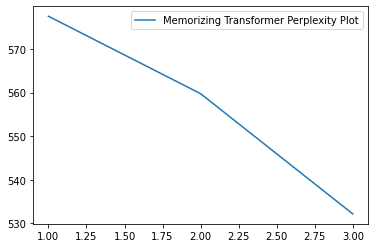

In [45]:
plt.plot(np.arange(epochs + 1)[1:], perplexity_list, label = "Memorizing Transformer Perplexity Plot")
plt.legend()
plt.show()

# Transformer decoder training

In this section we have defined the TransformerDecoder class that allows to create decoder-only transformers. We have trained an object of this class in order to compare it to the memorizing transformer of the previous section.

In [ ]:
class TransformerDecoder(nn.Module): #decoder-only architecture of the transformer
  def __init__(
        self,
        num_tokens,
        d,
        heads = 8,
        depth = 4,
        hidden_size = 1000,
        dropout = 0.3,
        batch_size = 16,
        use_bert = True
    ):
      self.use_bert = use_bert
      self.d = d if not self.use_bert else 768
      assert self.d % heads == 0
 
      super(TransformerDecoder, self).__init__()
      #self.token_emb = nn.Embedding(num_tokens, self.d)
      self.token_emb = BertModel.from_pretrained('bert-base-uncased')
      self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
      self.dim_head = self.d // heads
      self.heads = heads
      self.depth = depth
      self.hidden_size = hidden_size
      self.dropout = dropout
      self.batch_size = batch_size

      self.layers = nn.ModuleList([])
      for idx in range(depth):
          self.layers.append(
              TransformerBlock(d, heads, batch_size, hidden_size, dropout)
          )

      self.to_out = nn.Linear(d, num_tokens)
    
  def create_mask(self, x):
    batch_size, seq_len = x.shape
    mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
        batch_size, 1, seq_len, seq_len
    )
    return mask 
          
  def forward(self, x):
    mask = self.create_mask(x)

    if self.use_bert:
      x = self.token_emb(x)[0] #with bert
    else:
      x = self.token_emb(x) #without bert
    x = self.positional_enc(x)

    for idx in range(self.depth):
        x= self.layers[idx](x, mask)

    return self.to_out(x).transpose(1, 2)

In [ ]:
# constants

BATCH_SIZE = 8
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS
DIM_HEAD_BERT = 768 // HEADS
LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
CHECKPOINT = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tr_decoder = TransformerDecoder(
    num_tokens = vocabulary_size,
    d = SEQ_LEN,
    depth = 4,
    heads = HEADS,
    hidden_size = 5000,
    batch_size = BATCH_SIZE,
    use_bert = True
).to(device)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [ ]:
# optimizer
optimizer = torch.optim.Adam(tr_decoder.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_tr_decoder = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    tr_decoder.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

      out = tr_decoder(seq)

      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None
    

  if e % EVAL_EVERY == 0:
    tr_decoder.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

          out = tr_decoder(seq)

          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_tr_decoder.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer_tr_decoder.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    #Luigi
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'wb') as pklfile:
      pkl.dump(perplexity_tr_decoder, pklfile)

In [ ]:
"""
perplexity_tr_decoder = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
  perplexity_tr_decoder = pkl.load(pklfile)
"""

"\nperplexity_tr_decoder = []\nwith open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:\n  perplexity_tr_decoder = pkl.load(pklfile)\n  pklfile.close()\n"

In [ ]:
plt.plot(np.arange(epochs + 1)[1:], perplexity_tr_decoder, label = 'Perplexity transformer decoder')
plt.legend()
plt.show()

A further experiment to do could be the memory fine-tuning, where a KNNMemory object is passed to a decoder-only transformer only after some training epochs. In order to do this we would need to modify the TransformerDecoder class or to create a memorizing transformer after some changes in the KNNAttention class. The latter method would consists in modifying the forward method of KNNAttention to handle a missing KNNMemory so that until we pass to the layer a memory the layer acts like a standard multi-head attention.

In the paper memory fine-tuning is showed to be very effective since it allows a transformer to perform like a memorizing transformer after enough training steps. It would be useful because the retrieval of the nearest neighbors from the external memory clearly makes the vanilla memorizing transformer slower than a regular decoder-only transformer and we could avoid for many training steps this computation and achieve the same results.